## <ins> Loading Libraries </ins>

In [1]:
using SimulationService
using EasyModelAnalysis
using JSON3
using HTTP
using DataFrames
using CSV
using Dates

## <ins> Loading Models </ins>

In [6]:
url = "https://raw.githubusercontent.com/ciemss/pyciemss/main/notebook/Examples_for_TA2_Model_Representation/"
files = ["SEIARHDS_AMR.json", "SEIARHD_AMR.json", "SIRHD_AMR.json"]
syss = map(x->SimulationService.ode_system_from_amr(SimulationService.get_json(url * x)), files)

3-element Vector{ODESystem}:
 ODESystem(0x0000000000000000, Equation[Differential(t)(susceptible_population(t)) ~ (-beta*(delta*symptomatic_population(t) + asymptomatic_population(t))*susceptible_population(t)) / total_population + recovered_population(t) / tau, Differential(t)(symptomatic_population(t)) ~ (pS*exposed_population(t)) / alpha - dnh*gamma*symptomatic_population(t) - gamma*hosp*symptomatic_population(t) - gamma*(1.0 - dnh - hosp)*symptomatic_population(t), Differential(t)(asymptomatic_population(t)) ~ ((1.0 - pS)*exposed_population(t)) / alpha - gamma*asymptomatic_population(t), Differential(t)(exposed_population(t)) ~ ((pS - 1.0)*exposed_population(t)) / alpha + (-pS*exposed_population(t)) / alpha + (beta*(delta*symptomatic_population(t) + asymptomatic_population(t))*susceptible_population(t)) / total_population, Differential(t)(recovered_population(t)) ~ gamma*asymptomatic_population(t) + ((1.0 - dh)*hospitalized_population(t)) / los + (-recovered_population(t)) / tau + 

## <ins> Dataset Preprocessing </ins>

Download all 6 datasets from https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth. Make sure the datasets are in the same directory as this notebook

### Convert CSVs into DataFrames for Preprocessing

In [7]:
ds_nms = ["Cumulative_Deaths", 
            "Cumulative_Hospitalizations"]

paths = ["$label.csv" for label in ds_nms]
dfs = map(x->DataFrame(CSV.File(x)), paths)

2-element Vector{DataFrame}:
 3641600×4 DataFrame
     Row │ date        location  location_name   value   
         │ Date        String7   String31        Int64   
─────────┼───────────────────────────────────────────────
       1 │ 2020-01-22  01001     Autauga County        0
       2 │ 2020-01-23  01001     Autauga County        0
       3 │ 2020-01-24  01001     Autauga County        0
       4 │ 2020-01-25  01001     Autauga County        0
       5 │ 2020-01-26  01001     Autauga County        0
       6 │ 2020-01-27  01001     Autauga County        0
       7 │ 2020-01-28  01001     Autauga County        0
       8 │ 2020-01-29  01001     Autauga County        0
    ⋮    │     ⋮          ⋮            ⋮            ⋮
 3641594 │ 2023-02-26  US        United States   1119677
 3641595 │ 2023-02-27  US        United States   1119667
 3641596 │ 2023-02-28  US        United States   1120002
 3641597 │ 2023-03-01  US        United States   1120911
 3641598 │ 2023-03-02  US        Unite

### Grab Data for a Single State

In [8]:
#Hospitalization needs to be sorted - date data is not in increasing order
dfs[2] = sort(dfs[2], :date)
#Choose state to grab data from
row_nm = "Michigan"
#Preprocess datasets to only contain data from chosen state
dfs_state = [filter(row -> row["location_name"] in [row_nm],df) for df in dfs]
#In order to ensure data shares time points, need to find their intersection across dates
common_values = intersect(dfs_state[1][!, "date"], dfs_state[2][!, "date"])
dfs_state_h = [filter(row -> row["date"] in common_values, df) for df in dfs_state]

2-element Vector{DataFrame}:
 69×4 DataFrame
 Row │ date        location  location_name  value 
     │ Date        String7   String31       Int64 
─────┼────────────────────────────────────────────
   1 │ 2020-08-18  26        Michigan        6608
   2 │ 2020-08-26  26        Michigan        6690
   3 │ 2020-08-28  26        Michigan        6712
   4 │ 2020-08-30  26        Michigan        6748
   5 │ 2020-09-21  26        Michigan        6981
   6 │ 2020-09-25  26        Michigan        7027
   7 │ 2020-09-29  26        Michigan        7072
   8 │ 2020-09-30  26        Michigan        7083
  ⋮  │     ⋮          ⋮            ⋮          ⋮
  63 │ 2021-03-14  26        Michigan       16769
  64 │ 2021-03-17  26        Michigan       16809
  65 │ 2021-03-18  26        Michigan       16843
  66 │ 2021-03-21  26        Michigan       16906
  67 │ 2021-03-23  26        Michigan       16932
  68 │ 2021-03-26  26        Michigan       17023
  69 │ 2021-05-18  26        Michigan       19899
    

### Convert dates into time

In [9]:
#Need to create static index that maps dates to a day number starting from 0
day_since_start(date::Date, start_date::Date) = (date - start_date).value
dates = [df[df.location_name .== row_nm, :].date for df in dfs]
unique_dates = unique(sort(vcat(dates...)))
start_date = first(unique_dates)
end_date = last(unique_dates)
num_days = end_date - start_date

1137 days

In [10]:
#Convert dates into time
tss = map(x->day_since_start.(x, Ref(start_date)), getproperty.(dfs_state_h, Ref(:date)))
#Get values at each time point
vals = getproperty.(dfs_state_h, Ref(:value))
data_dict = Dict()
map((nm,k,v)-> data_dict[nm] = Dict("ts"=>k, "vals"=>v),ds_nms,tss,vals)

2-element Vector{Dict{String, Vector{Int64}}}:
 Dict("vals" => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16658, 16662, 16769, 16769, 16809, 16843, 16906, 16932, 17023, 19899], "ts" => [209, 217, 219, 221, 243, 247, 251, 252, 257, 260  …  410, 411, 416, 417, 420, 421, 424, 426, 429, 482])
 Dict("vals" => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  4098, 14349, 2313, 6567, 6253, 12351, 11171, 3070, 2598, 168], "ts" => [209, 217, 219, 221, 243, 247, 251, 252, 257, 260  …  410, 411, 416, 417, 420, 421, 424, 426, 429, 482])

### Splitting Datasets

In [11]:
#Assigning dataset type to corresponding state 
D_nm = ds_nms[1]
H_nm = ds_nms[2]

"Cumulative_Hospitalizations"

In [12]:
#Train Data
train_idx = 60
t_train = tss[1][1:train_idx]
data_train = map(x->[
    x.deceased_population => data_dict[D_nm]["vals"][1:train_idx],
    x.hospitalized_population => data_dict[H_nm]["vals"][1:train_idx]
], syss)

3-element Vector{Vector{Pair{Num, Vector{Int64}}}}:
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16019, 16160, 16274, 16342, 16342, 16438, 16508, 16589, 16601, 16658], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  11555, 10164, 11832, 10242, 15160, 10349, 14443, 6370, 11955, 4098]]
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16019, 16160, 16274, 16342, 16342, 16438, 16508, 16589, 16601, 16658], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  11555, 10164, 11832, 10242, 15160, 10349, 14443, 6370, 11955, 4098]]
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16019, 16160, 16274, 16342, 16342, 16438, 16508, 16589, 16601, 16658], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 1

In [13]:
#Ensemble data
ensem_idx = 65
t_ensem = tss[1][1:ensem_idx]
data_ensem = map(x->[
    x.deceased_population => data_dict[D_nm]["vals"][1:ensem_idx],
    x.hospitalized_population => data_dict[H_nm]["vals"][1:ensem_idx]
], syss)

3-element Vector{Vector{Pair{Num, Vector{Int64}}}}:
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16438, 16508, 16589, 16601, 16658, 16662, 16769, 16769, 16809, 16843], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  10349, 14443, 6370, 11955, 4098, 14349, 2313, 6567, 6253, 12351]]
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16438, 16508, 16589, 16601, 16658, 16662, 16769, 16769, 16809, 16843], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  10349, 14443, 6370, 11955, 4098, 14349, 2313, 6567, 6253, 12351]]
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16438, 16508, 16589, 16601, 16658, 16662, 16769, 16769, 16809, 16843], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 

In [14]:
#Forecast data
forcst_idx = 69
t_forecast = tss[1][1:forcst_idx]
data_forecast = map(x->[
    x.deceased_population => data_dict[D_nm]["vals"][1:forcst_idx],
    x.hospitalized_population => data_dict[H_nm]["vals"][1:forcst_idx]
], syss)

3-element Vector{Vector{Pair{Num, Vector{Int64}}}}:
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16658, 16662, 16769, 16769, 16809, 16843, 16906, 16932, 17023, 19899], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  4098, 14349, 2313, 6567, 6253, 12351, 11171, 3070, 2598, 168]]
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16658, 16662, 16769, 16769, 16809, 16843, 16906, 16932, 17023, 19899], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  4098, 14349, 2313, 6567, 6253, 12351, 11171, 3070, 2598, 168]]
 [Model₊deceased_population(t) => [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16658, 16662, 16769, 16769, 16809, 16843, 16906, 16932, 17023, 19899], Model₊hospitalized_population(t) => [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  

## Calibrating Ensemble Model to Dataset

In [15]:
##Loading Models
url = "https://raw.githubusercontent.com/ciemss/pyciemss/main/notebook/Examples_for_TA2_Model_Representation/"
files = ["SEIARHDS_AMR.json", "SEIARHD_AMR.json", "SIRHD_AMR.json"]
syss = map(x->SimulationService.ode_system_from_amr(SimulationService.get_json(url * x)), files)
syss = map(add_accumulations, syss)

3-element Vector{ODESystem}:
 ODESystem(0x0000000000000003, Equation[Differential(t)(susceptible_population(t)) ~ (-beta*(delta*symptomatic_population(t) + asymptomatic_population(t))*susceptible_population(t)) / total_population + recovered_population(t) / tau, Differential(t)(symptomatic_population(t)) ~ (pS*exposed_population(t)) / alpha - dnh*gamma*symptomatic_population(t) - gamma*hosp*symptomatic_population(t) - gamma*(1.0 - dnh - hosp)*symptomatic_population(t), Differential(t)(asymptomatic_population(t)) ~ ((1.0 - pS)*exposed_population(t)) / alpha - gamma*asymptomatic_population(t), Differential(t)(exposed_population(t)) ~ ((pS - 1.0)*exposed_population(t)) / alpha + (-pS*exposed_population(t)) / alpha + (beta*(delta*symptomatic_population(t) + asymptomatic_population(t))*susceptible_population(t)) / total_population, Differential(t)(recovered_population(t)) ~ gamma*asymptomatic_population(t) + ((1.0 - dh)*hospitalized_population(t)) / los + (-recovered_population(t)) / tau + 

In [16]:
##Splitting datasets
#Assigning dataset type to corresponding state 
D_nm = ds_nms[1]
H_nm = ds_nms[2]

#Train Data
train_idx = 60
t_train = tss[1][1:train_idx]
data_train = map(x->[
    x.deceased_population => (t_train,data_dict[D_nm]["vals"][1:train_idx]),
    x.hospitalized_population => (t_train, data_dict[H_nm]["vals"][1:train_idx])
], syss)


#Ensemble data
ensem_idx = 65
t_ensem = tss[1][1:ensem_idx]
data_ensem = map(x->[
    x.deceased_population => (t_ensem, data_dict[D_nm]["vals"][1:ensem_idx]),
    x.hospitalized_population => (t_ensem, data_dict[H_nm]["vals"][1:ensem_idx])
], syss)

#Forecast data
forcst_idx = 69
t_forecast = tss[1][1:forcst_idx]
data_forecast = map(x->[
    x.deceased_population => (t_forecast, data_dict[D_nm]["vals"][1:forcst_idx]),
    x.hospitalized_population => (t_forecast, data_dict[H_nm]["vals"][1:forcst_idx])
], syss)

3-element Vector{Vector{Pair{Num, Tuple{Vector{Int64}, Vector{Int64}}}}}:
 [Model₊deceased_population(t) => ([209, 217, 219, 221, 243, 247, 251, 252, 257, 260  …  410, 411, 416, 417, 420, 421, 424, 426, 429, 482], [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16658, 16662, 16769, 16769, 16809, 16843, 16906, 16932, 17023, 19899]), Model₊hospitalized_population(t) => ([209, 217, 219, 221, 243, 247, 251, 252, 257, 260  …  410, 411, 416, 417, 420, 421, 424, 426, 429, 482], [10919, 13723, 11613, 3388, 6412, 15083, 13959, 2753, 10860, 2671  …  4098, 14349, 2313, 6567, 6253, 12351, 11171, 3070, 2598, 168])]
 [Model₊deceased_population(t) => ([209, 217, 219, 221, 243, 247, 251, 252, 257, 260  …  410, 411, 416, 417, 420, 421, 424, 426, 429, 482], [6608, 6690, 6712, 6748, 6981, 7027, 7072, 7083, 7139, 7193  …  16658, 16662, 16769, 16769, 16809, 16843, 16906, 16932, 17023, 19899]), Model₊hospitalized_population(t) => ([209, 217, 219, 221, 243, 247, 251, 252, 257, 260  …  410, 41

In [17]:
##Setting up priors for each of the parameters
bound_gen = [0.05, 1.95]'
symbols_ps = [(collect(sys.ps)) for sys in syss]

pss = map(symbols_ps, syss) do syms_p, sys
    getvals_ps = getindex.(Ref(sys.defaults), syms_p) .* bound_gen
    syms_p .=> map(x->Uniform(extrema(x)...), eachrow(getvals_ps))
end

3-element Vector{Vector{Pair{Num, Uniform{Float64}}}}:
 [beta => Uniform{Float64}(a=0.027500000000000004, b=1.0725), delta => Uniform{Float64}(a=0.07500000000000001, b=2.925), total_population => Uniform{Float64}(a=5000.0, b=195000.0), alpha => Uniform{Float64}(a=0.2, b=7.8), pS => Uniform{Float64}(a=0.034999999999999996, b=1.365), gamma => Uniform{Float64}(a=0.010000000000000002, b=0.39), hosp => Uniform{Float64}(a=0.005000000000000001, b=0.195), dnh => Uniform{Float64}(a=5.0e-5, b=0.00195), dh => Uniform{Float64}(a=0.005000000000000001, b=0.195), los => Uniform{Float64}(a=0.35000000000000003, b=13.65), tau => Uniform{Float64}(a=1.5, b=58.5)]
 [beta => Uniform{Float64}(a=0.027500000000000004, b=1.0725), delta => Uniform{Float64}(a=0.07500000000000001, b=2.925), total_population => Uniform{Float64}(a=5000.0, b=195000.0), alpha => Uniform{Float64}(a=0.2, b=7.8), pS => Uniform{Float64}(a=0.034999999999999996, b=1.365), gamma => Uniform{Float64}(a=0.010000000000000002, b=0.39), hosp => Un

In [18]:
nprobs = map(x->ODEProblem(x, [], extrema(t_train)), syss);
enprobs = bayesian_ensemble(nprobs, pss, data_train)
sol = solve(enprobs)

Sampling (Chain 1 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 1 of 4)   0%|█                          |  ETA: 4:29:59


Sampling (Chain 1 of 4)   1%|█                          |  ETA: 2:14:52


Sampling (Chain 1 of 4)   1%|█                          |  ETA: 1:31:57


Sampling (Chain 1 of 4)   2%|█                          |  ETA: 1:11:25


Sampling (Chain 1 of 4)   2%|█                          |  ETA: 0:58:14


Sampling (Chain 1 of 4)   3%|█                          |  ETA: 0:50:06


Sampling (Chain 1 of 4)   3%|█                          |  ETA: 0:44:02


Sampling (Chain 1 of 4)   4%|██                         |  ETA: 0:39:04


Sampling (Chain 1 of 4)   4%|██                         |  ETA: 0:35:21


Sampling (Chain 1 of 4)   5%|██                         |  ETA: 0:32:10


Sampling (Chain 1 of 4)   5%|██                         |  ETA: 0:29:49


Sampling (Chain 1 of 4)   6%|██                         |  ETA: 0:27:51


Sampling (Chain 1 of 4)   6%|██                         |  ETA: 0:26:04


Sampling (Chain 1 of 4)   7%|██                         |  ETA: 0:24:28


Sampling (Chain 1 of 4)   7%|██                         |  ETA: 0:23:00


Sampling (Chain 1 of 4)   7%|███                        |  ETA: 0:21:41


Sampling (Chain 1 of 4)   8%|███                        |  ETA: 0:20:29


Sampling (Chain 1 of 4)   8%|███                        |  ETA: 0:19:31


Sampling (Chain 1 of 4)   9%|███                        |  ETA: 0:18:40


Sampling (Chain 1 of 4)   9%|███                        |  ETA: 0:17:52


Sampling (Chain 1 of 4)  10%|███                        |  ETA: 0:17:05


Sampling (Chain 1 of 4)  10%|███                        |  ETA: 0:16:24


Sampling (Chain 1 of 4)  11%|███                        |  ETA: 0:15:48


Sampling (Chain 1 of 4)  11%|████                       |  ETA: 0:15:15


Sampling (Chain 1 of 4)  12%|████                       |  ETA: 0:15:00


Sampling (Chain 1 of 4)  12%|████                       |  ETA: 0:14:37


Sampling (Chain 1 of 4)  13%|████                       |  ETA: 0:14:21


Sampling (Chain 1 of 4)  13%|████                       |  ETA: 0:13:53


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:13:27


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:13:04


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:12:40


Sampling (Chain 1 of 4)  15%|█████                      |  ETA: 0:12:16


Sampling (Chain 1 of 4)  15%|█████                      |  ETA: 0:11:56


Sampling (Chain 1 of 4)  16%|█████                      |  ETA: 0:11:38


Sampling (Chain 1 of 4)  16%|█████                      |  ETA: 0:11:26


Sampling (Chain 1 of 4)  17%|█████                      |  ETA: 0:11:08
Sampling (Chain 1 of 4)  17%|█████                      |  ETA: 0:10:56

Sampling (Chain 1 of 4)  18%|█████                      |  ETA: 0:10:47


Sampling (Chain 1 of 4)  18%|█████                      |  ETA: 0:10:37


Sampling (Chain 1 of 4)  19%|██████                     |  ETA: 0:10:22


Sampling (Chain 1 of 4)  19%|██████                     |  ETA: 0:10:11


Sampling (Chain 1 of 4)  20%|██████                     |  ETA: 0:09:59


Sampling (Chain 1 of 4)  20%|██████                     |  ETA: 0:09:44


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:09:31


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:09:18


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:09:11


Sampling (Chain 1 of 4)  22%|██████                     |  ETA: 0:09:00


Sampling (Chain 1 of 4)  22%|███████                    |  ETA: 0:08:49


Sampling (Chain 1 of 4)  23%|███████                    |  ETA: 0:08:41


Sampling (Chain 1 of 4)  23%|███████                    |  ETA: 0:08:33


Sampling (Chain 1 of 4)  24%|███████                    |  ETA: 0:08:25


Sampling (Chain 1 of 4)  24%|███████                    |  ETA: 0:08:15


Sampling (Chain 1 of 4)  25%|███████                    |  ETA: 0:08:07


Sampling (Chain 1 of 4)  25%|███████                    |  ETA: 0:07:59


Sampling (Chain 1 of 4)  26%|███████                    |  ETA: 0:07:50


Sampling (Chain 1 of 4)  26%|████████                   |  ETA: 0:07:41


Sampling (Chain 1 of 4)  27%|████████                   |  ETA: 0:07:32


Sampling (Chain 1 of 4)  27%|████████                   |  ETA: 0:07:25


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:07:18


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:07:09


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:07:02


Sampling (Chain 1 of 4)  29%|████████                   |  ETA: 0:06:55


Sampling (Chain 1 of 4)  29%|████████                   |  ETA: 0:06:49


Sampling (Chain 1 of 4)  30%|█████████                  |  ETA: 0:06:42


Sampling (Chain 1 of 4)  30%|█████████                  |  ETA: 0:06:37


Sampling (Chain 1 of 4)  31%|█████████                  |  ETA: 0:06:34


Sampling (Chain 1 of 4)  31%|█████████                  |  ETA: 0:06:29


Sampling (Chain 1 of 4)  32%|█████████                  |  ETA: 0:06:24


Sampling (Chain 1 of 4)  32%|█████████                  |  ETA: 0:06:20


Sampling (Chain 1 of 4)  33%|█████████                  |  ETA: 0:06:13


Sampling (Chain 1 of 4)  33%|█████████                  |  ETA: 0:06:08


Sampling (Chain 1 of 4)  34%|██████████                 |  ETA: 0:06:02


Sampling (Chain 1 of 4)  34%|██████████                 |  ETA: 0:05:57


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:05:51


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:05:46


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:05:41


Sampling (Chain 1 of 4)  36%|██████████                 |  ETA: 0:05:36


Sampling (Chain 1 of 4)  36%|██████████                 |  ETA: 0:05:31


Sampling (Chain 1 of 4)  37%|██████████                 |  ETA: 0:05:26


Sampling (Chain 1 of 4)  37%|███████████                |  ETA: 0:05:22


Sampling (Chain 1 of 4)  38%|███████████                |  ETA: 0:05:18


Sampling (Chain 1 of 4)  38%|███████████                |  ETA: 0:05:13


Sampling (Chain 1 of 4)  39%|███████████                |  ETA: 0:05:09


Sampling (Chain 1 of 4)  39%|███████████                |  ETA: 0:05:05


Sampling (Chain 1 of 4)  40%|███████████                |  ETA: 0:05:00


Sampling (Chain 1 of 4)  40%|███████████                |  ETA: 0:04:55


Sampling (Chain 1 of 4)  41%|███████████                |  ETA: 0:04:51


Sampling (Chain 1 of 4)  41%|████████████               |  ETA: 0:04:47


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:04:43


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:04:39


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:04:35


Sampling (Chain 1 of 4)  43%|████████████               |  ETA: 0:04:32


Sampling (Chain 1 of 4)  43%|████████████               |  ETA: 0:04:28


Sampling (Chain 1 of 4)  44%|████████████               |  ETA: 0:04:24


Sampling (Chain 1 of 4)  44%|████████████               |  ETA: 0:04:20


Sampling (Chain 1 of 4)  45%|█████████████              |  ETA: 0:04:17
Sampling (Chain 1 of 4)  45%|█████████████              |  ETA: 0:04:13

Sampling (Chain 1 of 4)  46%|█████████████              |  ETA: 0:04:10


Sampling (Chain 1 of 4)  46%|█████████████              |  ETA: 0:04:06


Sampling (Chain 1 of 4)  47%|█████████████              |  ETA: 0:04:03


Sampling (Chain 1 of 4)  47%|█████████████              |  ETA: 0:04:00


Sampling (Chain 1 of 4)  48%|█████████████              |  ETA: 0:03:56


Sampling (Chain 1 of 4)  48%|█████████████              |  ETA: 0:03:53


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:03:50


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:03:47


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:03:44


Sampling (Chain 1 of 4)  50%|██████████████             |  ETA: 0:03:41


Sampling (Chain 1 of 4)  50%|██████████████             |  ETA: 0:03:38


Sampling (Chain 1 of 4)  51%|██████████████             |  ETA: 0:03:35


Sampling (Chain 1 of 4)  51%|██████████████             |  ETA: 0:03:32


Sampling (Chain 1 of 4)  52%|██████████████             |  ETA: 0:03:29


Sampling (Chain 1 of 4)  52%|███████████████            |  ETA: 0:03:27


Sampling (Chain 1 of 4)  53%|███████████████            |  ETA: 0:03:24


Sampling (Chain 1 of 4)  53%|███████████████            |  ETA: 0:03:21


Sampling (Chain 1 of 4)  54%|███████████████            |  ETA: 0:03:18


Sampling (Chain 1 of 4)  54%|███████████████            |  ETA: 0:03:15


Sampling (Chain 1 of 4)  55%|███████████████            |  ETA: 0:03:13


Sampling (Chain 1 of 4)  55%|███████████████            |  ETA: 0:03:10


Sampling (Chain 1 of 4)  56%|███████████████            |  ETA: 0:03:07


Sampling (Chain 1 of 4)  56%|████████████████           |  ETA: 0:03:05


Sampling (Chain 1 of 4)  56%|████████████████           |  ETA: 0:03:02


Sampling (Chain 1 of 4)  57%|████████████████           |  ETA: 0:03:00


Sampling (Chain 1 of 4)  57%|████████████████           |  ETA: 0:02:57


Sampling (Chain 1 of 4)  58%|████████████████           |  ETA: 0:02:55


Sampling (Chain 1 of 4)  58%|████████████████           |  ETA: 0:02:52


Sampling (Chain 1 of 4)  59%|████████████████           |  ETA: 0:02:50


Sampling (Chain 1 of 4)  59%|█████████████████          |  ETA: 0:02:47


Sampling (Chain 1 of 4)  60%|█████████████████          |  ETA: 0:02:45


Sampling (Chain 1 of 4)  60%|█████████████████          |  ETA: 0:02:42


Sampling (Chain 1 of 4)  61%|█████████████████          |  ETA: 0:02:40


Sampling (Chain 1 of 4)  61%|█████████████████          |  ETA: 0:02:37


Sampling (Chain 1 of 4)  62%|█████████████████          |  ETA: 0:02:35


Sampling (Chain 1 of 4)  62%|█████████████████          |  ETA: 0:02:32


Sampling (Chain 1 of 4)  63%|█████████████████          |  ETA: 0:02:30


Sampling (Chain 1 of 4)  63%|██████████████████         |  ETA: 0:02:28


Sampling (Chain 1 of 4)  63%|██████████████████         |  ETA: 0:02:26


Sampling (Chain 1 of 4)  64%|██████████████████         |  ETA: 0:02:23


Sampling (Chain 1 of 4)  64%|██████████████████         |  ETA: 0:02:21


Sampling (Chain 1 of 4)  65%|██████████████████         |  ETA: 0:02:19


Sampling (Chain 1 of 4)  65%|██████████████████         |  ETA: 0:02:16


Sampling (Chain 1 of 4)  66%|██████████████████         |  ETA: 0:02:14


Sampling (Chain 1 of 4)  66%|██████████████████         |  ETA: 0:02:12


Sampling (Chain 1 of 4)  67%|███████████████████        |  ETA: 0:02:10


Sampling (Chain 1 of 4)  67%|███████████████████        |  ETA: 0:02:08


Sampling (Chain 1 of 4)  68%|███████████████████        |  ETA: 0:02:06


Sampling (Chain 1 of 4)  68%|███████████████████        |  ETA: 0:02:03


Sampling (Chain 1 of 4)  69%|███████████████████        |  ETA: 0:02:02


Sampling (Chain 1 of 4)  69%|███████████████████        |  ETA: 0:01:59


Sampling (Chain 1 of 4)  70%|███████████████████        |  ETA: 0:01:57


Sampling (Chain 1 of 4)  70%|███████████████████        |  ETA: 0:01:55


Sampling (Chain 1 of 4)  70%|████████████████████       |  ETA: 0:01:53


Sampling (Chain 1 of 4)  71%|████████████████████       |  ETA: 0:01:51


Sampling (Chain 1 of 4)  71%|████████████████████       |  ETA: 0:01:49


Sampling (Chain 1 of 4)  72%|████████████████████       |  ETA: 0:01:47


Sampling (Chain 1 of 4)  72%|████████████████████       |  ETA: 0:01:45


Sampling (Chain 1 of 4)  73%|████████████████████       |  ETA: 0:01:43


Sampling (Chain 1 of 4)  73%|████████████████████       |  ETA: 0:01:41


Sampling (Chain 1 of 4)  74%|████████████████████       |  ETA: 0:01:39


Sampling (Chain 1 of 4)  74%|█████████████████████      |  ETA: 0:01:37


Sampling (Chain 1 of 4)  75%|█████████████████████      |  ETA: 0:01:35


Sampling (Chain 1 of 4)  75%|█████████████████████      |  ETA: 0:01:33


Sampling (Chain 1 of 4)  76%|█████████████████████      |  ETA: 0:01:31


Sampling (Chain 1 of 4)  76%|█████████████████████      |  ETA: 0:01:29


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:01:27


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:01:25


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:01:23


Sampling (Chain 1 of 4)  78%|██████████████████████     |  ETA: 0:01:22


Sampling (Chain 1 of 4)  78%|██████████████████████     |  ETA: 0:01:20


Sampling (Chain 1 of 4)  79%|██████████████████████     |  ETA: 0:01:18


Sampling (Chain 1 of 4)  79%|██████████████████████     |  ETA: 0:01:16


Sampling (Chain 1 of 4)  80%|██████████████████████     |  ETA: 0:01:14


Sampling (Chain 1 of 4)  80%|██████████████████████     |  ETA: 0:01:12


Sampling (Chain 1 of 4)  81%|██████████████████████     |  ETA: 0:01:10


Sampling (Chain 1 of 4)  81%|██████████████████████     |  ETA: 0:01:09


Sampling (Chain 1 of 4)  82%|███████████████████████    |  ETA: 0:01:07


Sampling (Chain 1 of 4)  82%|███████████████████████    |  ETA: 0:01:05


Sampling (Chain 1 of 4)  83%|███████████████████████    |  ETA: 0:01:03


Sampling (Chain 1 of 4)  83%|███████████████████████    |  ETA: 0:01:01


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:59


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:58


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:56


Sampling (Chain 1 of 4)  85%|███████████████████████    |  ETA: 0:00:54


Sampling (Chain 1 of 4)  85%|████████████████████████   |  ETA: 0:00:52


Sampling (Chain 1 of 4)  86%|████████████████████████   |  ETA: 0:00:51


Sampling (Chain 1 of 4)  86%|████████████████████████   |  ETA: 0:00:49


Sampling (Chain 1 of 4)  87%|████████████████████████   |  ETA: 0:00:47


Sampling (Chain 1 of 4)  87%|████████████████████████   |  ETA: 0:00:45


Sampling (Chain 1 of 4)  88%|████████████████████████   |  ETA: 0:00:44


Sampling (Chain 1 of 4)  88%|████████████████████████   |  ETA: 0:00:42


Sampling (Chain 1 of 4)  89%|████████████████████████   |  ETA: 0:00:40


Sampling (Chain 1 of 4)  89%|█████████████████████████  |  ETA: 0:00:39


Sampling (Chain 1 of 4)  90%|█████████████████████████  |  ETA: 0:00:37


Sampling (Chain 1 of 4)  90%|█████████████████████████  |  ETA: 0:00:35


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:33


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:32


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:30


Sampling (Chain 1 of 4)  92%|█████████████████████████  |  ETA: 0:00:28


Sampling (Chain 1 of 4)  92%|█████████████████████████  |  ETA: 0:00:27
Sampling (Chain 1 of 4)  93%|██████████████████████████ |  ETA: 0:00:25

Sampling (Chain 1 of 4)  93%|██████████████████████████ |  ETA: 0:00:23


Sampling (Chain 1 of 4)  94%|██████████████████████████ |  ETA: 0:00:22


Sampling (Chain 1 of 4)  94%|██████████████████████████ |  ETA: 0:00:20


Sampling (Chain 1 of 4)  95%|██████████████████████████ |  ETA: 0:00:18


Sampling (Chain 1 of 4)  95%|██████████████████████████ |  ETA: 0:00:17


Sampling (Chain 1 of 4)  96%|██████████████████████████ |  ETA: 0:00:15


Sampling (Chain 1 of 4)  96%|██████████████████████████ |  ETA: 0:00:13


Sampling (Chain 1 of 4)  97%|███████████████████████████|  ETA: 0:00:12


Sampling (Chain 1 of 4)  97%|███████████████████████████|  ETA: 0:00:10


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:09


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:07


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:05


Sampling (Chain 1 of 4)  99%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 1 of 4)  99%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 1 of 4) 100%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 1 of 4) 100%|███████████████████████████| Time: 0:05:42


Sampling (Chain 2 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 4.8828125e-5
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 2 of 4)   0%|█                          |  ETA: 0:03:00


Sampling (Chain 2 of 4)   1%|█                          |  ETA: 0:03:48


Sampling (Chain 2 of 4)   1%|█                          |  ETA: 0:06:22

Sampling (Chain 2 of 4)   2%|█                          |  ETA: 0:09:44
Sampling (Chain 2 of 4)   2%|█                          |  ETA: 0:09:35


Sampling (Chain 2 of 4)   3%|█                          |  ETA: 0:09:21


Sampling (Chain 2 of 4)   3%|█                          |  ETA: 0:09:46


Sampling (Chain 2 of 4)   4%|██                         |  ETA: 0:10:15


Sampling (Chain 2 of 4)   4%|██                         |  ETA: 0:09:55


Sampling (Chain 2 of 4)   5%|██                         |  ETA: 0:09:55


Sampling (Chain 2 of 4)   5%|██                         |  ETA: 0:09:46


Sampling (Chain 2 of 4)   6%|██                         |  ETA: 0:09:35


Sampling (Chain 2 of 4)   6%|██                         |  ETA: 0:09:26


Sampling (Chain 2 of 4)   7%|██                         |  ETA: 0:09:10


Sampling (Chain 2 of 4)   7%|██                         |  ETA: 0:08:49


Sampling (Chain 2 of 4)   7%|███                        |  ETA: 0:08:33


Sampling (Chain 2 of 4)   8%|███                        |  ETA: 0:08:32


Sampling (Chain 2 of 4)   8%|███                        |  ETA: 0:08:20


Sampling (Chain 2 of 4)   9%|███                        |  ETA: 0:08:00


Sampling (Chain 2 of 4)   9%|███                        |  ETA: 0:07:47


Sampling (Chain 2 of 4)  10%|███                        |  ETA: 0:07:35


Sampling (Chain 2 of 4)  10%|███                        |  ETA: 0:07:22


Sampling (Chain 2 of 4)  11%|███                        |  ETA: 0:07:16


Sampling (Chain 2 of 4)  11%|████                       |  ETA: 0:07:03


Sampling (Chain 2 of 4)  12%|████                       |  ETA: 0:06:57


Sampling (Chain 2 of 4)  12%|████                       |  ETA: 0:06:48


Sampling (Chain 2 of 4)  13%|████                       |  ETA: 0:06:45


Sampling (Chain 2 of 4)  13%|████                       |  ETA: 0:06:39


Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:06:28
Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:06:23

Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:06:19


Sampling (Chain 2 of 4)  15%|█████                      |  ETA: 0:06:15


Sampling (Chain 2 of 4)  15%|█████                      |  ETA: 0:06:09


Sampling (Chain 2 of 4)  16%|█████                      |  ETA: 0:06:00


Sampling (Chain 2 of 4)  16%|█████                      |  ETA: 0:05:55


Sampling (Chain 2 of 4)  17%|█████                      |  ETA: 0:05:48


Sampling (Chain 2 of 4)  17%|█████                      |  ETA: 0:05:51


Sampling (Chain 2 of 4)  18%|█████                      |  ETA: 0:05:55


Sampling (Chain 2 of 4)  18%|█████                      |  ETA: 0:05:53


Sampling (Chain 2 of 4)  19%|██████                     |  ETA: 0:05:51


Sampling (Chain 2 of 4)  19%|██████                     |  ETA: 0:05:52


Sampling (Chain 2 of 4)  20%|██████                     |  ETA: 0:05:49


Sampling (Chain 2 of 4)  20%|██████                     |  ETA: 0:05:46


Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:05:41


Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:05:35


Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:05:33


Sampling (Chain 2 of 4)  22%|██████                     |  ETA: 0:05:28


Sampling (Chain 2 of 4)  22%|███████                    |  ETA: 0:05:25
Sampling (Chain 2 of 4)  23%|███████                    |  ETA: 0:05:21

Sampling (Chain 2 of 4)  23%|███████                    |  ETA: 0:05:19


Sampling (Chain 2 of 4)  24%|███████                    |  ETA: 0:05:17


Sampling (Chain 2 of 4)  24%|███████                    |  ETA: 0:05:20


Sampling (Chain 2 of 4)  25%|███████                    |  ETA: 0:05:22


Sampling (Chain 2 of 4)  25%|███████                    |  ETA: 0:05:20


Sampling (Chain 2 of 4)  26%|███████                    |  ETA: 0:05:24


Sampling (Chain 2 of 4)  26%|████████                   |  ETA: 0:05:24


Sampling (Chain 2 of 4)  27%|████████                   |  ETA: 0:05:22


Sampling (Chain 2 of 4)  27%|████████                   |  ETA: 0:05:24


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:05:24


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:05:23


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:05:21
Sampling (Chain 2 of 4)  29%|████████                   |  ETA: 0:05:24


Sampling (Chain 2 of 4)  29%|████████                   |  ETA: 0:05:23


Sampling (Chain 2 of 4)  30%|█████████                  |  ETA: 0:05:21


Sampling (Chain 2 of 4)  30%|█████████                  |  ETA: 0:05:19


Sampling (Chain 2 of 4)  31%|█████████                  |  ETA: 0:05:17


Sampling (Chain 2 of 4)  31%|█████████                  |  ETA: 0:05:20


Sampling (Chain 2 of 4)  32%|█████████                  |  ETA: 0:05:19


Sampling (Chain 2 of 4)  32%|█████████                  |  ETA: 0:05:18


Sampling (Chain 2 of 4)  33%|█████████                  |  ETA: 0:05:17


Sampling (Chain 2 of 4)  33%|█████████                  |  ETA: 0:05:17


Sampling (Chain 2 of 4)  34%|██████████                 |  ETA: 0:05:15


Sampling (Chain 2 of 4)  34%|██████████                 |  ETA: 0:05:14


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:05:12


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:05:09


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:05:08


Sampling (Chain 2 of 4)  36%|██████████                 |  ETA: 0:05:06


Sampling (Chain 2 of 4)  36%|██████████                 |  ETA: 0:05:04


Sampling (Chain 2 of 4)  37%|██████████                 |  ETA: 0:05:02


Sampling (Chain 2 of 4)  37%|███████████                |  ETA: 0:04:59


Sampling (Chain 2 of 4)  38%|███████████                |  ETA: 0:04:56


Sampling (Chain 2 of 4)  38%|███████████                |  ETA: 0:04:53


Sampling (Chain 2 of 4)  39%|███████████                |  ETA: 0:04:50


Sampling (Chain 2 of 4)  39%|███████████                |  ETA: 0:04:47


Sampling (Chain 2 of 4)  40%|███████████                |  ETA: 0:04:43


Sampling (Chain 2 of 4)  40%|███████████                |  ETA: 0:04:41


Sampling (Chain 2 of 4)  41%|███████████                |  ETA: 0:04:39


Sampling (Chain 2 of 4)  41%|████████████               |  ETA: 0:04:35


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:04:32


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:04:29


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:04:26


Sampling (Chain 2 of 4)  43%|████████████               |  ETA: 0:04:22


Sampling (Chain 2 of 4)  43%|████████████               |  ETA: 0:04:19


Sampling (Chain 2 of 4)  44%|████████████               |  ETA: 0:04:17


Sampling (Chain 2 of 4)  44%|████████████               |  ETA: 0:04:14


Sampling (Chain 2 of 4)  45%|█████████████              |  ETA: 0:04:11


Sampling (Chain 2 of 4)  45%|█████████████              |  ETA: 0:04:08


Sampling (Chain 2 of 4)  46%|█████████████              |  ETA: 0:04:06


Sampling (Chain 2 of 4)  46%|█████████████              |  ETA: 0:04:04


Sampling (Chain 2 of 4)  47%|█████████████              |  ETA: 0:04:00


Sampling (Chain 2 of 4)  47%|█████████████              |  ETA: 0:03:57


Sampling (Chain 2 of 4)  48%|█████████████              |  ETA: 0:03:55


Sampling (Chain 2 of 4)  48%|█████████████              |  ETA: 0:03:52


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:03:50


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:03:47


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:03:44


Sampling (Chain 2 of 4)  50%|██████████████             |  ETA: 0:03:42


Sampling (Chain 2 of 4)  50%|██████████████             |  ETA: 0:03:39


Sampling (Chain 2 of 4)  51%|██████████████             |  ETA: 0:03:37


Sampling (Chain 2 of 4)  51%|██████████████             |  ETA: 0:03:35


Sampling (Chain 2 of 4)  52%|██████████████             |  ETA: 0:03:32


Sampling (Chain 2 of 4)  52%|███████████████            |  ETA: 0:03:29


Sampling (Chain 2 of 4)  53%|███████████████            |  ETA: 0:03:27


Sampling (Chain 2 of 4)  53%|███████████████            |  ETA: 0:03:24


Sampling (Chain 2 of 4)  54%|███████████████            |  ETA: 0:03:21


Sampling (Chain 2 of 4)  54%|███████████████            |  ETA: 0:03:19


Sampling (Chain 2 of 4)  55%|███████████████            |  ETA: 0:03:16


Sampling (Chain 2 of 4)  55%|███████████████            |  ETA: 0:03:14


Sampling (Chain 2 of 4)  56%|███████████████            |  ETA: 0:03:11


Sampling (Chain 2 of 4)  56%|████████████████           |  ETA: 0:03:08


Sampling (Chain 2 of 4)  56%|████████████████           |  ETA: 0:03:06


Sampling (Chain 2 of 4)  57%|████████████████           |  ETA: 0:03:03


Sampling (Chain 2 of 4)  57%|████████████████           |  ETA: 0:03:01


Sampling (Chain 2 of 4)  58%|████████████████           |  ETA: 0:02:58


Sampling (Chain 2 of 4)  58%|████████████████           |  ETA: 0:02:56


Sampling (Chain 2 of 4)  59%|████████████████           |  ETA: 0:02:54


Sampling (Chain 2 of 4)  59%|█████████████████          |  ETA: 0:02:51
Sampling (Chain 2 of 4)  60%|█████████████████          |  ETA: 0:02:49

Sampling (Chain 2 of 4)  60%|█████████████████          |  ETA: 0:02:47


Sampling (Chain 2 of 4)  61%|█████████████████          |  ETA: 0:02:45


Sampling (Chain 2 of 4)  61%|█████████████████          |  ETA: 0:02:42


Sampling (Chain 2 of 4)  62%|█████████████████          |  ETA: 0:02:40


Sampling (Chain 2 of 4)  62%|█████████████████          |  ETA: 0:02:38


Sampling (Chain 2 of 4)  63%|█████████████████          |  ETA: 0:02:35


Sampling (Chain 2 of 4)  63%|██████████████████         |  ETA: 0:02:33
Sampling (Chain 2 of 4)  63%|██████████████████         |  ETA: 0:02:31

Sampling (Chain 2 of 4)  64%|██████████████████         |  ETA: 0:02:29


Sampling (Chain 2 of 4)  64%|██████████████████         |  ETA: 0:02:26


Sampling (Chain 2 of 4)  65%|██████████████████         |  ETA: 0:02:24


Sampling (Chain 2 of 4)  65%|██████████████████         |  ETA: 0:02:22


Sampling (Chain 2 of 4)  66%|██████████████████         |  ETA: 0:02:20


Sampling (Chain 2 of 4)  66%|██████████████████         |  ETA: 0:02:17


Sampling (Chain 2 of 4)  67%|███████████████████        |  ETA: 0:02:15


Sampling (Chain 2 of 4)  67%|███████████████████        |  ETA: 0:02:13


Sampling (Chain 2 of 4)  68%|███████████████████        |  ETA: 0:02:12


Sampling (Chain 2 of 4)  68%|███████████████████        |  ETA: 0:02:10


Sampling (Chain 2 of 4)  69%|███████████████████        |  ETA: 0:02:08


Sampling (Chain 2 of 4)  69%|███████████████████        |  ETA: 0:02:07


Sampling (Chain 2 of 4)  70%|███████████████████        |  ETA: 0:02:05


Sampling (Chain 2 of 4)  70%|███████████████████        |  ETA: 0:02:03


Sampling (Chain 2 of 4)  70%|████████████████████       |  ETA: 0:02:02


Sampling (Chain 2 of 4)  71%|████████████████████       |  ETA: 0:02:01


Sampling (Chain 2 of 4)  71%|████████████████████       |  ETA: 0:01:59


Sampling (Chain 2 of 4)  72%|████████████████████       |  ETA: 0:01:58


Sampling (Chain 2 of 4)  72%|████████████████████       |  ETA: 0:01:56


Sampling (Chain 2 of 4)  73%|████████████████████       |  ETA: 0:01:54


Sampling (Chain 2 of 4)  73%|████████████████████       |  ETA: 0:01:52


Sampling (Chain 2 of 4)  74%|████████████████████       |  ETA: 0:01:51


Sampling (Chain 2 of 4)  74%|█████████████████████      |  ETA: 0:01:49


Sampling (Chain 2 of 4)  75%|█████████████████████      |  ETA: 0:01:47


Sampling (Chain 2 of 4)  75%|█████████████████████      |  ETA: 0:01:45


Sampling (Chain 2 of 4)  76%|█████████████████████      |  ETA: 0:01:44


Sampling (Chain 2 of 4)  76%|█████████████████████      |  ETA: 0:01:42


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:01:40


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:01:38


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:01:36


Sampling (Chain 2 of 4)  78%|██████████████████████     |  ETA: 0:01:34


Sampling (Chain 2 of 4)  78%|██████████████████████     |  ETA: 0:01:32


Sampling (Chain 2 of 4)  79%|██████████████████████     |  ETA: 0:01:30


Sampling (Chain 2 of 4)  79%|██████████████████████     |  ETA: 0:01:27


Sampling (Chain 2 of 4)  80%|██████████████████████     |  ETA: 0:01:25


Sampling (Chain 2 of 4)  80%|██████████████████████     |  ETA: 0:01:23


Sampling (Chain 2 of 4)  81%|██████████████████████     |  ETA: 0:01:21


Sampling (Chain 2 of 4)  81%|██████████████████████     |  ETA: 0:01:19


Sampling (Chain 2 of 4)  82%|███████████████████████    |  ETA: 0:01:17


Sampling (Chain 2 of 4)  82%|███████████████████████    |  ETA: 0:01:15


Sampling (Chain 2 of 4)  83%|███████████████████████    |  ETA: 0:01:13


Sampling (Chain 2 of 4)  83%|███████████████████████    |  ETA: 0:01:11
Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:01:09


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:01:07


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:01:06


Sampling (Chain 2 of 4)  85%|███████████████████████    |  ETA: 0:01:04


Sampling (Chain 2 of 4)  85%|████████████████████████   |  ETA: 0:01:02


Sampling (Chain 2 of 4)  86%|████████████████████████   |  ETA: 0:01:00


Sampling (Chain 2 of 4)  86%|████████████████████████   |  ETA: 0:00:58


Sampling (Chain 2 of 4)  87%|████████████████████████   |  ETA: 0:00:56


Sampling (Chain 2 of 4)  87%|████████████████████████   |  ETA: 0:00:54


Sampling (Chain 2 of 4)  88%|████████████████████████   |  ETA: 0:00:52


Sampling (Chain 2 of 4)  88%|████████████████████████   |  ETA: 0:00:51


Sampling (Chain 2 of 4)  89%|████████████████████████   |  ETA: 0:00:49


Sampling (Chain 2 of 4)  89%|█████████████████████████  |  ETA: 0:00:47


Sampling (Chain 2 of 4)  90%|█████████████████████████  |  ETA: 0:00:45


Sampling (Chain 2 of 4)  90%|█████████████████████████  |  ETA: 0:00:43


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:41


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:39


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:37


Sampling (Chain 2 of 4)  92%|█████████████████████████  |  ETA: 0:00:35


Sampling (Chain 2 of 4)  92%|█████████████████████████  |  ETA: 0:00:33


Sampling (Chain 2 of 4)  93%|██████████████████████████ |  ETA: 0:00:31


Sampling (Chain 2 of 4)  93%|██████████████████████████ |  ETA: 0:00:29


Sampling (Chain 2 of 4)  94%|██████████████████████████ |  ETA: 0:00:27


Sampling (Chain 2 of 4)  94%|██████████████████████████ |  ETA: 0:00:25


Sampling (Chain 2 of 4)  95%|██████████████████████████ |  ETA: 0:00:23


Sampling (Chain 2 of 4)  95%|██████████████████████████ |  ETA: 0:00:21


Sampling (Chain 2 of 4)  96%|██████████████████████████ |  ETA: 0:00:19


Sampling (Chain 2 of 4)  96%|██████████████████████████ |  ETA: 0:00:17


Sampling (Chain 2 of 4)  97%|███████████████████████████|  ETA: 0:00:15


Sampling (Chain 2 of 4)  97%|███████████████████████████|  ETA: 0:00:13


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:11


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:09


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:07


Sampling (Chain 2 of 4)  99%|███████████████████████████|  ETA: 0:00:05


Sampling (Chain 2 of 4)  99%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 2 of 4) 100%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 2 of 4) 100%|███████████████████████████| Time: 0:07:17
Sampling (Chain 3 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 2.44140625e-5
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 3 of 4)   0%|█                          |  ETA: 0:04:30


Sampling (Chain 3 of 4)   1%|█                          |  ETA: 0:02:51


Sampling (Chain 3 of 4)   1%|█                          |  ETA: 0:06:36


Sampling (Chain 3 of 4)   2%|█                          |  ETA: 0:09:47


Sampling (Chain 3 of 4)   2%|█                          |  ETA: 0:10:24


Sampling (Chain 3 of 4)   3%|█                          |  ETA: 0:10:55


Sampling (Chain 3 of 4)   3%|█                          |  ETA: 0:10:45


Sampling (Chain 3 of 4)   4%|██                         |  ETA: 0:10:23


Sampling (Chain 3 of 4)   4%|██                         |  ETA: 0:10:23


Sampling (Chain 3 of 4)   5%|██                         |  ETA: 0:10:44


Sampling (Chain 3 of 4)   5%|██                         |  ETA: 0:10:50


Sampling (Chain 3 of 4)   6%|██                         |  ETA: 0:10:32


Sampling (Chain 3 of 4)   6%|██                         |  ETA: 0:10:21


Sampling (Chain 3 of 4)   7%|██                         |  ETA: 0:10:10


Sampling (Chain 3 of 4)   7%|██                         |  ETA: 0:09:50


Sampling (Chain 3 of 4)   7%|███                        |  ETA: 0:09:42


Sampling (Chain 3 of 4)   8%|███                        |  ETA: 0:09:35


Sampling (Chain 3 of 4)   8%|███                        |  ETA: 0:09:29


Sampling (Chain 3 of 4)   9%|███                        |  ETA: 0:09:12


Sampling (Chain 3 of 4)   9%|███                        |  ETA: 0:09:03


Sampling (Chain 3 of 4)  10%|███                        |  ETA: 0:09:00


Sampling (Chain 3 of 4)  10%|███                        |  ETA: 0:08:47


Sampling (Chain 3 of 4)  11%|███                        |  ETA: 0:08:44


Sampling (Chain 3 of 4)  11%|████                       |  ETA: 0:08:40


Sampling (Chain 3 of 4)  12%|████                       |  ETA: 0:08:39


Sampling (Chain 3 of 4)  12%|████                       |  ETA: 0:08:35


Sampling (Chain 3 of 4)  13%|████                       |  ETA: 0:08:20


Sampling (Chain 3 of 4)  13%|████                       |  ETA: 0:08:10


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:08:00


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:07:49


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:07:42


Sampling (Chain 3 of 4)  15%|█████                      |  ETA: 0:07:31


Sampling (Chain 3 of 4)  15%|█████                      |  ETA: 0:07:24


Sampling (Chain 3 of 4)  16%|█████                      |  ETA: 0:07:12


Sampling (Chain 3 of 4)  16%|█████                      |  ETA: 0:07:04


Sampling (Chain 3 of 4)  17%|█████                      |  ETA: 0:06:55


Sampling (Chain 3 of 4)  17%|█████                      |  ETA: 0:06:48


Sampling (Chain 3 of 4)  18%|█████                      |  ETA: 0:06:41


Sampling (Chain 3 of 4)  18%|█████                      |  ETA: 0:06:32


Sampling (Chain 3 of 4)  19%|██████                     |  ETA: 0:06:28


Sampling (Chain 3 of 4)  19%|██████                     |  ETA: 0:06:23


Sampling (Chain 3 of 4)  20%|██████                     |  ETA: 0:06:19


Sampling (Chain 3 of 4)  20%|██████                     |  ETA: 0:06:13


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:06:10


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:06:04


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:06:02
Sampling (Chain 3 of 4)  22%|██████                     |  ETA: 0:05:57

Sampling (Chain 3 of 4)  22%|███████                    |  ETA: 0:05:53


Sampling (Chain 3 of 4)  23%|███████                    |  ETA: 0:05:50


Sampling (Chain 3 of 4)  23%|███████                    |  ETA: 0:05:46


Sampling (Chain 3 of 4)  24%|███████                    |  ETA: 0:05:42


Sampling (Chain 3 of 4)  24%|███████                    |  ETA: 0:05:37


Sampling (Chain 3 of 4)  25%|███████                    |  ETA: 0:05:33


Sampling (Chain 3 of 4)  25%|███████                    |  ETA: 0:05:29


Sampling (Chain 3 of 4)  26%|███████                    |  ETA: 0:05:25


Sampling (Chain 3 of 4)  26%|████████                   |  ETA: 0:05:19
Sampling (Chain 3 of 4)  27%|████████                   |  ETA: 0:05:17

Sampling (Chain 3 of 4)  27%|████████                   |  ETA: 0:05:13


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:05:10


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:05:05


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:05:01


Sampling (Chain 3 of 4)  29%|████████                   |  ETA: 0:04:58


Sampling (Chain 3 of 4)  29%|████████                   |  ETA: 0:04:55


Sampling (Chain 3 of 4)  30%|█████████                  |  ETA: 0:04:52


Sampling (Chain 3 of 4)  30%|█████████                  |  ETA: 0:04:49


Sampling (Chain 3 of 4)  31%|█████████                  |  ETA: 0:04:47


Sampling (Chain 3 of 4)  31%|█████████                  |  ETA: 0:04:49


Sampling (Chain 3 of 4)  32%|█████████                  |  ETA: 0:04:47


Sampling (Chain 3 of 4)  32%|█████████                  |  ETA: 0:04:44


Sampling (Chain 3 of 4)  33%|█████████                  |  ETA: 0:04:42


Sampling (Chain 3 of 4)  33%|█████████                  |  ETA: 0:04:40


Sampling (Chain 3 of 4)  34%|██████████                 |  ETA: 0:04:38


Sampling (Chain 3 of 4)  34%|██████████                 |  ETA: 0:04:36


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:04:34


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:04:31


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:04:28


Sampling (Chain 3 of 4)  36%|██████████                 |  ETA: 0:04:25


Sampling (Chain 3 of 4)  36%|██████████                 |  ETA: 0:04:21


Sampling (Chain 3 of 4)  37%|██████████                 |  ETA: 0:04:18


Sampling (Chain 3 of 4)  37%|███████████                |  ETA: 0:04:15


Sampling (Chain 3 of 4)  38%|███████████                |  ETA: 0:04:12


Sampling (Chain 3 of 4)  38%|███████████                |  ETA: 0:04:09


Sampling (Chain 3 of 4)  39%|███████████                |  ETA: 0:04:06


Sampling (Chain 3 of 4)  39%|███████████                |  ETA: 0:04:02


Sampling (Chain 3 of 4)  40%|███████████                |  ETA: 0:03:59


Sampling (Chain 3 of 4)  40%|███████████                |  ETA: 0:03:56


Sampling (Chain 3 of 4)  41%|███████████                |  ETA: 0:03:54


Sampling (Chain 3 of 4)  41%|████████████               |  ETA: 0:03:51


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:03:48


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:03:45


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:03:42


Sampling (Chain 3 of 4)  43%|████████████               |  ETA: 0:03:39


Sampling (Chain 3 of 4)  43%|████████████               |  ETA: 0:03:37


Sampling (Chain 3 of 4)  44%|████████████               |  ETA: 0:03:34


Sampling (Chain 3 of 4)  44%|████████████               |  ETA: 0:03:32


Sampling (Chain 3 of 4)  45%|█████████████              |  ETA: 0:03:29


Sampling (Chain 3 of 4)  45%|█████████████              |  ETA: 0:03:27


Sampling (Chain 3 of 4)  46%|█████████████              |  ETA: 0:03:24


Sampling (Chain 3 of 4)  46%|█████████████              |  ETA: 0:03:22


Sampling (Chain 3 of 4)  47%|█████████████              |  ETA: 0:03:19


Sampling (Chain 3 of 4)  47%|█████████████              |  ETA: 0:03:17


Sampling (Chain 3 of 4)  48%|█████████████              |  ETA: 0:03:15


Sampling (Chain 3 of 4)  48%|█████████████              |  ETA: 0:03:12


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:03:10


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:03:07


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:03:05


Sampling (Chain 3 of 4)  50%|██████████████             |  ETA: 0:03:02


Sampling (Chain 3 of 4)  50%|██████████████             |  ETA: 0:03:00


Sampling (Chain 3 of 4)  51%|██████████████             |  ETA: 0:02:58


Sampling (Chain 3 of 4)  51%|██████████████             |  ETA: 0:02:56


Sampling (Chain 3 of 4)  52%|██████████████             |  ETA: 0:02:54


Sampling (Chain 3 of 4)  52%|███████████████            |  ETA: 0:02:52


Sampling (Chain 3 of 4)  53%|███████████████            |  ETA: 0:02:50


Sampling (Chain 3 of 4)  53%|███████████████            |  ETA: 0:02:48


Sampling (Chain 3 of 4)  54%|███████████████            |  ETA: 0:02:47


Sampling (Chain 3 of 4)  54%|███████████████            |  ETA: 0:02:46


Sampling (Chain 3 of 4)  55%|███████████████            |  ETA: 0:02:44


Sampling (Chain 3 of 4)  55%|███████████████            |  ETA: 0:02:43


Sampling (Chain 3 of 4)  56%|███████████████            |  ETA: 0:02:42


Sampling (Chain 3 of 4)  56%|████████████████           |  ETA: 0:02:42


Sampling (Chain 3 of 4)  56%|████████████████           |  ETA: 0:02:40


Sampling (Chain 3 of 4)  57%|████████████████           |  ETA: 0:02:38


Sampling (Chain 3 of 4)  57%|████████████████           |  ETA: 0:02:36


Sampling (Chain 3 of 4)  58%|████████████████           |  ETA: 0:02:34


Sampling (Chain 3 of 4)  58%|████████████████           |  ETA: 0:02:32


Sampling (Chain 3 of 4)  59%|████████████████           |  ETA: 0:02:30


Sampling (Chain 3 of 4)  59%|█████████████████          |  ETA: 0:02:28


Sampling (Chain 3 of 4)  60%|█████████████████          |  ETA: 0:02:26


Sampling (Chain 3 of 4)  60%|█████████████████          |  ETA: 0:02:24


Sampling (Chain 3 of 4)  61%|█████████████████          |  ETA: 0:02:22


Sampling (Chain 3 of 4)  61%|█████████████████          |  ETA: 0:02:20


Sampling (Chain 3 of 4)  62%|█████████████████          |  ETA: 0:02:18


Sampling (Chain 3 of 4)  62%|█████████████████          |  ETA: 0:02:16


Sampling (Chain 3 of 4)  63%|█████████████████          |  ETA: 0:02:14


Sampling (Chain 3 of 4)  63%|██████████████████         |  ETA: 0:02:13


Sampling (Chain 3 of 4)  63%|██████████████████         |  ETA: 0:02:11


Sampling (Chain 3 of 4)  64%|██████████████████         |  ETA: 0:02:10


Sampling (Chain 3 of 4)  64%|██████████████████         |  ETA: 0:02:09


Sampling (Chain 3 of 4)  65%|██████████████████         |  ETA: 0:02:07


Sampling (Chain 3 of 4)  65%|██████████████████         |  ETA: 0:02:06


Sampling (Chain 3 of 4)  66%|██████████████████         |  ETA: 0:02:05


Sampling (Chain 3 of 4)  66%|██████████████████         |  ETA: 0:02:03


Sampling (Chain 3 of 4)  67%|███████████████████        |  ETA: 0:02:02


Sampling (Chain 3 of 4)  67%|███████████████████        |  ETA: 0:02:00


Sampling (Chain 3 of 4)  68%|███████████████████        |  ETA: 0:01:59


Sampling (Chain 3 of 4)  68%|███████████████████        |  ETA: 0:01:57


Sampling (Chain 3 of 4)  69%|███████████████████        |  ETA: 0:01:56


Sampling (Chain 3 of 4)  69%|███████████████████        |  ETA: 0:01:55


Sampling (Chain 3 of 4)  70%|███████████████████        |  ETA: 0:01:53


Sampling (Chain 3 of 4)  70%|███████████████████        |  ETA: 0:01:51


Sampling (Chain 3 of 4)  70%|████████████████████       |  ETA: 0:01:50


Sampling (Chain 3 of 4)  71%|████████████████████       |  ETA: 0:01:48


Sampling (Chain 3 of 4)  71%|████████████████████       |  ETA: 0:01:46


Sampling (Chain 3 of 4)  72%|████████████████████       |  ETA: 0:01:45


Sampling (Chain 3 of 4)  72%|████████████████████       |  ETA: 0:01:43


Sampling (Chain 3 of 4)  73%|████████████████████       |  ETA: 0:01:42


Sampling (Chain 3 of 4)  73%|████████████████████       |  ETA: 0:01:40


Sampling (Chain 3 of 4)  74%|████████████████████       |  ETA: 0:01:39


Sampling (Chain 3 of 4)  74%|█████████████████████      |  ETA: 0:01:38


Sampling (Chain 3 of 4)  75%|█████████████████████      |  ETA: 0:01:36


Sampling (Chain 3 of 4)  75%|█████████████████████      |  ETA: 0:01:35


Sampling (Chain 3 of 4)  76%|█████████████████████      |  ETA: 0:01:33


Sampling (Chain 3 of 4)  76%|█████████████████████      |  ETA: 0:01:32


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:01:30


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:01:28


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:01:27


Sampling (Chain 3 of 4)  78%|██████████████████████     |  ETA: 0:01:25


Sampling (Chain 3 of 4)  78%|██████████████████████     |  ETA: 0:01:23


Sampling (Chain 3 of 4)  79%|██████████████████████     |  ETA: 0:01:22


Sampling (Chain 3 of 4)  79%|██████████████████████     |  ETA: 0:01:20


Sampling (Chain 3 of 4)  80%|██████████████████████     |  ETA: 0:01:18


Sampling (Chain 3 of 4)  80%|██████████████████████     |  ETA: 0:01:17


Sampling (Chain 3 of 4)  81%|██████████████████████     |  ETA: 0:01:15


Sampling (Chain 3 of 4)  81%|██████████████████████     |  ETA: 0:01:13


Sampling (Chain 3 of 4)  82%|███████████████████████    |  ETA: 0:01:12


Sampling (Chain 3 of 4)  82%|███████████████████████    |  ETA: 0:01:10


Sampling (Chain 3 of 4)  83%|███████████████████████    |  ETA: 0:01:08


Sampling (Chain 3 of 4)  83%|███████████████████████    |  ETA: 0:01:06


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:01:04


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:01:03


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:01:01


Sampling (Chain 3 of 4)  85%|███████████████████████    |  ETA: 0:00:59


Sampling (Chain 3 of 4)  85%|████████████████████████   |  ETA: 0:00:57


Sampling (Chain 3 of 4)  86%|████████████████████████   |  ETA: 0:00:56


Sampling (Chain 3 of 4)  86%|████████████████████████   |  ETA: 0:00:54


Sampling (Chain 3 of 4)  87%|████████████████████████   |  ETA: 0:00:52
Sampling (Chain 3 of 4)  87%|████████████████████████   |  ETA: 0:00:50


Sampling (Chain 3 of 4)  88%|████████████████████████   |  ETA: 0:00:48


Sampling (Chain 3 of 4)  88%|████████████████████████   |  ETA: 0:00:46


Sampling (Chain 3 of 4)  89%|████████████████████████   |  ETA: 0:00:45


Sampling (Chain 3 of 4)  89%|█████████████████████████  |  ETA: 0:00:43


Sampling (Chain 3 of 4)  90%|█████████████████████████  |  ETA: 0:00:41


Sampling (Chain 3 of 4)  90%|█████████████████████████  |  ETA: 0:00:40


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:38


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:36


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:34


Sampling (Chain 3 of 4)  92%|█████████████████████████  |  ETA: 0:00:32


Sampling (Chain 3 of 4)  92%|█████████████████████████  |  ETA: 0:00:30


Sampling (Chain 3 of 4)  93%|██████████████████████████ |  ETA: 0:00:28


Sampling (Chain 3 of 4)  93%|██████████████████████████ |  ETA: 0:00:26


Sampling (Chain 3 of 4)  94%|██████████████████████████ |  ETA: 0:00:25


Sampling (Chain 3 of 4)  94%|██████████████████████████ |  ETA: 0:00:23


Sampling (Chain 3 of 4)  95%|██████████████████████████ |  ETA: 0:00:21


Sampling (Chain 3 of 4)  95%|██████████████████████████ |  ETA: 0:00:19


Sampling (Chain 3 of 4)  96%|██████████████████████████ |  ETA: 0:00:17


Sampling (Chain 3 of 4)  96%|██████████████████████████ |  ETA: 0:00:15


Sampling (Chain 3 of 4)  97%|███████████████████████████|  ETA: 0:00:13


Sampling (Chain 3 of 4)  97%|███████████████████████████|  ETA: 0:00:12


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:10


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:08


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:06


Sampling (Chain 3 of 4)  99%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 3 of 4)  99%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 3 of 4) 100%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 3 of 4) 100%|███████████████████████████| Time: 0:06:30
Sampling (Chain 4 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 4.8828125e-5
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197
Sampling (Chain 4 of 4)   0%|█                          |  ETA: 0:01:42


Sampling (Chain 4 of 4)   1%|█                          |  ETA: 0:02:02


Sampling (Chain 4 of 4)   1%|█                          |  ETA: 0:02:58


Sampling (Chain 4 of 4)   2%|█                          |  ETA: 0:04:53


Sampling (Chain 4 of 4)   2%|█                          |  ETA: 0:05:57


Sampling (Chain 4 of 4)   3%|█                          |  ETA: 0:06:42


Sampling (Chain 4 of 4)   3%|█                          |  ETA: 0:06:39


Sampling (Chain 4 of 4)   4%|██                         |  ETA: 0:06:58


Sampling (Chain 4 of 4)   4%|██                         |  ETA: 0:07:08


Sampling (Chain 4 of 4)   5%|██                         |  ETA: 0:07:20


Sampling (Chain 4 of 4)   5%|██                         |  ETA: 0:07:19


Sampling (Chain 4 of 4)   6%|██                         |  ETA: 0:07:22


Sampling (Chain 4 of 4)   6%|██                         |  ETA: 0:07:24


Sampling (Chain 4 of 4)   7%|██                         |  ETA: 0:07:36


Sampling (Chain 4 of 4)   7%|██                         |  ETA: 0:07:27


Sampling (Chain 4 of 4)   7%|███                        |  ETA: 0:07:18


Sampling (Chain 4 of 4)   8%|███                        |  ETA: 0:07:11


Sampling (Chain 4 of 4)   8%|███                        |  ETA: 0:07:00


Sampling (Chain 4 of 4)   9%|███                        |  ETA: 0:06:50


Sampling (Chain 4 of 4)   9%|███                        |  ETA: 0:06:38


Sampling (Chain 4 of 4)  10%|███                        |  ETA: 0:06:25


Sampling (Chain 4 of 4)  10%|███                        |  ETA: 0:06:14


Sampling (Chain 4 of 4)  11%|███                        |  ETA: 0:06:14


Sampling (Chain 4 of 4)  11%|████                       |  ETA: 0:06:03


Sampling (Chain 4 of 4)  12%|████                       |  ETA: 0:06:03


Sampling (Chain 4 of 4)  12%|████                       |  ETA: 0:05:58


Sampling (Chain 4 of 4)  13%|████                       |  ETA: 0:05:48


Sampling (Chain 4 of 4)  13%|████                       |  ETA: 0:05:42


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:05:34


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:05:29
Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:05:25

Sampling (Chain 4 of 4)  15%|█████                      |  ETA: 0:05:24


Sampling (Chain 4 of 4)  15%|█████                      |  ETA: 0:05:20


Sampling (Chain 4 of 4)  16%|█████                      |  ETA: 0:05:12


Sampling (Chain 4 of 4)  16%|█████                      |  ETA: 0:05:07


Sampling (Chain 4 of 4)  17%|█████                      |  ETA: 0:05:01


Sampling (Chain 4 of 4)  17%|█████                      |  ETA: 0:05:05


Sampling (Chain 4 of 4)  18%|█████                      |  ETA: 0:05:01


Sampling (Chain 4 of 4)  18%|█████                      |  ETA: 0:04:59


Sampling (Chain 4 of 4)  19%|██████                     |  ETA: 0:04:54


Sampling (Chain 4 of 4)  19%|██████                     |  ETA: 0:04:51


Sampling (Chain 4 of 4)  20%|██████                     |  ETA: 0:04:45


Sampling (Chain 4 of 4)  20%|██████                     |  ETA: 0:04:41


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:04:36


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:04:31


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:04:29


Sampling (Chain 4 of 4)  22%|██████                     |  ETA: 0:04:26


Sampling (Chain 4 of 4)  22%|███████                    |  ETA: 0:04:22


Sampling (Chain 4 of 4)  23%|███████                    |  ETA: 0:04:19


Sampling (Chain 4 of 4)  23%|███████                    |  ETA: 0:04:15


Sampling (Chain 4 of 4)  24%|███████                    |  ETA: 0:04:12


Sampling (Chain 4 of 4)  24%|███████                    |  ETA: 0:04:08


Sampling (Chain 4 of 4)  25%|███████                    |  ETA: 0:04:06


Sampling (Chain 4 of 4)  25%|███████                    |  ETA: 0:04:02


Sampling (Chain 4 of 4)  26%|███████                    |  ETA: 0:04:00


Sampling (Chain 4 of 4)  26%|████████                   |  ETA: 0:03:57


Sampling (Chain 4 of 4)  27%|████████                   |  ETA: 0:03:54


Sampling (Chain 4 of 4)  27%|████████                   |  ETA: 0:03:50


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:03:47


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:03:44


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:03:41


Sampling (Chain 4 of 4)  29%|████████                   |  ETA: 0:03:39


Sampling (Chain 4 of 4)  29%|████████                   |  ETA: 0:03:36


Sampling (Chain 4 of 4)  30%|█████████                  |  ETA: 0:03:34


Sampling (Chain 4 of 4)  30%|█████████                  |  ETA: 0:03:34


Sampling (Chain 4 of 4)  31%|█████████                  |  ETA: 0:03:32


Sampling (Chain 4 of 4)  31%|█████████                  |  ETA: 0:03:32


Sampling (Chain 4 of 4)  32%|█████████                  |  ETA: 0:03:31


Sampling (Chain 4 of 4)  32%|█████████                  |  ETA: 0:03:31
Sampling (Chain 4 of 4)  33%|█████████                  |  ETA: 0:03:31

Sampling (Chain 4 of 4)  33%|█████████                  |  ETA: 0:03:28


Sampling (Chain 4 of 4)  34%|██████████                 |  ETA: 0:03:27


Sampling (Chain 4 of 4)  34%|██████████                 |  ETA: 0:03:26


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:03:24


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:03:24


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:03:22


Sampling (Chain 4 of 4)  36%|██████████                 |  ETA: 0:03:20


Sampling (Chain 4 of 4)  36%|██████████                 |  ETA: 0:03:19


Sampling (Chain 4 of 4)  37%|██████████                 |  ETA: 0:03:17


Sampling (Chain 4 of 4)  37%|███████████                |  ETA: 0:03:16


Sampling (Chain 4 of 4)  38%|███████████                |  ETA: 0:03:14


Sampling (Chain 4 of 4)  38%|███████████                |  ETA: 0:03:12


Sampling (Chain 4 of 4)  39%|███████████                |  ETA: 0:03:10


Sampling (Chain 4 of 4)  39%|███████████                |  ETA: 0:03:08


Sampling (Chain 4 of 4)  40%|███████████                |  ETA: 0:03:07


Sampling (Chain 4 of 4)  40%|███████████                |  ETA: 0:03:05


Sampling (Chain 4 of 4)  41%|███████████                |  ETA: 0:03:04
Sampling (Chain 4 of 4)  41%|████████████               |  ETA: 0:03:03

Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:03:01


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:03:00


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:02:58


Sampling (Chain 4 of 4)  43%|████████████               |  ETA: 0:02:57


Sampling (Chain 4 of 4)  43%|████████████               |  ETA: 0:02:55


Sampling (Chain 4 of 4)  44%|████████████               |  ETA: 0:02:54


Sampling (Chain 4 of 4)  44%|████████████               |  ETA: 0:02:53


Sampling (Chain 4 of 4)  45%|█████████████              |  ETA: 0:02:51


Sampling (Chain 4 of 4)  45%|█████████████              |  ETA: 0:02:50


Sampling (Chain 4 of 4)  46%|█████████████              |  ETA: 0:02:48


Sampling (Chain 4 of 4)  46%|█████████████              |  ETA: 0:02:47


Sampling (Chain 4 of 4)  47%|█████████████              |  ETA: 0:02:45


Sampling (Chain 4 of 4)  47%|█████████████              |  ETA: 0:02:43


Sampling (Chain 4 of 4)  48%|█████████████              |  ETA: 0:02:42


Sampling (Chain 4 of 4)  48%|█████████████              |  ETA: 0:02:40


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:02:38


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:02:37


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:02:35


Sampling (Chain 4 of 4)  50%|██████████████             |  ETA: 0:02:34


Sampling (Chain 4 of 4)  50%|██████████████             |  ETA: 0:02:32


Sampling (Chain 4 of 4)  51%|██████████████             |  ETA: 0:02:31


Sampling (Chain 4 of 4)  51%|██████████████             |  ETA: 0:02:30


Sampling (Chain 4 of 4)  52%|██████████████             |  ETA: 0:02:28


Sampling (Chain 4 of 4)  52%|███████████████            |  ETA: 0:02:27


Sampling (Chain 4 of 4)  53%|███████████████            |  ETA: 0:02:25


Sampling (Chain 4 of 4)  53%|███████████████            |  ETA: 0:02:24


Sampling (Chain 4 of 4)  54%|███████████████            |  ETA: 0:02:22


Sampling (Chain 4 of 4)  54%|███████████████            |  ETA: 0:02:21


Sampling (Chain 4 of 4)  55%|███████████████            |  ETA: 0:02:19


Sampling (Chain 4 of 4)  55%|███████████████            |  ETA: 0:02:17
Sampling (Chain 4 of 4)  56%|███████████████            |  ETA: 0:02:16

Sampling (Chain 4 of 4)  56%|████████████████           |  ETA: 0:02:14


Sampling (Chain 4 of 4)  56%|████████████████           |  ETA: 0:02:13


Sampling (Chain 4 of 4)  57%|████████████████           |  ETA: 0:02:12


Sampling (Chain 4 of 4)  57%|████████████████           |  ETA: 0:02:11


Sampling (Chain 4 of 4)  58%|████████████████           |  ETA: 0:02:10


Sampling (Chain 4 of 4)  58%|████████████████           |  ETA: 0:02:09


Sampling (Chain 4 of 4)  59%|████████████████           |  ETA: 0:02:08


Sampling (Chain 4 of 4)  59%|█████████████████          |  ETA: 0:02:06


Sampling (Chain 4 of 4)  60%|█████████████████          |  ETA: 0:02:05


Sampling (Chain 4 of 4)  60%|█████████████████          |  ETA: 0:02:03


Sampling (Chain 4 of 4)  61%|█████████████████          |  ETA: 0:02:02


Sampling (Chain 4 of 4)  61%|█████████████████          |  ETA: 0:02:00


Sampling (Chain 4 of 4)  62%|█████████████████          |  ETA: 0:01:59


Sampling (Chain 4 of 4)  62%|█████████████████          |  ETA: 0:01:58


Sampling (Chain 4 of 4)  63%|█████████████████          |  ETA: 0:01:56


Sampling (Chain 4 of 4)  63%|██████████████████         |  ETA: 0:01:55


Sampling (Chain 4 of 4)  63%|██████████████████         |  ETA: 0:01:54


Sampling (Chain 4 of 4)  64%|██████████████████         |  ETA: 0:01:52


Sampling (Chain 4 of 4)  64%|██████████████████         |  ETA: 0:01:51


Sampling (Chain 4 of 4)  65%|██████████████████         |  ETA: 0:01:50


Sampling (Chain 4 of 4)  65%|██████████████████         |  ETA: 0:01:49


Sampling (Chain 4 of 4)  66%|██████████████████         |  ETA: 0:01:49


Sampling (Chain 4 of 4)  66%|██████████████████         |  ETA: 0:01:48


Sampling (Chain 4 of 4)  67%|███████████████████        |  ETA: 0:01:47


Sampling (Chain 4 of 4)  67%|███████████████████        |  ETA: 0:01:46


Sampling (Chain 4 of 4)  68%|███████████████████        |  ETA: 0:01:46


Sampling (Chain 4 of 4)  68%|███████████████████        |  ETA: 0:01:45


Sampling (Chain 4 of 4)  69%|███████████████████        |  ETA: 0:01:44


Sampling (Chain 4 of 4)  69%|███████████████████        |  ETA: 0:01:43


Sampling (Chain 4 of 4)  70%|███████████████████        |  ETA: 0:01:43


Sampling (Chain 4 of 4)  70%|███████████████████        |  ETA: 0:01:42


Sampling (Chain 4 of 4)  70%|████████████████████       |  ETA: 0:01:41


Sampling (Chain 4 of 4)  71%|████████████████████       |  ETA: 0:01:40


Sampling (Chain 4 of 4)  71%|████████████████████       |  ETA: 0:01:38


Sampling (Chain 4 of 4)  72%|████████████████████       |  ETA: 0:01:37


Sampling (Chain 4 of 4)  72%|████████████████████       |  ETA: 0:01:35


Sampling (Chain 4 of 4)  73%|████████████████████       |  ETA: 0:01:33


Sampling (Chain 4 of 4)  73%|████████████████████       |  ETA: 0:01:32


Sampling (Chain 4 of 4)  74%|████████████████████       |  ETA: 0:01:30


Sampling (Chain 4 of 4)  74%|█████████████████████      |  ETA: 0:01:28


Sampling (Chain 4 of 4)  75%|█████████████████████      |  ETA: 0:01:26


Sampling (Chain 4 of 4)  75%|█████████████████████      |  ETA: 0:01:25


Sampling (Chain 4 of 4)  76%|█████████████████████      |  ETA: 0:01:23


Sampling (Chain 4 of 4)  76%|█████████████████████      |  ETA: 0:01:21


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:01:20


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:01:18


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:01:16


Sampling (Chain 4 of 4)  78%|██████████████████████     |  ETA: 0:01:15


Sampling (Chain 4 of 4)  78%|██████████████████████     |  ETA: 0:01:13


Sampling (Chain 4 of 4)  79%|██████████████████████     |  ETA: 0:01:11


Sampling (Chain 4 of 4)  79%|██████████████████████     |  ETA: 0:01:10


Sampling (Chain 4 of 4)  80%|██████████████████████     |  ETA: 0:01:08


Sampling (Chain 4 of 4)  80%|██████████████████████     |  ETA: 0:01:06


Sampling (Chain 4 of 4)  81%|██████████████████████     |  ETA: 0:01:05


Sampling (Chain 4 of 4)  81%|██████████████████████     |  ETA: 0:01:03


Sampling (Chain 4 of 4)  82%|███████████████████████    |  ETA: 0:01:02


Sampling (Chain 4 of 4)  82%|███████████████████████    |  ETA: 0:01:00


Sampling (Chain 4 of 4)  83%|███████████████████████    |  ETA: 0:00:58


Sampling (Chain 4 of 4)  83%|███████████████████████    |  ETA: 0:00:57


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:55


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:54


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:52


Sampling (Chain 4 of 4)  85%|███████████████████████    |  ETA: 0:00:51


Sampling (Chain 4 of 4)  85%|████████████████████████   |  ETA: 0:00:49


Sampling (Chain 4 of 4)  86%|████████████████████████   |  ETA: 0:00:48


Sampling (Chain 4 of 4)  86%|████████████████████████   |  ETA: 0:00:47


Sampling (Chain 4 of 4)  87%|████████████████████████   |  ETA: 0:00:45


Sampling (Chain 4 of 4)  87%|████████████████████████   |  ETA: 0:00:44


Sampling (Chain 4 of 4)  88%|████████████████████████   |  ETA: 0:00:42


Sampling (Chain 4 of 4)  88%|████████████████████████   |  ETA: 0:00:41


Sampling (Chain 4 of 4)  89%|████████████████████████   |  ETA: 0:00:40


Sampling (Chain 4 of 4)  89%|█████████████████████████  |  ETA: 0:00:38


Sampling (Chain 4 of 4)  90%|█████████████████████████  |  ETA: 0:00:36


Sampling (Chain 4 of 4)  90%|█████████████████████████  |  ETA: 0:00:35


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:33


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:32


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:30


Sampling (Chain 4 of 4)  92%|█████████████████████████  |  ETA: 0:00:29


Sampling (Chain 4 of 4)  92%|█████████████████████████  |  ETA: 0:00:27


Sampling (Chain 4 of 4)  93%|██████████████████████████ |  ETA: 0:00:26


Sampling (Chain 4 of 4)  93%|██████████████████████████ |  ETA: 0:00:24


Sampling (Chain 4 of 4)  94%|██████████████████████████ |  ETA: 0:00:22


Sampling (Chain 4 of 4)  94%|██████████████████████████ |  ETA: 0:00:21
Sampling (Chain 4 of 4)  95%|██████████████████████████ |  ETA: 0:00:19

Sampling (Chain 4 of 4)  95%|██████████████████████████ |  ETA: 0:00:17


Sampling (Chain 4 of 4)  96%|██████████████████████████ |  ETA: 0:00:16


Sampling (Chain 4 of 4)  96%|██████████████████████████ |  ETA: 0:00:14


Sampling (Chain 4 of 4)  97%|███████████████████████████|  ETA: 0:00:12


Sampling (Chain 4 of 4)  97%|███████████████████████████|  ETA: 0:00:11


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:09


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:07


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:06


Sampling (Chain 4 of 4)  99%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 4 of 4)  99%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 4 of 4) 100%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 4 of 4) 100%|███████████████████████████| Time: 0:06:12


Sampling (Chain 1 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 2.44140625e-5
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 1 of 4)   0%|█                          |  ETA: 2:41:28


Sampling (Chain 1 of 4)   1%|█                          |  ETA: 1:20:54


Sampling (Chain 1 of 4)   1%|█                          |  ETA: 0:55:53


Sampling (Chain 1 of 4)   2%|█                          |  ETA: 0:42:43


Sampling (Chain 1 of 4)   2%|█                          |  ETA: 0:35:09


Sampling (Chain 1 of 4)   3%|█                          |  ETA: 0:30:17
Sampling (Chain 1 of 4)   3%|█                          |  ETA: 0:26:43

Sampling (Chain 1 of 4)   4%|██                         |  ETA: 0:23:49


Sampling (Chain 1 of 4)   4%|██                         |  ETA: 0:21:29


Sampling (Chain 1 of 4)   5%|██                         |  ETA: 0:19:42


Sampling (Chain 1 of 4)   5%|██                         |  ETA: 0:18:16


Sampling (Chain 1 of 4)   6%|██                         |  ETA: 0:16:59


Sampling (Chain 1 of 4)   6%|██                         |  ETA: 0:15:55


Sampling (Chain 1 of 4)   7%|██                         |  ETA: 0:15:06


Sampling (Chain 1 of 4)   7%|██                         |  ETA: 0:14:09


Sampling (Chain 1 of 4)   7%|███                        |  ETA: 0:13:17


Sampling (Chain 1 of 4)   8%|███                        |  ETA: 0:12:34


Sampling (Chain 1 of 4)   8%|███                        |  ETA: 0:11:54


Sampling (Chain 1 of 4)   9%|███                        |  ETA: 0:11:16


Sampling (Chain 1 of 4)   9%|███                        |  ETA: 0:10:45


Sampling (Chain 1 of 4)  10%|███                        |  ETA: 0:10:16


Sampling (Chain 1 of 4)  10%|███                        |  ETA: 0:09:51


Sampling (Chain 1 of 4)  11%|███                        |  ETA: 0:09:26


Sampling (Chain 1 of 4)  11%|████                       |  ETA: 0:09:02


Sampling (Chain 1 of 4)  12%|████                       |  ETA: 0:08:42


Sampling (Chain 1 of 4)  12%|████                       |  ETA: 0:08:22


Sampling (Chain 1 of 4)  13%|████                       |  ETA: 0:08:05
Sampling (Chain 1 of 4)  13%|████                       |  ETA: 0:07:48


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:07:32

Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:07:17


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:07:04


Sampling (Chain 1 of 4)  15%|█████                      |  ETA: 0:06:51


Sampling (Chain 1 of 4)  15%|█████                      |  ETA: 0:06:39
Sampling (Chain 1 of 4)  16%|█████                      |  ETA: 0:06:27

Sampling (Chain 1 of 4)  16%|█████                      |  ETA: 0:06:15


Sampling (Chain 1 of 4)  17%|█████                      |  ETA: 0:06:06


Sampling (Chain 1 of 4)  17%|█████                      |  ETA: 0:05:58


Sampling (Chain 1 of 4)  18%|█████                      |  ETA: 0:05:52


Sampling (Chain 1 of 4)  18%|█████                      |  ETA: 0:05:43


Sampling (Chain 1 of 4)  19%|██████                     |  ETA: 0:05:35


Sampling (Chain 1 of 4)  19%|██████                     |  ETA: 0:05:26


Sampling (Chain 1 of 4)  20%|██████                     |  ETA: 0:05:18


Sampling (Chain 1 of 4)  20%|██████                     |  ETA: 0:05:10


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:05:02


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:04:55


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:04:48


Sampling (Chain 1 of 4)  22%|██████                     |  ETA: 0:04:42


Sampling (Chain 1 of 4)  22%|███████                    |  ETA: 0:04:35


Sampling (Chain 1 of 4)  23%|███████                    |  ETA: 0:04:29


Sampling (Chain 1 of 4)  23%|███████                    |  ETA: 0:04:23


Sampling (Chain 1 of 4)  24%|███████                    |  ETA: 0:04:19


Sampling (Chain 1 of 4)  24%|███████                    |  ETA: 0:04:13


Sampling (Chain 1 of 4)  25%|███████                    |  ETA: 0:04:08


Sampling (Chain 1 of 4)  25%|███████                    |  ETA: 0:04:04


Sampling (Chain 1 of 4)  26%|███████                    |  ETA: 0:03:59


Sampling (Chain 1 of 4)  26%|████████                   |  ETA: 0:03:54


Sampling (Chain 1 of 4)  27%|████████                   |  ETA: 0:03:49


Sampling (Chain 1 of 4)  27%|████████                   |  ETA: 0:03:44


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:03:40


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:03:36


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:03:33


Sampling (Chain 1 of 4)  29%|████████                   |  ETA: 0:03:28


Sampling (Chain 1 of 4)  29%|████████                   |  ETA: 0:03:25


Sampling (Chain 1 of 4)  30%|█████████                  |  ETA: 0:03:21


Sampling (Chain 1 of 4)  30%|█████████                  |  ETA: 0:03:18


Sampling (Chain 1 of 4)  31%|█████████                  |  ETA: 0:03:14


Sampling (Chain 1 of 4)  31%|█████████                  |  ETA: 0:03:11


Sampling (Chain 1 of 4)  32%|█████████                  |  ETA: 0:03:08


Sampling (Chain 1 of 4)  32%|█████████                  |  ETA: 0:03:05


Sampling (Chain 1 of 4)  33%|█████████                  |  ETA: 0:03:01


Sampling (Chain 1 of 4)  33%|█████████                  |  ETA: 0:02:58


Sampling (Chain 1 of 4)  34%|██████████                 |  ETA: 0:02:55


Sampling (Chain 1 of 4)  34%|██████████                 |  ETA: 0:02:52


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:02:49


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:02:47

Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:02:45


Sampling (Chain 1 of 4)  36%|██████████                 |  ETA: 0:02:43


Sampling (Chain 1 of 4)  36%|██████████                 |  ETA: 0:02:40


Sampling (Chain 1 of 4)  37%|██████████                 |  ETA: 0:02:37


Sampling (Chain 1 of 4)  37%|███████████                |  ETA: 0:02:35


Sampling (Chain 1 of 4)  38%|███████████                |  ETA: 0:02:32


Sampling (Chain 1 of 4)  38%|███████████                |  ETA: 0:02:30


Sampling (Chain 1 of 4)  39%|███████████                |  ETA: 0:02:27


Sampling (Chain 1 of 4)  39%|███████████                |  ETA: 0:02:25


Sampling (Chain 1 of 4)  40%|███████████                |  ETA: 0:02:23


Sampling (Chain 1 of 4)  40%|███████████                |  ETA: 0:02:20


Sampling (Chain 1 of 4)  41%|███████████                |  ETA: 0:02:18


Sampling (Chain 1 of 4)  41%|████████████               |  ETA: 0:02:16


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:02:14


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:02:11


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:02:09


Sampling (Chain 1 of 4)  43%|████████████               |  ETA: 0:02:07


Sampling (Chain 1 of 4)  43%|████████████               |  ETA: 0:02:05


Sampling (Chain 1 of 4)  44%|████████████               |  ETA: 0:02:03


Sampling (Chain 1 of 4)  44%|████████████               |  ETA: 0:02:01


Sampling (Chain 1 of 4)  45%|█████████████              |  ETA: 0:01:59


Sampling (Chain 1 of 4)  45%|█████████████              |  ETA: 0:01:57


Sampling (Chain 1 of 4)  46%|█████████████              |  ETA: 0:01:56


Sampling (Chain 1 of 4)  46%|█████████████              |  ETA: 0:01:54


Sampling (Chain 1 of 4)  47%|█████████████              |  ETA: 0:01:52


Sampling (Chain 1 of 4)  47%|█████████████              |  ETA: 0:01:50


Sampling (Chain 1 of 4)  48%|█████████████              |  ETA: 0:01:49


Sampling (Chain 1 of 4)  48%|█████████████              |  ETA: 0:01:47


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:01:45


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:01:44


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:01:42


Sampling (Chain 1 of 4)  50%|██████████████             |  ETA: 0:01:41


Sampling (Chain 1 of 4)  50%|██████████████             |  ETA: 0:01:39


Sampling (Chain 1 of 4)  51%|██████████████             |  ETA: 0:01:37


Sampling (Chain 1 of 4)  51%|██████████████             |  ETA: 0:01:36


Sampling (Chain 1 of 4)  52%|██████████████             |  ETA: 0:01:35


Sampling (Chain 1 of 4)  52%|███████████████            |  ETA: 0:01:33


Sampling (Chain 1 of 4)  53%|███████████████            |  ETA: 0:01:32


Sampling (Chain 1 of 4)  53%|███████████████            |  ETA: 0:01:30


Sampling (Chain 1 of 4)  54%|███████████████            |  ETA: 0:01:29


Sampling (Chain 1 of 4)  54%|███████████████            |  ETA: 0:01:27


Sampling (Chain 1 of 4)  55%|███████████████            |  ETA: 0:01:26


Sampling (Chain 1 of 4)  55%|███████████████            |  ETA: 0:01:25


Sampling (Chain 1 of 4)  56%|███████████████            |  ETA: 0:01:23


Sampling (Chain 1 of 4)  56%|████████████████           |  ETA: 0:01:22


Sampling (Chain 1 of 4)  56%|████████████████           |  ETA: 0:01:21


Sampling (Chain 1 of 4)  57%|████████████████           |  ETA: 0:01:19


Sampling (Chain 1 of 4)  57%|████████████████           |  ETA: 0:01:18


Sampling (Chain 1 of 4)  58%|████████████████           |  ETA: 0:01:17


Sampling (Chain 1 of 4)  58%|████████████████           |  ETA: 0:01:16


Sampling (Chain 1 of 4)  59%|████████████████           |  ETA: 0:01:14


Sampling (Chain 1 of 4)  59%|█████████████████          |  ETA: 0:01:13


Sampling (Chain 1 of 4)  60%|█████████████████          |  ETA: 0:01:12


Sampling (Chain 1 of 4)  60%|█████████████████          |  ETA: 0:01:11


Sampling (Chain 1 of 4)  61%|█████████████████          |  ETA: 0:01:10


Sampling (Chain 1 of 4)  61%|█████████████████          |  ETA: 0:01:09


Sampling (Chain 1 of 4)  62%|█████████████████          |  ETA: 0:01:07


Sampling (Chain 1 of 4)  62%|█████████████████          |  ETA: 0:01:06


Sampling (Chain 1 of 4)  63%|█████████████████          |  ETA: 0:01:05


Sampling (Chain 1 of 4)  63%|██████████████████         |  ETA: 0:01:04


Sampling (Chain 1 of 4)  63%|██████████████████         |  ETA: 0:01:03


Sampling (Chain 1 of 4)  64%|██████████████████         |  ETA: 0:01:02


Sampling (Chain 1 of 4)  64%|██████████████████         |  ETA: 0:01:01


Sampling (Chain 1 of 4)  65%|██████████████████         |  ETA: 0:01:00


Sampling (Chain 1 of 4)  65%|██████████████████         |  ETA: 0:00:58


Sampling (Chain 1 of 4)  66%|██████████████████         |  ETA: 0:00:57


Sampling (Chain 1 of 4)  66%|██████████████████         |  ETA: 0:00:56


Sampling (Chain 1 of 4)  67%|███████████████████        |  ETA: 0:00:55


Sampling (Chain 1 of 4)  67%|███████████████████        |  ETA: 0:00:54


Sampling (Chain 1 of 4)  68%|███████████████████        |  ETA: 0:00:53


Sampling (Chain 1 of 4)  68%|███████████████████        |  ETA: 0:00:52


Sampling (Chain 1 of 4)  69%|███████████████████        |  ETA: 0:00:51


Sampling (Chain 1 of 4)  69%|███████████████████        |  ETA: 0:00:50


Sampling (Chain 1 of 4)  70%|███████████████████        |  ETA: 0:00:49


Sampling (Chain 1 of 4)  70%|███████████████████        |  ETA: 0:00:48


Sampling (Chain 1 of 4)  70%|████████████████████       |  ETA: 0:00:47


Sampling (Chain 1 of 4)  71%|████████████████████       |  ETA: 0:00:47


Sampling (Chain 1 of 4)  71%|████████████████████       |  ETA: 0:00:46


Sampling (Chain 1 of 4)  72%|████████████████████       |  ETA: 0:00:45


Sampling (Chain 1 of 4)  72%|████████████████████       |  ETA: 0:00:44


Sampling (Chain 1 of 4)  73%|████████████████████       |  ETA: 0:00:43


Sampling (Chain 1 of 4)  73%|████████████████████       |  ETA: 0:00:42


Sampling (Chain 1 of 4)  74%|████████████████████       |  ETA: 0:00:41


Sampling (Chain 1 of 4)  74%|█████████████████████      |  ETA: 0:00:40


Sampling (Chain 1 of 4)  75%|█████████████████████      |  ETA: 0:00:39


Sampling (Chain 1 of 4)  75%|█████████████████████      |  ETA: 0:00:38


Sampling (Chain 1 of 4)  76%|█████████████████████      |  ETA: 0:00:38


Sampling (Chain 1 of 4)  76%|█████████████████████      |  ETA: 0:00:37


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:00:36


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:00:35


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:00:34


Sampling (Chain 1 of 4)  78%|██████████████████████     |  ETA: 0:00:33


Sampling (Chain 1 of 4)  78%|██████████████████████     |  ETA: 0:00:33


Sampling (Chain 1 of 4)  79%|██████████████████████     |  ETA: 0:00:32


Sampling (Chain 1 of 4)  79%|██████████████████████     |  ETA: 0:00:31


Sampling (Chain 1 of 4)  80%|██████████████████████     |  ETA: 0:00:30


Sampling (Chain 1 of 4)  80%|██████████████████████     |  ETA: 0:00:29


Sampling (Chain 1 of 4)  81%|██████████████████████     |  ETA: 0:00:28


Sampling (Chain 1 of 4)  81%|██████████████████████     |  ETA: 0:00:28


Sampling (Chain 1 of 4)  82%|███████████████████████    |  ETA: 0:00:27


Sampling (Chain 1 of 4)  82%|███████████████████████    |  ETA: 0:00:26


Sampling (Chain 1 of 4)  83%|███████████████████████    |  ETA: 0:00:25
Sampling (Chain 1 of 4)  83%|███████████████████████    |  ETA: 0:00:25


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:24


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:23


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:22


Sampling (Chain 1 of 4)  85%|███████████████████████    |  ETA: 0:00:22


Sampling (Chain 1 of 4)  85%|████████████████████████   |  ETA: 0:00:21


Sampling (Chain 1 of 4)  86%|████████████████████████   |  ETA: 0:00:20


Sampling (Chain 1 of 4)  86%|████████████████████████   |  ETA: 0:00:19


Sampling (Chain 1 of 4)  87%|████████████████████████   |  ETA: 0:00:19


Sampling (Chain 1 of 4)  87%|████████████████████████   |  ETA: 0:00:18


Sampling (Chain 1 of 4)  88%|████████████████████████   |  ETA: 0:00:17


Sampling (Chain 1 of 4)  88%|████████████████████████   |  ETA: 0:00:17


Sampling (Chain 1 of 4)  89%|████████████████████████   |  ETA: 0:00:16


Sampling (Chain 1 of 4)  89%|█████████████████████████  |  ETA: 0:00:15


Sampling (Chain 1 of 4)  90%|█████████████████████████  |  ETA: 0:00:14


Sampling (Chain 1 of 4)  90%|█████████████████████████  |  ETA: 0:00:14


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:13


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:12


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:12


Sampling (Chain 1 of 4)  92%|█████████████████████████  |  ETA: 0:00:11


Sampling (Chain 1 of 4)  92%|█████████████████████████  |  ETA: 0:00:10


Sampling (Chain 1 of 4)  93%|██████████████████████████ |  ETA: 0:00:10


Sampling (Chain 1 of 4)  93%|██████████████████████████ |  ETA: 0:00:09


Sampling (Chain 1 of 4)  94%|██████████████████████████ |  ETA: 0:00:08


Sampling (Chain 1 of 4)  94%|██████████████████████████ |  ETA: 0:00:08


Sampling (Chain 1 of 4)  95%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 1 of 4)  95%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 1 of 4)  96%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 1 of 4)  96%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 1 of 4)  97%|███████████████████████████|  ETA: 0:00:05


Sampling (Chain 1 of 4)  97%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 1 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 1 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 1 of 4) 100%|███████████████████████████|  ETA: 0:00:00
Sampling (Chain 1 of 4) 100%|███████████████████████████| Time: 0:02:09


Sampling (Chain 2 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 6.103515625e-6
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197
Sampling (Chain 2 of 4)   0%|█                          |  ETA: 0:01:36


Sampling (Chain 2 of 4)   1%|█                          |  ETA: 0:00:59


Sampling (Chain 2 of 4)   1%|█                          |  ETA: 0:02:20


Sampling (Chain 2 of 4)   2%|█                          |  ETA: 0:03:14


Sampling (Chain 2 of 4)   2%|█                          |  ETA: 0:03:14


Sampling (Chain 2 of 4)   3%|█                          |  ETA: 0:03:13


Sampling (Chain 2 of 4)   3%|█                          |  ETA: 0:03:17


Sampling (Chain 2 of 4)   4%|██                         |  ETA: 0:03:10


Sampling (Chain 2 of 4)   4%|██                         |  ETA: 0:03:11


Sampling (Chain 2 of 4)   5%|██                         |  ETA: 0:03:09


Sampling (Chain 2 of 4)   5%|██                         |  ETA: 0:03:13


Sampling (Chain 2 of 4)   6%|██                         |  ETA: 0:03:09


Sampling (Chain 2 of 4)   6%|██                         |  ETA: 0:03:06


Sampling (Chain 2 of 4)   7%|██                         |  ETA: 0:03:04


Sampling (Chain 2 of 4)   7%|██                         |  ETA: 0:02:58


Sampling (Chain 2 of 4)   7%|███                        |  ETA: 0:02:51


Sampling (Chain 2 of 4)   8%|███                        |  ETA: 0:02:44


Sampling (Chain 2 of 4)   8%|███                        |  ETA: 0:02:37


Sampling (Chain 2 of 4)   9%|███                        |  ETA: 0:02:32


Sampling (Chain 2 of 4)   9%|███                        |  ETA: 0:02:28


Sampling (Chain 2 of 4)  10%|███                        |  ETA: 0:02:24


Sampling (Chain 2 of 4)  10%|███                        |  ETA: 0:02:19


Sampling (Chain 2 of 4)  11%|███                        |  ETA: 0:02:15


Sampling (Chain 2 of 4)  11%|████                       |  ETA: 0:02:13


Sampling (Chain 2 of 4)  12%|████                       |  ETA: 0:02:10


Sampling (Chain 2 of 4)  12%|████                       |  ETA: 0:02:07


Sampling (Chain 2 of 4)  13%|████                       |  ETA: 0:02:04


Sampling (Chain 2 of 4)  13%|████                       |  ETA: 0:02:01


Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:01:59


Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:01:56


Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:01:53


Sampling (Chain 2 of 4)  15%|█████                      |  ETA: 0:01:51


Sampling (Chain 2 of 4)  15%|█████                      |  ETA: 0:01:49


Sampling (Chain 2 of 4)  16%|█████                      |  ETA: 0:01:46


Sampling (Chain 2 of 4)  16%|█████                      |  ETA: 0:01:44


Sampling (Chain 2 of 4)  17%|█████                      |  ETA: 0:01:42


Sampling (Chain 2 of 4)  17%|█████                      |  ETA: 0:01:40


Sampling (Chain 2 of 4)  18%|█████                      |  ETA: 0:01:39


Sampling (Chain 2 of 4)  18%|█████                      |  ETA: 0:01:37


Sampling (Chain 2 of 4)  19%|██████                     |  ETA: 0:01:36


Sampling (Chain 2 of 4)  19%|██████                     |  ETA: 0:01:34


Sampling (Chain 2 of 4)  20%|██████                     |  ETA: 0:01:33


Sampling (Chain 2 of 4)  20%|██████                     |  ETA: 0:01:32


Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:01:31


Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:01:30


Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:01:29


Sampling (Chain 2 of 4)  22%|██████                     |  ETA: 0:01:27


Sampling (Chain 2 of 4)  22%|███████                    |  ETA: 0:01:26


Sampling (Chain 2 of 4)  23%|███████                    |  ETA: 0:01:24


Sampling (Chain 2 of 4)  23%|███████                    |  ETA: 0:01:23


Sampling (Chain 2 of 4)  24%|███████                    |  ETA: 0:01:22


Sampling (Chain 2 of 4)  24%|███████                    |  ETA: 0:01:21


Sampling (Chain 2 of 4)  25%|███████                    |  ETA: 0:01:19


Sampling (Chain 2 of 4)  25%|███████                    |  ETA: 0:01:19


Sampling (Chain 2 of 4)  26%|███████                    |  ETA: 0:01:18


Sampling (Chain 2 of 4)  26%|████████                   |  ETA: 0:01:17


Sampling (Chain 2 of 4)  27%|████████                   |  ETA: 0:01:16


Sampling (Chain 2 of 4)  27%|████████                   |  ETA: 0:01:15


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:01:14


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:01:13


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:01:12


Sampling (Chain 2 of 4)  29%|████████                   |  ETA: 0:01:11


Sampling (Chain 2 of 4)  29%|████████                   |  ETA: 0:01:10


Sampling (Chain 2 of 4)  30%|█████████                  |  ETA: 0:01:09


Sampling (Chain 2 of 4)  30%|█████████                  |  ETA: 0:01:08


Sampling (Chain 2 of 4)  31%|█████████                  |  ETA: 0:01:07


Sampling (Chain 2 of 4)  31%|█████████                  |  ETA: 0:01:07


Sampling (Chain 2 of 4)  32%|█████████                  |  ETA: 0:01:06


Sampling (Chain 2 of 4)  32%|█████████                  |  ETA: 0:01:05


Sampling (Chain 2 of 4)  33%|█████████                  |  ETA: 0:01:04


Sampling (Chain 2 of 4)  33%|█████████                  |  ETA: 0:01:04


Sampling (Chain 2 of 4)  34%|██████████                 |  ETA: 0:01:03


Sampling (Chain 2 of 4)  34%|██████████                 |  ETA: 0:01:02


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:01:02


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:01:01


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:01:00


Sampling (Chain 2 of 4)  36%|██████████                 |  ETA: 0:00:59


Sampling (Chain 2 of 4)  36%|██████████                 |  ETA: 0:00:58


Sampling (Chain 2 of 4)  37%|██████████                 |  ETA: 0:00:58


Sampling (Chain 2 of 4)  37%|███████████                |  ETA: 0:00:57


Sampling (Chain 2 of 4)  38%|███████████                |  ETA: 0:00:56


Sampling (Chain 2 of 4)  38%|███████████                |  ETA: 0:00:56


Sampling (Chain 2 of 4)  39%|███████████                |  ETA: 0:00:55


Sampling (Chain 2 of 4)  39%|███████████                |  ETA: 0:00:55


Sampling (Chain 2 of 4)  40%|███████████                |  ETA: 0:00:54


Sampling (Chain 2 of 4)  40%|███████████                |  ETA: 0:00:53


Sampling (Chain 2 of 4)  41%|███████████                |  ETA: 0:00:53


Sampling (Chain 2 of 4)  41%|████████████               |  ETA: 0:00:53


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:00:52


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:00:52


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:00:51


Sampling (Chain 2 of 4)  43%|████████████               |  ETA: 0:00:51


Sampling (Chain 2 of 4)  43%|████████████               |  ETA: 0:00:50


Sampling (Chain 2 of 4)  44%|████████████               |  ETA: 0:00:49


Sampling (Chain 2 of 4)  44%|████████████               |  ETA: 0:00:49


Sampling (Chain 2 of 4)  45%|█████████████              |  ETA: 0:00:48


Sampling (Chain 2 of 4)  45%|█████████████              |  ETA: 0:00:48


Sampling (Chain 2 of 4)  46%|█████████████              |  ETA: 0:00:47


Sampling (Chain 2 of 4)  46%|█████████████              |  ETA: 0:00:47


Sampling (Chain 2 of 4)  47%|█████████████              |  ETA: 0:00:46


Sampling (Chain 2 of 4)  47%|█████████████              |  ETA: 0:00:46


Sampling (Chain 2 of 4)  48%|█████████████              |  ETA: 0:00:45


Sampling (Chain 2 of 4)  48%|█████████████              |  ETA: 0:00:45


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:00:44


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:00:44


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:00:43


Sampling (Chain 2 of 4)  50%|██████████████             |  ETA: 0:00:42


Sampling (Chain 2 of 4)  50%|██████████████             |  ETA: 0:00:42


Sampling (Chain 2 of 4)  51%|██████████████             |  ETA: 0:00:41


Sampling (Chain 2 of 4)  51%|██████████████             |  ETA: 0:00:41


Sampling (Chain 2 of 4)  52%|██████████████             |  ETA: 0:00:41
Sampling (Chain 2 of 4)  52%|███████████████            |  ETA: 0:00:40

Sampling (Chain 2 of 4)  53%|███████████████            |  ETA: 0:00:40


Sampling (Chain 2 of 4)  53%|███████████████            |  ETA: 0:00:39


Sampling (Chain 2 of 4)  54%|███████████████            |  ETA: 0:00:39


Sampling (Chain 2 of 4)  54%|███████████████            |  ETA: 0:00:39


Sampling (Chain 2 of 4)  55%|███████████████            |  ETA: 0:00:38


Sampling (Chain 2 of 4)  55%|███████████████            |  ETA: 0:00:38


Sampling (Chain 2 of 4)  56%|███████████████            |  ETA: 0:00:37


Sampling (Chain 2 of 4)  56%|████████████████           |  ETA: 0:00:37


Sampling (Chain 2 of 4)  56%|████████████████           |  ETA: 0:00:36


Sampling (Chain 2 of 4)  57%|████████████████           |  ETA: 0:00:36


Sampling (Chain 2 of 4)  57%|████████████████           |  ETA: 0:00:35


Sampling (Chain 2 of 4)  58%|████████████████           |  ETA: 0:00:35


Sampling (Chain 2 of 4)  58%|████████████████           |  ETA: 0:00:34


Sampling (Chain 2 of 4)  59%|████████████████           |  ETA: 0:00:34


Sampling (Chain 2 of 4)  59%|█████████████████          |  ETA: 0:00:33


Sampling (Chain 2 of 4)  60%|█████████████████          |  ETA: 0:00:33


Sampling (Chain 2 of 4)  60%|█████████████████          |  ETA: 0:00:32


Sampling (Chain 2 of 4)  61%|█████████████████          |  ETA: 0:00:32


Sampling (Chain 2 of 4)  61%|█████████████████          |  ETA: 0:00:32


Sampling (Chain 2 of 4)  62%|█████████████████          |  ETA: 0:00:31


Sampling (Chain 2 of 4)  62%|█████████████████          |  ETA: 0:00:31


Sampling (Chain 2 of 4)  63%|█████████████████          |  ETA: 0:00:30


Sampling (Chain 2 of 4)  63%|██████████████████         |  ETA: 0:00:30


Sampling (Chain 2 of 4)  63%|██████████████████         |  ETA: 0:00:29


Sampling (Chain 2 of 4)  64%|██████████████████         |  ETA: 0:00:29


Sampling (Chain 2 of 4)  64%|██████████████████         |  ETA: 0:00:28


Sampling (Chain 2 of 4)  65%|██████████████████         |  ETA: 0:00:28


Sampling (Chain 2 of 4)  65%|██████████████████         |  ETA: 0:00:28


Sampling (Chain 2 of 4)  66%|██████████████████         |  ETA: 0:00:27


Sampling (Chain 2 of 4)  66%|██████████████████         |  ETA: 0:00:27


Sampling (Chain 2 of 4)  67%|███████████████████        |  ETA: 0:00:26


Sampling (Chain 2 of 4)  67%|███████████████████        |  ETA: 0:00:26


Sampling (Chain 2 of 4)  68%|███████████████████        |  ETA: 0:00:26


Sampling (Chain 2 of 4)  68%|███████████████████        |  ETA: 0:00:25


Sampling (Chain 2 of 4)  69%|███████████████████        |  ETA: 0:00:25


Sampling (Chain 2 of 4)  69%|███████████████████        |  ETA: 0:00:24


Sampling (Chain 2 of 4)  70%|███████████████████        |  ETA: 0:00:24
Sampling (Chain 2 of 4)  70%|███████████████████        |  ETA: 0:00:23


Sampling (Chain 2 of 4)  70%|████████████████████       |  ETA: 0:00:23


Sampling (Chain 2 of 4)  71%|████████████████████       |  ETA: 0:00:23


Sampling (Chain 2 of 4)  71%|████████████████████       |  ETA: 0:00:22


Sampling (Chain 2 of 4)  72%|████████████████████       |  ETA: 0:00:22


Sampling (Chain 2 of 4)  72%|████████████████████       |  ETA: 0:00:21


Sampling (Chain 2 of 4)  73%|████████████████████       |  ETA: 0:00:21


Sampling (Chain 2 of 4)  73%|████████████████████       |  ETA: 0:00:21


Sampling (Chain 2 of 4)  74%|████████████████████       |  ETA: 0:00:20


Sampling (Chain 2 of 4)  74%|█████████████████████      |  ETA: 0:00:20


Sampling (Chain 2 of 4)  75%|█████████████████████      |  ETA: 0:00:19


Sampling (Chain 2 of 4)  75%|█████████████████████      |  ETA: 0:00:19


Sampling (Chain 2 of 4)  76%|█████████████████████      |  ETA: 0:00:19


Sampling (Chain 2 of 4)  76%|█████████████████████      |  ETA: 0:00:18


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:00:18


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:00:17


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:00:17


Sampling (Chain 2 of 4)  78%|██████████████████████     |  ETA: 0:00:17


Sampling (Chain 2 of 4)  78%|██████████████████████     |  ETA: 0:00:16


Sampling (Chain 2 of 4)  79%|██████████████████████     |  ETA: 0:00:16


Sampling (Chain 2 of 4)  79%|██████████████████████     |  ETA: 0:00:15


Sampling (Chain 2 of 4)  80%|██████████████████████     |  ETA: 0:00:15


Sampling (Chain 2 of 4)  80%|██████████████████████     |  ETA: 0:00:15


Sampling (Chain 2 of 4)  81%|██████████████████████     |  ETA: 0:00:14


Sampling (Chain 2 of 4)  81%|██████████████████████     |  ETA: 0:00:14


Sampling (Chain 2 of 4)  82%|███████████████████████    |  ETA: 0:00:14


Sampling (Chain 2 of 4)  82%|███████████████████████    |  ETA: 0:00:13


Sampling (Chain 2 of 4)  83%|███████████████████████    |  ETA: 0:00:13


Sampling (Chain 2 of 4)  83%|███████████████████████    |  ETA: 0:00:13


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:00:12


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:00:12


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:00:11


Sampling (Chain 2 of 4)  85%|███████████████████████    |  ETA: 0:00:11


Sampling (Chain 2 of 4)  85%|████████████████████████   |  ETA: 0:00:11


Sampling (Chain 2 of 4)  86%|████████████████████████   |  ETA: 0:00:10


Sampling (Chain 2 of 4)  86%|████████████████████████   |  ETA: 0:00:10


Sampling (Chain 2 of 4)  87%|████████████████████████   |  ETA: 0:00:10


Sampling (Chain 2 of 4)  87%|████████████████████████   |  ETA: 0:00:09


Sampling (Chain 2 of 4)  88%|████████████████████████   |  ETA: 0:00:09


Sampling (Chain 2 of 4)  88%|████████████████████████   |  ETA: 0:00:09


Sampling (Chain 2 of 4)  89%|████████████████████████   |  ETA: 0:00:08


Sampling (Chain 2 of 4)  89%|█████████████████████████  |  ETA: 0:00:08


Sampling (Chain 2 of 4)  90%|█████████████████████████  |  ETA: 0:00:08


Sampling (Chain 2 of 4)  90%|█████████████████████████  |  ETA: 0:00:07


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:07


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:07


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:06


Sampling (Chain 2 of 4)  92%|█████████████████████████  |  ETA: 0:00:06


Sampling (Chain 2 of 4)  92%|█████████████████████████  |  ETA: 0:00:05


Sampling (Chain 2 of 4)  93%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 2 of 4)  93%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 2 of 4)  94%|██████████████████████████ |  ETA: 0:00:04


Sampling (Chain 2 of 4)  94%|██████████████████████████ |  ETA: 0:00:04


Sampling (Chain 2 of 4)  95%|██████████████████████████ |  ETA: 0:00:04


Sampling (Chain 2 of 4)  95%|██████████████████████████ |  ETA: 0:00:03


Sampling (Chain 2 of 4)  96%|██████████████████████████ |  ETA: 0:00:03


Sampling (Chain 2 of 4)  96%|██████████████████████████ |  ETA: 0:00:03


Sampling (Chain 2 of 4)  97%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 2 of 4)  97%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 2 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 2 of 4)  99%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 2 of 4) 100%|███████████████████████████|  ETA: 0:00:00
Sampling (Chain 2 of 4) 100%|███████████████████████████| Time: 0:01:10
Sampling (Chain 3 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 6.103515625e-6
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197
Sampling (Chain 3 of 4)   0%|█                          |  ETA: 0:01:01


Sampling (Chain 3 of 4)   1%|█                          |  ETA: 0:00:39


Sampling (Chain 3 of 4)   1%|█                          |  ETA: 0:02:42


Sampling (Chain 3 of 4)   2%|█                          |  ETA: 0:03:28


Sampling (Chain 3 of 4)   2%|█                          |  ETA: 0:04:05


Sampling (Chain 3 of 4)   3%|█                          |  ETA: 0:03:51


Sampling (Chain 3 of 4)   3%|█                          |  ETA: 0:04:13


Sampling (Chain 3 of 4)   4%|██                         |  ETA: 0:04:04


Sampling (Chain 3 of 4)   4%|██                         |  ETA: 0:03:58


Sampling (Chain 3 of 4)   5%|██                         |  ETA: 0:03:54


Sampling (Chain 3 of 4)   5%|██                         |  ETA: 0:03:49


Sampling (Chain 3 of 4)   6%|██                         |  ETA: 0:03:46


Sampling (Chain 3 of 4)   6%|██                         |  ETA: 0:03:40


Sampling (Chain 3 of 4)   7%|██                         |  ETA: 0:03:38


Sampling (Chain 3 of 4)   7%|██                         |  ETA: 0:03:32


Sampling (Chain 3 of 4)   7%|███                        |  ETA: 0:03:22


Sampling (Chain 3 of 4)   8%|███                        |  ETA: 0:03:12


Sampling (Chain 3 of 4)   8%|███                        |  ETA: 0:03:04


Sampling (Chain 3 of 4)   9%|███                        |  ETA: 0:02:59


Sampling (Chain 3 of 4)   9%|███                        |  ETA: 0:02:54


Sampling (Chain 3 of 4)  10%|███                        |  ETA: 0:02:50


Sampling (Chain 3 of 4)  10%|███                        |  ETA: 0:02:53


Sampling (Chain 3 of 4)  11%|███                        |  ETA: 0:02:56


Sampling (Chain 3 of 4)  11%|████                       |  ETA: 0:02:55


Sampling (Chain 3 of 4)  12%|████                       |  ETA: 0:02:57


Sampling (Chain 3 of 4)  12%|████                       |  ETA: 0:02:59


Sampling (Chain 3 of 4)  13%|████                       |  ETA: 0:03:01


Sampling (Chain 3 of 4)  13%|████                       |  ETA: 0:03:00


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:02:58


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:03:02


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:03:03


Sampling (Chain 3 of 4)  15%|█████                      |  ETA: 0:03:01


Sampling (Chain 3 of 4)  15%|█████                      |  ETA: 0:02:58


Sampling (Chain 3 of 4)  16%|█████                      |  ETA: 0:02:55


Sampling (Chain 3 of 4)  16%|█████                      |  ETA: 0:02:56


Sampling (Chain 3 of 4)  17%|█████                      |  ETA: 0:02:54


Sampling (Chain 3 of 4)  17%|█████                      |  ETA: 0:02:51


Sampling (Chain 3 of 4)  18%|█████                      |  ETA: 0:02:52


Sampling (Chain 3 of 4)  18%|█████                      |  ETA: 0:02:50


Sampling (Chain 3 of 4)  19%|██████                     |  ETA: 0:02:48


Sampling (Chain 3 of 4)  19%|██████                     |  ETA: 0:02:55


Sampling (Chain 3 of 4)  20%|██████                     |  ETA: 0:02:55


Sampling (Chain 3 of 4)  20%|██████                     |  ETA: 0:02:53


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:02:52


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:02:52


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:02:55


Sampling (Chain 3 of 4)  22%|██████                     |  ETA: 0:02:55


Sampling (Chain 3 of 4)  22%|███████                    |  ETA: 0:02:53


Sampling (Chain 3 of 4)  23%|███████                    |  ETA: 0:02:53


Sampling (Chain 3 of 4)  23%|███████                    |  ETA: 0:02:55


Sampling (Chain 3 of 4)  24%|███████                    |  ETA: 0:02:54


Sampling (Chain 3 of 4)  24%|███████                    |  ETA: 0:02:53


Sampling (Chain 3 of 4)  25%|███████                    |  ETA: 0:02:53


Sampling (Chain 3 of 4)  25%|███████                    |  ETA: 0:02:51


Sampling (Chain 3 of 4)  26%|███████                    |  ETA: 0:02:50


Sampling (Chain 3 of 4)  26%|████████                   |  ETA: 0:02:50


Sampling (Chain 3 of 4)  27%|████████                   |  ETA: 0:02:50


Sampling (Chain 3 of 4)  27%|████████                   |  ETA: 0:02:51


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:02:50


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:02:50


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:02:48


Sampling (Chain 3 of 4)  29%|████████                   |  ETA: 0:02:47


Sampling (Chain 3 of 4)  29%|████████                   |  ETA: 0:02:47


Sampling (Chain 3 of 4)  30%|█████████                  |  ETA: 0:02:47


Sampling (Chain 3 of 4)  30%|█████████                  |  ETA: 0:02:46


Sampling (Chain 3 of 4)  31%|█████████                  |  ETA: 0:02:45


Sampling (Chain 3 of 4)  31%|█████████                  |  ETA: 0:02:46


Sampling (Chain 3 of 4)  32%|█████████                  |  ETA: 0:02:45


Sampling (Chain 3 of 4)  32%|█████████                  |  ETA: 0:02:45


Sampling (Chain 3 of 4)  33%|█████████                  |  ETA: 0:02:45


Sampling (Chain 3 of 4)  33%|█████████                  |  ETA: 0:02:44


Sampling (Chain 3 of 4)  34%|██████████                 |  ETA: 0:02:42


Sampling (Chain 3 of 4)  34%|██████████                 |  ETA: 0:02:41


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:02:40


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:02:38


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:02:37


Sampling (Chain 3 of 4)  36%|██████████                 |  ETA: 0:02:36


Sampling (Chain 3 of 4)  36%|██████████                 |  ETA: 0:02:34


Sampling (Chain 3 of 4)  37%|██████████                 |  ETA: 0:02:33


Sampling (Chain 3 of 4)  37%|███████████                |  ETA: 0:02:31


Sampling (Chain 3 of 4)  38%|███████████                |  ETA: 0:02:30


Sampling (Chain 3 of 4)  38%|███████████                |  ETA: 0:02:28
Sampling (Chain 3 of 4)  39%|███████████                |  ETA: 0:02:27

Sampling (Chain 3 of 4)  39%|███████████                |  ETA: 0:02:26


Sampling (Chain 3 of 4)  40%|███████████                |  ETA: 0:02:24
Sampling (Chain 3 of 4)  40%|███████████                |  ETA: 0:02:23

Sampling (Chain 3 of 4)  41%|███████████                |  ETA: 0:02:22


Sampling (Chain 3 of 4)  41%|████████████               |  ETA: 0:02:21


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:02:19


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:02:18


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:02:16


Sampling (Chain 3 of 4)  43%|████████████               |  ETA: 0:02:15


Sampling (Chain 3 of 4)  43%|████████████               |  ETA: 0:02:13


Sampling (Chain 3 of 4)  44%|████████████               |  ETA: 0:02:11


Sampling (Chain 3 of 4)  44%|████████████               |  ETA: 0:02:10


Sampling (Chain 3 of 4)  45%|█████████████              |  ETA: 0:02:08


Sampling (Chain 3 of 4)  45%|█████████████              |  ETA: 0:02:06


Sampling (Chain 3 of 4)  46%|█████████████              |  ETA: 0:02:05


Sampling (Chain 3 of 4)  46%|█████████████              |  ETA: 0:02:03
Sampling (Chain 3 of 4)  47%|█████████████              |  ETA: 0:02:01

Sampling (Chain 3 of 4)  47%|█████████████              |  ETA: 0:02:00


Sampling (Chain 3 of 4)  48%|█████████████              |  ETA: 0:01:58


Sampling (Chain 3 of 4)  48%|█████████████              |  ETA: 0:01:57


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:01:55


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:01:54


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:01:52


Sampling (Chain 3 of 4)  50%|██████████████             |  ETA: 0:01:51


Sampling (Chain 3 of 4)  50%|██████████████             |  ETA: 0:01:49


Sampling (Chain 3 of 4)  51%|██████████████             |  ETA: 0:01:48


Sampling (Chain 3 of 4)  51%|██████████████             |  ETA: 0:01:47


Sampling (Chain 3 of 4)  52%|██████████████             |  ETA: 0:01:46


Sampling (Chain 3 of 4)  52%|███████████████            |  ETA: 0:01:44


Sampling (Chain 3 of 4)  53%|███████████████            |  ETA: 0:01:43


Sampling (Chain 3 of 4)  53%|███████████████            |  ETA: 0:01:42


Sampling (Chain 3 of 4)  54%|███████████████            |  ETA: 0:01:40


Sampling (Chain 3 of 4)  54%|███████████████            |  ETA: 0:01:39


Sampling (Chain 3 of 4)  55%|███████████████            |  ETA: 0:01:38


Sampling (Chain 3 of 4)  55%|███████████████            |  ETA: 0:01:37


Sampling (Chain 3 of 4)  56%|███████████████            |  ETA: 0:01:36


Sampling (Chain 3 of 4)  56%|████████████████           |  ETA: 0:01:35


Sampling (Chain 3 of 4)  56%|████████████████           |  ETA: 0:01:34


Sampling (Chain 3 of 4)  57%|████████████████           |  ETA: 0:01:33


Sampling (Chain 3 of 4)  57%|████████████████           |  ETA: 0:01:32


Sampling (Chain 3 of 4)  58%|████████████████           |  ETA: 0:01:31


Sampling (Chain 3 of 4)  58%|████████████████           |  ETA: 0:01:30


Sampling (Chain 3 of 4)  59%|████████████████           |  ETA: 0:01:29


Sampling (Chain 3 of 4)  59%|█████████████████          |  ETA: 0:01:28


Sampling (Chain 3 of 4)  60%|█████████████████          |  ETA: 0:01:27


Sampling (Chain 3 of 4)  60%|█████████████████          |  ETA: 0:01:25


Sampling (Chain 3 of 4)  61%|█████████████████          |  ETA: 0:01:24


Sampling (Chain 3 of 4)  61%|█████████████████          |  ETA: 0:01:23


Sampling (Chain 3 of 4)  62%|█████████████████          |  ETA: 0:01:22


Sampling (Chain 3 of 4)  62%|█████████████████          |  ETA: 0:01:21


Sampling (Chain 3 of 4)  63%|█████████████████          |  ETA: 0:01:21


Sampling (Chain 3 of 4)  63%|██████████████████         |  ETA: 0:01:20


Sampling (Chain 3 of 4)  63%|██████████████████         |  ETA: 0:01:19


Sampling (Chain 3 of 4)  64%|██████████████████         |  ETA: 0:01:18


Sampling (Chain 3 of 4)  64%|██████████████████         |  ETA: 0:01:17


Sampling (Chain 3 of 4)  65%|██████████████████         |  ETA: 0:01:15


Sampling (Chain 3 of 4)  65%|██████████████████         |  ETA: 0:01:14


Sampling (Chain 3 of 4)  66%|██████████████████         |  ETA: 0:01:13


Sampling (Chain 3 of 4)  66%|██████████████████         |  ETA: 0:01:12


Sampling (Chain 3 of 4)  67%|███████████████████        |  ETA: 0:01:11


Sampling (Chain 3 of 4)  67%|███████████████████        |  ETA: 0:01:10


Sampling (Chain 3 of 4)  68%|███████████████████        |  ETA: 0:01:09


Sampling (Chain 3 of 4)  68%|███████████████████        |  ETA: 0:01:08


Sampling (Chain 3 of 4)  69%|███████████████████        |  ETA: 0:01:07


Sampling (Chain 3 of 4)  69%|███████████████████        |  ETA: 0:01:06


Sampling (Chain 3 of 4)  70%|███████████████████        |  ETA: 0:01:05


Sampling (Chain 3 of 4)  70%|███████████████████        |  ETA: 0:01:04


Sampling (Chain 3 of 4)  70%|████████████████████       |  ETA: 0:01:03


Sampling (Chain 3 of 4)  71%|████████████████████       |  ETA: 0:01:02


Sampling (Chain 3 of 4)  71%|████████████████████       |  ETA: 0:01:01


Sampling (Chain 3 of 4)  72%|████████████████████       |  ETA: 0:01:00


Sampling (Chain 3 of 4)  72%|████████████████████       |  ETA: 0:00:59


Sampling (Chain 3 of 4)  73%|████████████████████       |  ETA: 0:00:58


Sampling (Chain 3 of 4)  73%|████████████████████       |  ETA: 0:00:57


Sampling (Chain 3 of 4)  74%|████████████████████       |  ETA: 0:00:56


Sampling (Chain 3 of 4)  74%|█████████████████████      |  ETA: 0:00:56


Sampling (Chain 3 of 4)  75%|█████████████████████      |  ETA: 0:00:55


Sampling (Chain 3 of 4)  75%|█████████████████████      |  ETA: 0:00:54


Sampling (Chain 3 of 4)  76%|█████████████████████      |  ETA: 0:00:53


Sampling (Chain 3 of 4)  76%|█████████████████████      |  ETA: 0:00:52


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:00:51


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:00:50


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:00:49


Sampling (Chain 3 of 4)  78%|██████████████████████     |  ETA: 0:00:48


Sampling (Chain 3 of 4)  78%|██████████████████████     |  ETA: 0:00:47


Sampling (Chain 3 of 4)  79%|██████████████████████     |  ETA: 0:00:46


Sampling (Chain 3 of 4)  79%|██████████████████████     |  ETA: 0:00:45


Sampling (Chain 3 of 4)  80%|██████████████████████     |  ETA: 0:00:44


Sampling (Chain 3 of 4)  80%|██████████████████████     |  ETA: 0:00:43


Sampling (Chain 3 of 4)  81%|██████████████████████     |  ETA: 0:00:42


Sampling (Chain 3 of 4)  81%|██████████████████████     |  ETA: 0:00:41


Sampling (Chain 3 of 4)  82%|███████████████████████    |  ETA: 0:00:40


Sampling (Chain 3 of 4)  82%|███████████████████████    |  ETA: 0:00:39


Sampling (Chain 3 of 4)  83%|███████████████████████    |  ETA: 0:00:38


Sampling (Chain 3 of 4)  83%|███████████████████████    |  ETA: 0:00:37


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:00:36


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:00:35


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:00:34


Sampling (Chain 3 of 4)  85%|███████████████████████    |  ETA: 0:00:33


Sampling (Chain 3 of 4)  85%|████████████████████████   |  ETA: 0:00:32


Sampling (Chain 3 of 4)  86%|████████████████████████   |  ETA: 0:00:31


Sampling (Chain 3 of 4)  86%|████████████████████████   |  ETA: 0:00:30


Sampling (Chain 3 of 4)  87%|████████████████████████   |  ETA: 0:00:29


Sampling (Chain 3 of 4)  87%|████████████████████████   |  ETA: 0:00:28


Sampling (Chain 3 of 4)  88%|████████████████████████   |  ETA: 0:00:27
Sampling (Chain 3 of 4)  88%|████████████████████████   |  ETA: 0:00:26

Sampling (Chain 3 of 4)  89%|████████████████████████   |  ETA: 0:00:25


Sampling (Chain 3 of 4)  89%|█████████████████████████  |  ETA: 0:00:24


Sampling (Chain 3 of 4)  90%|█████████████████████████  |  ETA: 0:00:23


Sampling (Chain 3 of 4)  90%|█████████████████████████  |  ETA: 0:00:22


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:21


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:20


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:19


Sampling (Chain 3 of 4)  92%|█████████████████████████  |  ETA: 0:00:18


Sampling (Chain 3 of 4)  92%|█████████████████████████  |  ETA: 0:00:17


Sampling (Chain 3 of 4)  93%|██████████████████████████ |  ETA: 0:00:15


Sampling (Chain 3 of 4)  93%|██████████████████████████ |  ETA: 0:00:14


Sampling (Chain 3 of 4)  94%|██████████████████████████ |  ETA: 0:00:13


Sampling (Chain 3 of 4)  94%|██████████████████████████ |  ETA: 0:00:12


Sampling (Chain 3 of 4)  95%|██████████████████████████ |  ETA: 0:00:11


Sampling (Chain 3 of 4)  95%|██████████████████████████ |  ETA: 0:00:10


Sampling (Chain 3 of 4)  96%|██████████████████████████ |  ETA: 0:00:09


Sampling (Chain 3 of 4)  96%|██████████████████████████ |  ETA: 0:00:08


Sampling (Chain 3 of 4)  97%|███████████████████████████|  ETA: 0:00:07


Sampling (Chain 3 of 4)  97%|███████████████████████████|  ETA: 0:00:06


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:05


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 3 of 4)  99%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 3 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 3 of 4) 100%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 3 of 4) 100%|███████████████████████████| Time: 0:03:38
Sampling (Chain 4 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 6.103515625e-6
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 4 of 4)   0%|█                          |  ETA: 0:03:57


Sampling (Chain 4 of 4)   1%|█                          |  ETA: 0:15:17


Sampling (Chain 4 of 4)   1%|█                          |  ETA: 0:21:16


Sampling (Chain 4 of 4)   2%|█                          |  ETA: 0:20:12


Sampling (Chain 4 of 4)   2%|█                          |  ETA: 0:20:45


Sampling (Chain 4 of 4)   3%|█                          |  ETA: 0:22:16


Sampling (Chain 4 of 4)   3%|█                          |  ETA: 0:21:02
Sampling (Chain 4 of 4)   4%|██                         |  ETA: 0:20:00

Sampling (Chain 4 of 4)   4%|██                         |  ETA: 0:20:09


Sampling (Chain 4 of 4)   5%|██                         |  ETA: 0:19:18


Sampling (Chain 4 of 4)   5%|██                         |  ETA: 0:18:40
Sampling (Chain 4 of 4)   6%|██                         |  ETA: 0:17:48


Sampling (Chain 4 of 4)   6%|██                         |  ETA: 0:17:23


Sampling (Chain 4 of 4)   7%|██                         |  ETA: 0:16:57


Sampling (Chain 4 of 4)   7%|██                         |  ETA: 0:16:22


Sampling (Chain 4 of 4)   7%|███                        |  ETA: 0:15:37


Sampling (Chain 4 of 4)   8%|███                        |  ETA: 0:14:48


Sampling (Chain 4 of 4)   8%|███                        |  ETA: 0:14:11


Sampling (Chain 4 of 4)   9%|███                        |  ETA: 0:13:33


Sampling (Chain 4 of 4)   9%|███                        |  ETA: 0:13:04


Sampling (Chain 4 of 4)  10%|███                        |  ETA: 0:12:45


Sampling (Chain 4 of 4)  10%|███                        |  ETA: 0:12:13


Sampling (Chain 4 of 4)  11%|███                        |  ETA: 0:11:44


Sampling (Chain 4 of 4)  11%|████                       |  ETA: 0:11:19


Sampling (Chain 4 of 4)  12%|████                       |  ETA: 0:10:53


Sampling (Chain 4 of 4)  12%|████                       |  ETA: 0:10:33


Sampling (Chain 4 of 4)  13%|████                       |  ETA: 0:10:10


Sampling (Chain 4 of 4)  13%|████                       |  ETA: 0:09:53


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:09:37


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:09:19


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:09:02


Sampling (Chain 4 of 4)  15%|█████                      |  ETA: 0:08:47


Sampling (Chain 4 of 4)  15%|█████                      |  ETA: 0:08:32


Sampling (Chain 4 of 4)  16%|█████                      |  ETA: 0:08:18


Sampling (Chain 4 of 4)  16%|█████                      |  ETA: 0:08:05


Sampling (Chain 4 of 4)  17%|█████                      |  ETA: 0:07:51


Sampling (Chain 4 of 4)  17%|█████                      |  ETA: 0:07:39


Sampling (Chain 4 of 4)  18%|█████                      |  ETA: 0:07:28


Sampling (Chain 4 of 4)  18%|█████                      |  ETA: 0:07:19


Sampling (Chain 4 of 4)  19%|██████                     |  ETA: 0:07:09


Sampling (Chain 4 of 4)  19%|██████                     |  ETA: 0:06:59


Sampling (Chain 4 of 4)  20%|██████                     |  ETA: 0:06:49


Sampling (Chain 4 of 4)  20%|██████                     |  ETA: 0:06:40


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:06:31


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:06:23


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:06:16


Sampling (Chain 4 of 4)  22%|██████                     |  ETA: 0:06:10


Sampling (Chain 4 of 4)  22%|███████                    |  ETA: 0:06:02


Sampling (Chain 4 of 4)  23%|███████                    |  ETA: 0:05:55


Sampling (Chain 4 of 4)  23%|███████                    |  ETA: 0:05:48


Sampling (Chain 4 of 4)  24%|███████                    |  ETA: 0:05:43


Sampling (Chain 4 of 4)  24%|███████                    |  ETA: 0:05:36


Sampling (Chain 4 of 4)  25%|███████                    |  ETA: 0:05:30


Sampling (Chain 4 of 4)  25%|███████                    |  ETA: 0:05:24


Sampling (Chain 4 of 4)  26%|███████                    |  ETA: 0:05:18


Sampling (Chain 4 of 4)  26%|████████                   |  ETA: 0:05:13


Sampling (Chain 4 of 4)  27%|████████                   |  ETA: 0:05:07


Sampling (Chain 4 of 4)  27%|████████                   |  ETA: 0:05:02


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:04:56
Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:04:51


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:04:46


Sampling (Chain 4 of 4)  29%|████████                   |  ETA: 0:04:41


Sampling (Chain 4 of 4)  29%|████████                   |  ETA: 0:04:36


Sampling (Chain 4 of 4)  30%|█████████                  |  ETA: 0:04:31


Sampling (Chain 4 of 4)  30%|█████████                  |  ETA: 0:04:27


Sampling (Chain 4 of 4)  31%|█████████                  |  ETA: 0:04:23


Sampling (Chain 4 of 4)  31%|█████████                  |  ETA: 0:04:19


Sampling (Chain 4 of 4)  32%|█████████                  |  ETA: 0:04:16


Sampling (Chain 4 of 4)  32%|█████████                  |  ETA: 0:04:13


Sampling (Chain 4 of 4)  33%|█████████                  |  ETA: 0:04:09


Sampling (Chain 4 of 4)  33%|█████████                  |  ETA: 0:04:05


Sampling (Chain 4 of 4)  34%|██████████                 |  ETA: 0:04:01


Sampling (Chain 4 of 4)  34%|██████████                 |  ETA: 0:03:58


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:03:54


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:03:50


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:03:47


Sampling (Chain 4 of 4)  36%|██████████                 |  ETA: 0:03:44


Sampling (Chain 4 of 4)  36%|██████████                 |  ETA: 0:03:41


Sampling (Chain 4 of 4)  37%|██████████                 |  ETA: 0:03:37


Sampling (Chain 4 of 4)  37%|███████████                |  ETA: 0:03:34


Sampling (Chain 4 of 4)  38%|███████████                |  ETA: 0:03:31


Sampling (Chain 4 of 4)  38%|███████████                |  ETA: 0:03:28


Sampling (Chain 4 of 4)  39%|███████████                |  ETA: 0:03:25


Sampling (Chain 4 of 4)  39%|███████████                |  ETA: 0:03:22


Sampling (Chain 4 of 4)  40%|███████████                |  ETA: 0:03:19


Sampling (Chain 4 of 4)  40%|███████████                |  ETA: 0:03:16


Sampling (Chain 4 of 4)  41%|███████████                |  ETA: 0:03:13


Sampling (Chain 4 of 4)  41%|████████████               |  ETA: 0:03:11


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:03:08


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:03:05


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:03:02


Sampling (Chain 4 of 4)  43%|████████████               |  ETA: 0:03:00


Sampling (Chain 4 of 4)  43%|████████████               |  ETA: 0:02:57


Sampling (Chain 4 of 4)  44%|████████████               |  ETA: 0:02:55


Sampling (Chain 4 of 4)  44%|████████████               |  ETA: 0:02:52


Sampling (Chain 4 of 4)  45%|█████████████              |  ETA: 0:02:50


Sampling (Chain 4 of 4)  45%|█████████████              |  ETA: 0:02:48


Sampling (Chain 4 of 4)  46%|█████████████              |  ETA: 0:02:45


Sampling (Chain 4 of 4)  46%|█████████████              |  ETA: 0:02:44


Sampling (Chain 4 of 4)  47%|█████████████              |  ETA: 0:02:42


Sampling (Chain 4 of 4)  47%|█████████████              |  ETA: 0:02:40


Sampling (Chain 4 of 4)  48%|█████████████              |  ETA: 0:02:38

Sampling (Chain 4 of 4)  48%|█████████████              |  ETA: 0:02:37


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:02:35


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:02:34


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:02:32


Sampling (Chain 4 of 4)  50%|██████████████             |  ETA: 0:02:31


Sampling (Chain 4 of 4)  50%|██████████████             |  ETA: 0:02:30


Sampling (Chain 4 of 4)  51%|██████████████             |  ETA: 0:02:28


Sampling (Chain 4 of 4)  51%|██████████████             |  ETA: 0:02:26


Sampling (Chain 4 of 4)  52%|██████████████             |  ETA: 0:02:23


Sampling (Chain 4 of 4)  52%|███████████████            |  ETA: 0:02:21


Sampling (Chain 4 of 4)  53%|███████████████            |  ETA: 0:02:19


Sampling (Chain 4 of 4)  53%|███████████████            |  ETA: 0:02:17


Sampling (Chain 4 of 4)  54%|███████████████            |  ETA: 0:02:15


Sampling (Chain 4 of 4)  54%|███████████████            |  ETA: 0:02:13


Sampling (Chain 4 of 4)  55%|███████████████            |  ETA: 0:02:11


Sampling (Chain 4 of 4)  55%|███████████████            |  ETA: 0:02:09


Sampling (Chain 4 of 4)  56%|███████████████            |  ETA: 0:02:07


Sampling (Chain 4 of 4)  56%|████████████████           |  ETA: 0:02:05


Sampling (Chain 4 of 4)  56%|████████████████           |  ETA: 0:02:04


Sampling (Chain 4 of 4)  57%|████████████████           |  ETA: 0:02:02


Sampling (Chain 4 of 4)  57%|████████████████           |  ETA: 0:02:00


Sampling (Chain 4 of 4)  58%|████████████████           |  ETA: 0:01:58


Sampling (Chain 4 of 4)  58%|████████████████           |  ETA: 0:01:56


Sampling (Chain 4 of 4)  59%|████████████████           |  ETA: 0:01:55


Sampling (Chain 4 of 4)  59%|█████████████████          |  ETA: 0:01:53


Sampling (Chain 4 of 4)  60%|█████████████████          |  ETA: 0:01:51


Sampling (Chain 4 of 4)  60%|█████████████████          |  ETA: 0:01:50


Sampling (Chain 4 of 4)  61%|█████████████████          |  ETA: 0:01:48


Sampling (Chain 4 of 4)  61%|█████████████████          |  ETA: 0:01:46


Sampling (Chain 4 of 4)  62%|█████████████████          |  ETA: 0:01:44


Sampling (Chain 4 of 4)  62%|█████████████████          |  ETA: 0:01:43


Sampling (Chain 4 of 4)  63%|█████████████████          |  ETA: 0:01:41


Sampling (Chain 4 of 4)  63%|██████████████████         |  ETA: 0:01:40


Sampling (Chain 4 of 4)  63%|██████████████████         |  ETA: 0:01:38


Sampling (Chain 4 of 4)  64%|██████████████████         |  ETA: 0:01:36


Sampling (Chain 4 of 4)  64%|██████████████████         |  ETA: 0:01:35


Sampling (Chain 4 of 4)  65%|██████████████████         |  ETA: 0:01:33


Sampling (Chain 4 of 4)  65%|██████████████████         |  ETA: 0:01:32


Sampling (Chain 4 of 4)  66%|██████████████████         |  ETA: 0:01:30


Sampling (Chain 4 of 4)  66%|██████████████████         |  ETA: 0:01:28


Sampling (Chain 4 of 4)  67%|███████████████████        |  ETA: 0:01:27


Sampling (Chain 4 of 4)  67%|███████████████████        |  ETA: 0:01:25


Sampling (Chain 4 of 4)  68%|███████████████████        |  ETA: 0:01:24


Sampling (Chain 4 of 4)  68%|███████████████████        |  ETA: 0:01:22


Sampling (Chain 4 of 4)  69%|███████████████████        |  ETA: 0:01:21


Sampling (Chain 4 of 4)  69%|███████████████████        |  ETA: 0:01:20


Sampling (Chain 4 of 4)  70%|███████████████████        |  ETA: 0:01:18


Sampling (Chain 4 of 4)  70%|███████████████████        |  ETA: 0:01:17


Sampling (Chain 4 of 4)  70%|████████████████████       |  ETA: 0:01:15


Sampling (Chain 4 of 4)  71%|████████████████████       |  ETA: 0:01:14


Sampling (Chain 4 of 4)  71%|████████████████████       |  ETA: 0:01:12


Sampling (Chain 4 of 4)  72%|████████████████████       |  ETA: 0:01:11


Sampling (Chain 4 of 4)  72%|████████████████████       |  ETA: 0:01:10


Sampling (Chain 4 of 4)  73%|████████████████████       |  ETA: 0:01:08


Sampling (Chain 4 of 4)  73%|████████████████████       |  ETA: 0:01:07


Sampling (Chain 4 of 4)  74%|████████████████████       |  ETA: 0:01:06


Sampling (Chain 4 of 4)  74%|█████████████████████      |  ETA: 0:01:04


Sampling (Chain 4 of 4)  75%|█████████████████████      |  ETA: 0:01:03


Sampling (Chain 4 of 4)  75%|█████████████████████      |  ETA: 0:01:01


Sampling (Chain 4 of 4)  76%|█████████████████████      |  ETA: 0:01:00


Sampling (Chain 4 of 4)  76%|█████████████████████      |  ETA: 0:00:59


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:00:58


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:00:56


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:00:55


Sampling (Chain 4 of 4)  78%|██████████████████████     |  ETA: 0:00:54


Sampling (Chain 4 of 4)  78%|██████████████████████     |  ETA: 0:00:52


Sampling (Chain 4 of 4)  79%|██████████████████████     |  ETA: 0:00:51


Sampling (Chain 4 of 4)  79%|██████████████████████     |  ETA: 0:00:50


Sampling (Chain 4 of 4)  80%|██████████████████████     |  ETA: 0:00:49


Sampling (Chain 4 of 4)  80%|██████████████████████     |  ETA: 0:00:47


Sampling (Chain 4 of 4)  81%|██████████████████████     |  ETA: 0:00:46


Sampling (Chain 4 of 4)  81%|██████████████████████     |  ETA: 0:00:45


Sampling (Chain 4 of 4)  82%|███████████████████████    |  ETA: 0:00:44


Sampling (Chain 4 of 4)  82%|███████████████████████    |  ETA: 0:00:43


Sampling (Chain 4 of 4)  83%|███████████████████████    |  ETA: 0:00:41


Sampling (Chain 4 of 4)  83%|███████████████████████    |  ETA: 0:00:40


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:39


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:38


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:37


Sampling (Chain 4 of 4)  85%|███████████████████████    |  ETA: 0:00:35


Sampling (Chain 4 of 4)  85%|████████████████████████   |  ETA: 0:00:34


Sampling (Chain 4 of 4)  86%|████████████████████████   |  ETA: 0:00:33


Sampling (Chain 4 of 4)  86%|████████████████████████   |  ETA: 0:00:32


Sampling (Chain 4 of 4)  87%|████████████████████████   |  ETA: 0:00:31


Sampling (Chain 4 of 4)  87%|████████████████████████   |  ETA: 0:00:30


Sampling (Chain 4 of 4)  88%|████████████████████████   |  ETA: 0:00:28


Sampling (Chain 4 of 4)  88%|████████████████████████   |  ETA: 0:00:27


Sampling (Chain 4 of 4)  89%|████████████████████████   |  ETA: 0:00:26


Sampling (Chain 4 of 4)  89%|█████████████████████████  |  ETA: 0:00:25


Sampling (Chain 4 of 4)  90%|█████████████████████████  |  ETA: 0:00:24


Sampling (Chain 4 of 4)  90%|█████████████████████████  |  ETA: 0:00:23


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:22


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:21


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:19


Sampling (Chain 4 of 4)  92%|█████████████████████████  |  ETA: 0:00:18


Sampling (Chain 4 of 4)  92%|█████████████████████████  |  ETA: 0:00:17


Sampling (Chain 4 of 4)  93%|██████████████████████████ |  ETA: 0:00:16
Sampling (Chain 4 of 4)  93%|██████████████████████████ |  ETA: 0:00:15

Sampling (Chain 4 of 4)  94%|██████████████████████████ |  ETA: 0:00:14


Sampling (Chain 4 of 4)  94%|██████████████████████████ |  ETA: 0:00:13


Sampling (Chain 4 of 4)  95%|██████████████████████████ |  ETA: 0:00:12


Sampling (Chain 4 of 4)  95%|██████████████████████████ |  ETA: 0:00:11


Sampling (Chain 4 of 4)  96%|██████████████████████████ |  ETA: 0:00:10


Sampling (Chain 4 of 4)  96%|██████████████████████████ |  ETA: 0:00:09


Sampling (Chain 4 of 4)  97%|███████████████████████████|  ETA: 0:00:08


Sampling (Chain 4 of 4)  97%|███████████████████████████|  ETA: 0:00:07


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:05


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 4 of 4)  99%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 4 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 4 of 4) 100%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 4 of 4) 100%|███████████████████████████| Time: 0:03:39


Sampling (Chain 1 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 1.220703125e-5
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 1 of 4)   0%|█                          |  ETA: 4:38:20


Sampling (Chain 1 of 4)   1%|█                          |  ETA: 2:19:30


Sampling (Chain 1 of 4)   1%|█                          |  ETA: 1:35:34


Sampling (Chain 1 of 4)   2%|█                          |  ETA: 1:13:52


Sampling (Chain 1 of 4)   2%|█                          |  ETA: 1:00:20


Sampling (Chain 1 of 4)   3%|█                          |  ETA: 0:50:44


Sampling (Chain 1 of 4)   3%|█                          |  ETA: 0:44:07


Sampling (Chain 1 of 4)   4%|██                         |  ETA: 0:39:10


Sampling (Chain 1 of 4)   4%|██                         |  ETA: 0:35:03


Sampling (Chain 1 of 4)   5%|██                         |  ETA: 0:31:49


Sampling (Chain 1 of 4)   5%|██                         |  ETA: 0:29:18


Sampling (Chain 1 of 4)   6%|██                         |  ETA: 0:27:08


Sampling (Chain 1 of 4)   6%|██                         |  ETA: 0:25:25


Sampling (Chain 1 of 4)   7%|██                         |  ETA: 0:23:44


Sampling (Chain 1 of 4)   7%|██                         |  ETA: 0:22:16


Sampling (Chain 1 of 4)   7%|███                        |  ETA: 0:20:50


Sampling (Chain 1 of 4)   8%|███                        |  ETA: 0:19:38


Sampling (Chain 1 of 4)   8%|███                        |  ETA: 0:18:32


Sampling (Chain 1 of 4)   9%|███                        |  ETA: 0:17:35


Sampling (Chain 1 of 4)   9%|███                        |  ETA: 0:16:43


Sampling (Chain 1 of 4)  10%|███                        |  ETA: 0:15:57


Sampling (Chain 1 of 4)  10%|███                        |  ETA: 0:15:11


Sampling (Chain 1 of 4)  11%|███                        |  ETA: 0:14:32


Sampling (Chain 1 of 4)  11%|████                       |  ETA: 0:13:56


Sampling (Chain 1 of 4)  12%|████                       |  ETA: 0:13:24


Sampling (Chain 1 of 4)  12%|████                       |  ETA: 0:12:51


Sampling (Chain 1 of 4)  13%|████                       |  ETA: 0:12:21


Sampling (Chain 1 of 4)  13%|████                       |  ETA: 0:11:52


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:11:26


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:11:02


Sampling (Chain 1 of 4)  14%|████                       |  ETA: 0:10:39


Sampling (Chain 1 of 4)  15%|█████                      |  ETA: 0:10:19


Sampling (Chain 1 of 4)  15%|█████                      |  ETA: 0:10:00


Sampling (Chain 1 of 4)  16%|█████                      |  ETA: 0:09:42


Sampling (Chain 1 of 4)  16%|█████                      |  ETA: 0:09:24


Sampling (Chain 1 of 4)  17%|█████                      |  ETA: 0:09:07


Sampling (Chain 1 of 4)  17%|█████                      |  ETA: 0:08:50


Sampling (Chain 1 of 4)  18%|█████                      |  ETA: 0:08:35


Sampling (Chain 1 of 4)  18%|█████                      |  ETA: 0:08:21


Sampling (Chain 1 of 4)  19%|██████                     |  ETA: 0:08:07


Sampling (Chain 1 of 4)  19%|██████                     |  ETA: 0:07:55


Sampling (Chain 1 of 4)  20%|██████                     |  ETA: 0:07:42


Sampling (Chain 1 of 4)  20%|██████                     |  ETA: 0:07:30


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:07:18


Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:07:07
Sampling (Chain 1 of 4)  21%|██████                     |  ETA: 0:06:57


Sampling (Chain 1 of 4)  22%|██████                     |  ETA: 0:06:47


Sampling (Chain 1 of 4)  22%|███████                    |  ETA: 0:06:38


Sampling (Chain 1 of 4)  23%|███████                    |  ETA: 0:06:30


Sampling (Chain 1 of 4)  23%|███████                    |  ETA: 0:06:20


Sampling (Chain 1 of 4)  24%|███████                    |  ETA: 0:06:11


Sampling (Chain 1 of 4)  24%|███████                    |  ETA: 0:06:03


Sampling (Chain 1 of 4)  25%|███████                    |  ETA: 0:05:55


Sampling (Chain 1 of 4)  25%|███████                    |  ETA: 0:05:47


Sampling (Chain 1 of 4)  26%|███████                    |  ETA: 0:05:40


Sampling (Chain 1 of 4)  26%|████████                   |  ETA: 0:05:33


Sampling (Chain 1 of 4)  27%|████████                   |  ETA: 0:05:26


Sampling (Chain 1 of 4)  27%|████████                   |  ETA: 0:05:20


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:05:13


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:05:07


Sampling (Chain 1 of 4)  28%|████████                   |  ETA: 0:05:00


Sampling (Chain 1 of 4)  29%|████████                   |  ETA: 0:04:54


Sampling (Chain 1 of 4)  29%|████████                   |  ETA: 0:04:49


Sampling (Chain 1 of 4)  30%|█████████                  |  ETA: 0:04:43


Sampling (Chain 1 of 4)  30%|█████████                  |  ETA: 0:04:38


Sampling (Chain 1 of 4)  31%|█████████                  |  ETA: 0:04:33


Sampling (Chain 1 of 4)  31%|█████████                  |  ETA: 0:04:28


Sampling (Chain 1 of 4)  32%|█████████                  |  ETA: 0:04:24


Sampling (Chain 1 of 4)  32%|█████████                  |  ETA: 0:04:18


Sampling (Chain 1 of 4)  33%|█████████                  |  ETA: 0:04:14


Sampling (Chain 1 of 4)  33%|█████████                  |  ETA: 0:04:09


Sampling (Chain 1 of 4)  34%|██████████                 |  ETA: 0:04:05


Sampling (Chain 1 of 4)  34%|██████████                 |  ETA: 0:04:00


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:03:56


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:03:52


Sampling (Chain 1 of 4)  35%|██████████                 |  ETA: 0:03:48


Sampling (Chain 1 of 4)  36%|██████████                 |  ETA: 0:03:44


Sampling (Chain 1 of 4)  36%|██████████                 |  ETA: 0:03:40


Sampling (Chain 1 of 4)  37%|██████████                 |  ETA: 0:03:36


Sampling (Chain 1 of 4)  37%|███████████                |  ETA: 0:03:32


Sampling (Chain 1 of 4)  38%|███████████                |  ETA: 0:03:28


Sampling (Chain 1 of 4)  38%|███████████                |  ETA: 0:03:25


Sampling (Chain 1 of 4)  39%|███████████                |  ETA: 0:03:22


Sampling (Chain 1 of 4)  39%|███████████                |  ETA: 0:03:18


Sampling (Chain 1 of 4)  40%|███████████                |  ETA: 0:03:15


Sampling (Chain 1 of 4)  40%|███████████                |  ETA: 0:03:12


Sampling (Chain 1 of 4)  41%|███████████                |  ETA: 0:03:09


Sampling (Chain 1 of 4)  41%|████████████               |  ETA: 0:03:05


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:03:02


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:02:59


Sampling (Chain 1 of 4)  42%|████████████               |  ETA: 0:02:56


Sampling (Chain 1 of 4)  43%|████████████               |  ETA: 0:02:53


Sampling (Chain 1 of 4)  43%|████████████               |  ETA: 0:02:50


Sampling (Chain 1 of 4)  44%|████████████               |  ETA: 0:02:48


Sampling (Chain 1 of 4)  44%|████████████               |  ETA: 0:02:45


Sampling (Chain 1 of 4)  45%|█████████████              |  ETA: 0:02:42


Sampling (Chain 1 of 4)  45%|█████████████              |  ETA: 0:02:39


Sampling (Chain 1 of 4)  46%|█████████████              |  ETA: 0:02:37


Sampling (Chain 1 of 4)  46%|█████████████              |  ETA: 0:02:34


Sampling (Chain 1 of 4)  47%|█████████████              |  ETA: 0:02:32


Sampling (Chain 1 of 4)  47%|█████████████              |  ETA: 0:02:30


Sampling (Chain 1 of 4)  48%|█████████████              |  ETA: 0:02:27


Sampling (Chain 1 of 4)  48%|█████████████              |  ETA: 0:02:25


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:02:22


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:02:20


Sampling (Chain 1 of 4)  49%|██████████████             |  ETA: 0:02:18


Sampling (Chain 1 of 4)  50%|██████████████             |  ETA: 0:02:16


Sampling (Chain 1 of 4)  50%|██████████████             |  ETA: 0:02:14


Sampling (Chain 1 of 4)  51%|██████████████             |  ETA: 0:02:12


Sampling (Chain 1 of 4)  51%|██████████████             |  ETA: 0:02:10


Sampling (Chain 1 of 4)  52%|██████████████             |  ETA: 0:02:07


Sampling (Chain 1 of 4)  52%|███████████████            |  ETA: 0:02:05


Sampling (Chain 1 of 4)  53%|███████████████            |  ETA: 0:02:03


Sampling (Chain 1 of 4)  53%|███████████████            |  ETA: 0:02:01


Sampling (Chain 1 of 4)  54%|███████████████            |  ETA: 0:01:59


Sampling (Chain 1 of 4)  54%|███████████████            |  ETA: 0:01:57


Sampling (Chain 1 of 4)  55%|███████████████            |  ETA: 0:01:56


Sampling (Chain 1 of 4)  55%|███████████████            |  ETA: 0:01:54
Sampling (Chain 1 of 4)  56%|███████████████            |  ETA: 0:01:52

Sampling (Chain 1 of 4)  56%|████████████████           |  ETA: 0:01:50


Sampling (Chain 1 of 4)  56%|████████████████           |  ETA: 0:01:48


Sampling (Chain 1 of 4)  57%|████████████████           |  ETA: 0:01:46


Sampling (Chain 1 of 4)  57%|████████████████           |  ETA: 0:01:45


Sampling (Chain 1 of 4)  58%|████████████████           |  ETA: 0:01:43


Sampling (Chain 1 of 4)  58%|████████████████           |  ETA: 0:01:41


Sampling (Chain 1 of 4)  59%|████████████████           |  ETA: 0:01:40


Sampling (Chain 1 of 4)  59%|█████████████████          |  ETA: 0:01:38


Sampling (Chain 1 of 4)  60%|█████████████████          |  ETA: 0:01:36


Sampling (Chain 1 of 4)  60%|█████████████████          |  ETA: 0:01:35


Sampling (Chain 1 of 4)  61%|█████████████████          |  ETA: 0:01:33


Sampling (Chain 1 of 4)  61%|█████████████████          |  ETA: 0:01:31


Sampling (Chain 1 of 4)  62%|█████████████████          |  ETA: 0:01:30


Sampling (Chain 1 of 4)  62%|█████████████████          |  ETA: 0:01:28


Sampling (Chain 1 of 4)  63%|█████████████████          |  ETA: 0:01:27


Sampling (Chain 1 of 4)  63%|██████████████████         |  ETA: 0:01:25


Sampling (Chain 1 of 4)  63%|██████████████████         |  ETA: 0:01:24


Sampling (Chain 1 of 4)  64%|██████████████████         |  ETA: 0:01:22


Sampling (Chain 1 of 4)  64%|██████████████████         |  ETA: 0:01:21


Sampling (Chain 1 of 4)  65%|██████████████████         |  ETA: 0:01:19


Sampling (Chain 1 of 4)  65%|██████████████████         |  ETA: 0:01:18


Sampling (Chain 1 of 4)  66%|██████████████████         |  ETA: 0:01:17
Sampling (Chain 1 of 4)  66%|██████████████████         |  ETA: 0:01:15

Sampling (Chain 1 of 4)  67%|███████████████████        |  ETA: 0:01:14


Sampling (Chain 1 of 4)  67%|███████████████████        |  ETA: 0:01:12


Sampling (Chain 1 of 4)  68%|███████████████████        |  ETA: 0:01:11


Sampling (Chain 1 of 4)  68%|███████████████████        |  ETA: 0:01:10


Sampling (Chain 1 of 4)  69%|███████████████████        |  ETA: 0:01:08


Sampling (Chain 1 of 4)  69%|███████████████████        |  ETA: 0:01:07


Sampling (Chain 1 of 4)  70%|███████████████████        |  ETA: 0:01:06


Sampling (Chain 1 of 4)  70%|███████████████████        |  ETA: 0:01:05


Sampling (Chain 1 of 4)  70%|████████████████████       |  ETA: 0:01:03


Sampling (Chain 1 of 4)  71%|████████████████████       |  ETA: 0:01:02


Sampling (Chain 1 of 4)  71%|████████████████████       |  ETA: 0:01:01


Sampling (Chain 1 of 4)  72%|████████████████████       |  ETA: 0:00:59


Sampling (Chain 1 of 4)  72%|████████████████████       |  ETA: 0:00:58


Sampling (Chain 1 of 4)  73%|████████████████████       |  ETA: 0:00:57


Sampling (Chain 1 of 4)  73%|████████████████████       |  ETA: 0:00:56


Sampling (Chain 1 of 4)  74%|████████████████████       |  ETA: 0:00:55


Sampling (Chain 1 of 4)  74%|█████████████████████      |  ETA: 0:00:53


Sampling (Chain 1 of 4)  75%|█████████████████████      |  ETA: 0:00:52


Sampling (Chain 1 of 4)  75%|█████████████████████      |  ETA: 0:00:51


Sampling (Chain 1 of 4)  76%|█████████████████████      |  ETA: 0:00:50


Sampling (Chain 1 of 4)  76%|█████████████████████      |  ETA: 0:00:49


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:00:48


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:00:47


Sampling (Chain 1 of 4)  77%|█████████████████████      |  ETA: 0:00:45


Sampling (Chain 1 of 4)  78%|██████████████████████     |  ETA: 0:00:44


Sampling (Chain 1 of 4)  78%|██████████████████████     |  ETA: 0:00:43


Sampling (Chain 1 of 4)  79%|██████████████████████     |  ETA: 0:00:42


Sampling (Chain 1 of 4)  79%|██████████████████████     |  ETA: 0:00:41


Sampling (Chain 1 of 4)  80%|██████████████████████     |  ETA: 0:00:40


Sampling (Chain 1 of 4)  80%|██████████████████████     |  ETA: 0:00:39


Sampling (Chain 1 of 4)  81%|██████████████████████     |  ETA: 0:00:38


Sampling (Chain 1 of 4)  81%|██████████████████████     |  ETA: 0:00:37


Sampling (Chain 1 of 4)  82%|███████████████████████    |  ETA: 0:00:36


Sampling (Chain 1 of 4)  82%|███████████████████████    |  ETA: 0:00:35


Sampling (Chain 1 of 4)  83%|███████████████████████    |  ETA: 0:00:34


Sampling (Chain 1 of 4)  83%|███████████████████████    |  ETA: 0:00:33


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:32


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:31


Sampling (Chain 1 of 4)  84%|███████████████████████    |  ETA: 0:00:30


Sampling (Chain 1 of 4)  85%|███████████████████████    |  ETA: 0:00:29


Sampling (Chain 1 of 4)  85%|████████████████████████   |  ETA: 0:00:28


Sampling (Chain 1 of 4)  86%|████████████████████████   |  ETA: 0:00:27


Sampling (Chain 1 of 4)  86%|████████████████████████   |  ETA: 0:00:26


Sampling (Chain 1 of 4)  87%|████████████████████████   |  ETA: 0:00:25


Sampling (Chain 1 of 4)  87%|████████████████████████   |  ETA: 0:00:24


Sampling (Chain 1 of 4)  88%|████████████████████████   |  ETA: 0:00:23


Sampling (Chain 1 of 4)  88%|████████████████████████   |  ETA: 0:00:22


Sampling (Chain 1 of 4)  89%|████████████████████████   |  ETA: 0:00:21


Sampling (Chain 1 of 4)  89%|█████████████████████████  |  ETA: 0:00:20


Sampling (Chain 1 of 4)  90%|█████████████████████████  |  ETA: 0:00:19


Sampling (Chain 1 of 4)  90%|█████████████████████████  |  ETA: 0:00:18


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:17


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:16


Sampling (Chain 1 of 4)  91%|█████████████████████████  |  ETA: 0:00:16


Sampling (Chain 1 of 4)  92%|█████████████████████████  |  ETA: 0:00:15


Sampling (Chain 1 of 4)  92%|█████████████████████████  |  ETA: 0:00:14


Sampling (Chain 1 of 4)  93%|██████████████████████████ |  ETA: 0:00:13


Sampling (Chain 1 of 4)  93%|██████████████████████████ |  ETA: 0:00:12


Sampling (Chain 1 of 4)  94%|██████████████████████████ |  ETA: 0:00:11


Sampling (Chain 1 of 4)  94%|██████████████████████████ |  ETA: 0:00:10


Sampling (Chain 1 of 4)  95%|██████████████████████████ |  ETA: 0:00:09


Sampling (Chain 1 of 4)  95%|██████████████████████████ |  ETA: 0:00:09


Sampling (Chain 1 of 4)  96%|██████████████████████████ |  ETA: 0:00:08


Sampling (Chain 1 of 4)  96%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 1 of 4)  97%|███████████████████████████|  ETA: 0:00:06


Sampling (Chain 1 of 4)  97%|███████████████████████████|  ETA: 0:00:05


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 1 of 4)  98%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 1 of 4)  99%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 1 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 1 of 4) 100%|███████████████████████████|  ETA: 0:00:00
Sampling (Chain 1 of 4) 100%|███████████████████████████| Time: 0:02:53


Sampling (Chain 2 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 2.44140625e-5
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 2 of 4)   0%|█                          |  ETA: 0:01:43


Sampling (Chain 2 of 4)   1%|█                          |  ETA: 0:02:02


Sampling (Chain 2 of 4)   1%|█                          |  ETA: 0:04:31


Sampling (Chain 2 of 4)   2%|█                          |  ETA: 0:05:12


Sampling (Chain 2 of 4)   2%|█                          |  ETA: 0:05:04


Sampling (Chain 2 of 4)   3%|█                          |  ETA: 0:05:48


Sampling (Chain 2 of 4)   3%|█                          |  ETA: 0:05:40


Sampling (Chain 2 of 4)   4%|██                         |  ETA: 0:05:18


Sampling (Chain 2 of 4)   4%|██                         |  ETA: 0:05:08


Sampling (Chain 2 of 4)   5%|██                         |  ETA: 0:04:55


Sampling (Chain 2 of 4)   5%|██                         |  ETA: 0:04:50


Sampling (Chain 2 of 4)   6%|██                         |  ETA: 0:04:58


Sampling (Chain 2 of 4)   6%|██                         |  ETA: 0:04:57


Sampling (Chain 2 of 4)   7%|██                         |  ETA: 0:04:49


Sampling (Chain 2 of 4)   7%|██                         |  ETA: 0:04:42


Sampling (Chain 2 of 4)   7%|███                        |  ETA: 0:04:27


Sampling (Chain 2 of 4)   8%|███                        |  ETA: 0:04:19


Sampling (Chain 2 of 4)   8%|███                        |  ETA: 0:04:09


Sampling (Chain 2 of 4)   9%|███                        |  ETA: 0:04:01


Sampling (Chain 2 of 4)   9%|███                        |  ETA: 0:03:55


Sampling (Chain 2 of 4)  10%|███                        |  ETA: 0:03:46


Sampling (Chain 2 of 4)  10%|███                        |  ETA: 0:03:40


Sampling (Chain 2 of 4)  11%|███                        |  ETA: 0:03:35


Sampling (Chain 2 of 4)  11%|████                       |  ETA: 0:03:27


Sampling (Chain 2 of 4)  12%|████                       |  ETA: 0:03:20


Sampling (Chain 2 of 4)  12%|████                       |  ETA: 0:03:14


Sampling (Chain 2 of 4)  13%|████                       |  ETA: 0:03:08


Sampling (Chain 2 of 4)  13%|████                       |  ETA: 0:03:04


Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:03:00


Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:02:54


Sampling (Chain 2 of 4)  14%|████                       |  ETA: 0:02:49


Sampling (Chain 2 of 4)  15%|█████                      |  ETA: 0:02:45


Sampling (Chain 2 of 4)  15%|█████                      |  ETA: 0:02:41


Sampling (Chain 2 of 4)  16%|█████                      |  ETA: 0:02:37


Sampling (Chain 2 of 4)  16%|█████                      |  ETA: 0:02:34


Sampling (Chain 2 of 4)  17%|█████                      |  ETA: 0:02:30
Sampling (Chain 2 of 4)  17%|█████                      |  ETA: 0:02:28

Sampling (Chain 2 of 4)  18%|█████                      |  ETA: 0:02:26


Sampling (Chain 2 of 4)  18%|█████                      |  ETA: 0:02:23


Sampling (Chain 2 of 4)  19%|██████                     |  ETA: 0:02:20


Sampling (Chain 2 of 4)  19%|██████                     |  ETA: 0:02:18


Sampling (Chain 2 of 4)  20%|██████                     |  ETA: 0:02:16


Sampling (Chain 2 of 4)  20%|██████                     |  ETA: 0:02:14


Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:02:12
Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:02:09

Sampling (Chain 2 of 4)  21%|██████                     |  ETA: 0:02:06


Sampling (Chain 2 of 4)  22%|██████                     |  ETA: 0:02:04


Sampling (Chain 2 of 4)  22%|███████                    |  ETA: 0:02:03


Sampling (Chain 2 of 4)  23%|███████                    |  ETA: 0:02:01


Sampling (Chain 2 of 4)  23%|███████                    |  ETA: 0:01:59


Sampling (Chain 2 of 4)  24%|███████                    |  ETA: 0:02:00


Sampling (Chain 2 of 4)  24%|███████                    |  ETA: 0:01:59


Sampling (Chain 2 of 4)  25%|███████                    |  ETA: 0:01:57


Sampling (Chain 2 of 4)  25%|███████                    |  ETA: 0:01:55


Sampling (Chain 2 of 4)  26%|███████                    |  ETA: 0:01:52


Sampling (Chain 2 of 4)  26%|████████                   |  ETA: 0:01:51


Sampling (Chain 2 of 4)  27%|████████                   |  ETA: 0:01:49


Sampling (Chain 2 of 4)  27%|████████                   |  ETA: 0:01:48


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:01:46


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:01:44


Sampling (Chain 2 of 4)  28%|████████                   |  ETA: 0:01:43


Sampling (Chain 2 of 4)  29%|████████                   |  ETA: 0:01:42


Sampling (Chain 2 of 4)  29%|████████                   |  ETA: 0:01:41


Sampling (Chain 2 of 4)  30%|█████████                  |  ETA: 0:01:39


Sampling (Chain 2 of 4)  30%|█████████                  |  ETA: 0:01:38


Sampling (Chain 2 of 4)  31%|█████████                  |  ETA: 0:01:37


Sampling (Chain 2 of 4)  31%|█████████                  |  ETA: 0:01:36


Sampling (Chain 2 of 4)  32%|█████████                  |  ETA: 0:01:35


Sampling (Chain 2 of 4)  32%|█████████                  |  ETA: 0:01:34


Sampling (Chain 2 of 4)  33%|█████████                  |  ETA: 0:01:32


Sampling (Chain 2 of 4)  33%|█████████                  |  ETA: 0:01:32


Sampling (Chain 2 of 4)  34%|██████████                 |  ETA: 0:01:31


Sampling (Chain 2 of 4)  34%|██████████                 |  ETA: 0:01:30


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:01:29


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:01:28


Sampling (Chain 2 of 4)  35%|██████████                 |  ETA: 0:01:27


Sampling (Chain 2 of 4)  36%|██████████                 |  ETA: 0:01:26


Sampling (Chain 2 of 4)  36%|██████████                 |  ETA: 0:01:25


Sampling (Chain 2 of 4)  37%|██████████                 |  ETA: 0:01:24


Sampling (Chain 2 of 4)  37%|███████████                |  ETA: 0:01:23


Sampling (Chain 2 of 4)  38%|███████████                |  ETA: 0:01:22


Sampling (Chain 2 of 4)  38%|███████████                |  ETA: 0:01:21


Sampling (Chain 2 of 4)  39%|███████████                |  ETA: 0:01:20


Sampling (Chain 2 of 4)  39%|███████████                |  ETA: 0:01:20


Sampling (Chain 2 of 4)  40%|███████████                |  ETA: 0:01:19


Sampling (Chain 2 of 4)  40%|███████████                |  ETA: 0:01:18


Sampling (Chain 2 of 4)  41%|███████████                |  ETA: 0:01:18


Sampling (Chain 2 of 4)  41%|████████████               |  ETA: 0:01:17


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:01:16


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:01:15


Sampling (Chain 2 of 4)  42%|████████████               |  ETA: 0:01:14


Sampling (Chain 2 of 4)  43%|████████████               |  ETA: 0:01:14


Sampling (Chain 2 of 4)  43%|████████████               |  ETA: 0:01:13


Sampling (Chain 2 of 4)  44%|████████████               |  ETA: 0:01:12


Sampling (Chain 2 of 4)  44%|████████████               |  ETA: 0:01:11
Sampling (Chain 2 of 4)  45%|█████████████              |  ETA: 0:01:10

Sampling (Chain 2 of 4)  45%|█████████████              |  ETA: 0:01:09


Sampling (Chain 2 of 4)  46%|█████████████              |  ETA: 0:01:09


Sampling (Chain 2 of 4)  46%|█████████████              |  ETA: 0:01:08


Sampling (Chain 2 of 4)  47%|█████████████              |  ETA: 0:01:07


Sampling (Chain 2 of 4)  47%|█████████████              |  ETA: 0:01:06


Sampling (Chain 2 of 4)  48%|█████████████              |  ETA: 0:01:06


Sampling (Chain 2 of 4)  48%|█████████████              |  ETA: 0:01:05


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:01:04


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:01:03


Sampling (Chain 2 of 4)  49%|██████████████             |  ETA: 0:01:03


Sampling (Chain 2 of 4)  50%|██████████████             |  ETA: 0:01:02


Sampling (Chain 2 of 4)  50%|██████████████             |  ETA: 0:01:01


Sampling (Chain 2 of 4)  51%|██████████████             |  ETA: 0:01:00


Sampling (Chain 2 of 4)  51%|██████████████             |  ETA: 0:01:00


Sampling (Chain 2 of 4)  52%|██████████████             |  ETA: 0:00:59


Sampling (Chain 2 of 4)  52%|███████████████            |  ETA: 0:00:58


Sampling (Chain 2 of 4)  53%|███████████████            |  ETA: 0:00:57


Sampling (Chain 2 of 4)  53%|███████████████            |  ETA: 0:00:57


Sampling (Chain 2 of 4)  54%|███████████████            |  ETA: 0:00:56


Sampling (Chain 2 of 4)  54%|███████████████            |  ETA: 0:00:55


Sampling (Chain 2 of 4)  55%|███████████████            |  ETA: 0:00:54


Sampling (Chain 2 of 4)  55%|███████████████            |  ETA: 0:00:54


Sampling (Chain 2 of 4)  56%|███████████████            |  ETA: 0:00:53


Sampling (Chain 2 of 4)  56%|████████████████           |  ETA: 0:00:53


Sampling (Chain 2 of 4)  56%|████████████████           |  ETA: 0:00:52


Sampling (Chain 2 of 4)  57%|████████████████           |  ETA: 0:00:51


Sampling (Chain 2 of 4)  57%|████████████████           |  ETA: 0:00:51


Sampling (Chain 2 of 4)  58%|████████████████           |  ETA: 0:00:50


Sampling (Chain 2 of 4)  58%|████████████████           |  ETA: 0:00:49


Sampling (Chain 2 of 4)  59%|████████████████           |  ETA: 0:00:49


Sampling (Chain 2 of 4)  59%|█████████████████          |  ETA: 0:00:48


Sampling (Chain 2 of 4)  60%|█████████████████          |  ETA: 0:00:48


Sampling (Chain 2 of 4)  60%|█████████████████          |  ETA: 0:00:47


Sampling (Chain 2 of 4)  61%|█████████████████          |  ETA: 0:00:47


Sampling (Chain 2 of 4)  61%|█████████████████          |  ETA: 0:00:46


Sampling (Chain 2 of 4)  62%|█████████████████          |  ETA: 0:00:45


Sampling (Chain 2 of 4)  62%|█████████████████          |  ETA: 0:00:45


Sampling (Chain 2 of 4)  63%|█████████████████          |  ETA: 0:00:44


Sampling (Chain 2 of 4)  63%|██████████████████         |  ETA: 0:00:43


Sampling (Chain 2 of 4)  63%|██████████████████         |  ETA: 0:00:43


Sampling (Chain 2 of 4)  64%|██████████████████         |  ETA: 0:00:42


Sampling (Chain 2 of 4)  64%|██████████████████         |  ETA: 0:00:42


Sampling (Chain 2 of 4)  65%|██████████████████         |  ETA: 0:00:41


Sampling (Chain 2 of 4)  65%|██████████████████         |  ETA: 0:00:40


Sampling (Chain 2 of 4)  66%|██████████████████         |  ETA: 0:00:40


Sampling (Chain 2 of 4)  66%|██████████████████         |  ETA: 0:00:39


Sampling (Chain 2 of 4)  67%|███████████████████        |  ETA: 0:00:39


Sampling (Chain 2 of 4)  67%|███████████████████        |  ETA: 0:00:38


Sampling (Chain 2 of 4)  68%|███████████████████        |  ETA: 0:00:38


Sampling (Chain 2 of 4)  68%|███████████████████        |  ETA: 0:00:37


Sampling (Chain 2 of 4)  69%|███████████████████        |  ETA: 0:00:36


Sampling (Chain 2 of 4)  69%|███████████████████        |  ETA: 0:00:36


Sampling (Chain 2 of 4)  70%|███████████████████        |  ETA: 0:00:35


Sampling (Chain 2 of 4)  70%|███████████████████        |  ETA: 0:00:35


Sampling (Chain 2 of 4)  70%|████████████████████       |  ETA: 0:00:34


Sampling (Chain 2 of 4)  71%|████████████████████       |  ETA: 0:00:33


Sampling (Chain 2 of 4)  71%|████████████████████       |  ETA: 0:00:33


Sampling (Chain 2 of 4)  72%|████████████████████       |  ETA: 0:00:32


Sampling (Chain 2 of 4)  72%|████████████████████       |  ETA: 0:00:31


Sampling (Chain 2 of 4)  73%|████████████████████       |  ETA: 0:00:31


Sampling (Chain 2 of 4)  73%|████████████████████       |  ETA: 0:00:30


Sampling (Chain 2 of 4)  74%|████████████████████       |  ETA: 0:00:30


Sampling (Chain 2 of 4)  74%|█████████████████████      |  ETA: 0:00:29


Sampling (Chain 2 of 4)  75%|█████████████████████      |  ETA: 0:00:29


Sampling (Chain 2 of 4)  75%|█████████████████████      |  ETA: 0:00:28


Sampling (Chain 2 of 4)  76%|█████████████████████      |  ETA: 0:00:28


Sampling (Chain 2 of 4)  76%|█████████████████████      |  ETA: 0:00:27


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:00:26


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:00:26


Sampling (Chain 2 of 4)  77%|█████████████████████      |  ETA: 0:00:25


Sampling (Chain 2 of 4)  78%|██████████████████████     |  ETA: 0:00:25


Sampling (Chain 2 of 4)  78%|██████████████████████     |  ETA: 0:00:24


Sampling (Chain 2 of 4)  79%|██████████████████████     |  ETA: 0:00:24


Sampling (Chain 2 of 4)  79%|██████████████████████     |  ETA: 0:00:23


Sampling (Chain 2 of 4)  80%|██████████████████████     |  ETA: 0:00:23


Sampling (Chain 2 of 4)  80%|██████████████████████     |  ETA: 0:00:22


Sampling (Chain 2 of 4)  81%|██████████████████████     |  ETA: 0:00:22


Sampling (Chain 2 of 4)  81%|██████████████████████     |  ETA: 0:00:21


Sampling (Chain 2 of 4)  82%|███████████████████████    |  ETA: 0:00:21


Sampling (Chain 2 of 4)  82%|███████████████████████    |  ETA: 0:00:20


Sampling (Chain 2 of 4)  83%|███████████████████████    |  ETA: 0:00:19


Sampling (Chain 2 of 4)  83%|███████████████████████    |  ETA: 0:00:19


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:00:18


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:00:18


Sampling (Chain 2 of 4)  84%|███████████████████████    |  ETA: 0:00:17


Sampling (Chain 2 of 4)  85%|███████████████████████    |  ETA: 0:00:17


Sampling (Chain 2 of 4)  85%|████████████████████████   |  ETA: 0:00:16


Sampling (Chain 2 of 4)  86%|████████████████████████   |  ETA: 0:00:16


Sampling (Chain 2 of 4)  86%|████████████████████████   |  ETA: 0:00:15


Sampling (Chain 2 of 4)  87%|████████████████████████   |  ETA: 0:00:15


Sampling (Chain 2 of 4)  87%|████████████████████████   |  ETA: 0:00:14


Sampling (Chain 2 of 4)  88%|████████████████████████   |  ETA: 0:00:14


Sampling (Chain 2 of 4)  88%|████████████████████████   |  ETA: 0:00:13


Sampling (Chain 2 of 4)  89%|████████████████████████   |  ETA: 0:00:13


Sampling (Chain 2 of 4)  89%|█████████████████████████  |  ETA: 0:00:12


Sampling (Chain 2 of 4)  90%|█████████████████████████  |  ETA: 0:00:11


Sampling (Chain 2 of 4)  90%|█████████████████████████  |  ETA: 0:00:11


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:10


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:10


Sampling (Chain 2 of 4)  91%|█████████████████████████  |  ETA: 0:00:09


Sampling (Chain 2 of 4)  92%|█████████████████████████  |  ETA: 0:00:09


Sampling (Chain 2 of 4)  92%|█████████████████████████  |  ETA: 0:00:08


Sampling (Chain 2 of 4)  93%|██████████████████████████ |  ETA: 0:00:08


Sampling (Chain 2 of 4)  93%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 2 of 4)  94%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 2 of 4)  94%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 2 of 4)  95%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 2 of 4)  95%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 2 of 4)  96%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 2 of 4)  96%|██████████████████████████ |  ETA: 0:00:04


Sampling (Chain 2 of 4)  97%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 2 of 4)  97%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 2 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 2 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 2 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 2 of 4) 100%|███████████████████████████|  ETA: 0:00:00
Sampling (Chain 2 of 4) 100%|███████████████████████████| Time: 0:01:48


Sampling (Chain 3 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197


Sampling (Chain 3 of 4)   0%|█                          |  ETA: 0:03:28


Sampling (Chain 3 of 4)   1%|█                          |  ETA: 0:02:05


Sampling (Chain 3 of 4)   1%|█                          |  ETA: 0:04:57


Sampling (Chain 3 of 4)   2%|█                          |  ETA: 0:05:31


Sampling (Chain 3 of 4)   2%|█                          |  ETA: 0:06:37


Sampling (Chain 3 of 4)   3%|█                          |  ETA: 0:06:29


Sampling (Chain 3 of 4)   3%|█                          |  ETA: 0:06:13


Sampling (Chain 3 of 4)   4%|██                         |  ETA: 0:06:21


Sampling (Chain 3 of 4)   4%|██                         |  ETA: 0:06:17


Sampling (Chain 3 of 4)   5%|██                         |  ETA: 0:06:04


Sampling (Chain 3 of 4)   5%|██                         |  ETA: 0:05:59


Sampling (Chain 3 of 4)   6%|██                         |  ETA: 0:05:53


Sampling (Chain 3 of 4)   6%|██                         |  ETA: 0:05:47


Sampling (Chain 3 of 4)   7%|██                         |  ETA: 0:05:38


Sampling (Chain 3 of 4)   7%|██                         |  ETA: 0:05:23


Sampling (Chain 3 of 4)   7%|███                        |  ETA: 0:05:09


Sampling (Chain 3 of 4)   8%|███                        |  ETA: 0:04:54


Sampling (Chain 3 of 4)   8%|███                        |  ETA: 0:04:41


Sampling (Chain 3 of 4)   9%|███                        |  ETA: 0:04:27


Sampling (Chain 3 of 4)   9%|███                        |  ETA: 0:04:16


Sampling (Chain 3 of 4)  10%|███                        |  ETA: 0:04:07


Sampling (Chain 3 of 4)  10%|███                        |  ETA: 0:03:58


Sampling (Chain 3 of 4)  11%|███                        |  ETA: 0:03:51


Sampling (Chain 3 of 4)  11%|████                       |  ETA: 0:03:45


Sampling (Chain 3 of 4)  12%|████                       |  ETA: 0:03:39


Sampling (Chain 3 of 4)  12%|████                       |  ETA: 0:03:34


Sampling (Chain 3 of 4)  13%|████                       |  ETA: 0:03:27


Sampling (Chain 3 of 4)  13%|████                       |  ETA: 0:03:21


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:03:17


Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:03:12
Sampling (Chain 3 of 4)  14%|████                       |  ETA: 0:03:10


Sampling (Chain 3 of 4)  15%|█████                      |  ETA: 0:03:08

Sampling (Chain 3 of 4)  15%|█████                      |  ETA: 0:03:02


Sampling (Chain 3 of 4)  16%|█████                      |  ETA: 0:02:58


Sampling (Chain 3 of 4)  16%|█████                      |  ETA: 0:02:53


Sampling (Chain 3 of 4)  17%|█████                      |  ETA: 0:02:49


Sampling (Chain 3 of 4)  17%|█████                      |  ETA: 0:02:46


Sampling (Chain 3 of 4)  18%|█████                      |  ETA: 0:02:42


Sampling (Chain 3 of 4)  18%|█████                      |  ETA: 0:02:39


Sampling (Chain 3 of 4)  19%|██████                     |  ETA: 0:02:35


Sampling (Chain 3 of 4)  19%|██████                     |  ETA: 0:02:32


Sampling (Chain 3 of 4)  20%|██████                     |  ETA: 0:02:30


Sampling (Chain 3 of 4)  20%|██████                     |  ETA: 0:02:28


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:02:25


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:02:23


Sampling (Chain 3 of 4)  21%|██████                     |  ETA: 0:02:20


Sampling (Chain 3 of 4)  22%|██████                     |  ETA: 0:02:17


Sampling (Chain 3 of 4)  22%|███████                    |  ETA: 0:02:15


Sampling (Chain 3 of 4)  23%|███████                    |  ETA: 0:02:12


Sampling (Chain 3 of 4)  23%|███████                    |  ETA: 0:02:10


Sampling (Chain 3 of 4)  24%|███████                    |  ETA: 0:02:08


Sampling (Chain 3 of 4)  24%|███████                    |  ETA: 0:02:06


Sampling (Chain 3 of 4)  25%|███████                    |  ETA: 0:02:03


Sampling (Chain 3 of 4)  25%|███████                    |  ETA: 0:02:01


Sampling (Chain 3 of 4)  26%|███████                    |  ETA: 0:01:59


Sampling (Chain 3 of 4)  26%|████████                   |  ETA: 0:01:57


Sampling (Chain 3 of 4)  27%|████████                   |  ETA: 0:01:55


Sampling (Chain 3 of 4)  27%|████████                   |  ETA: 0:01:53


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:01:51


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:01:50


Sampling (Chain 3 of 4)  28%|████████                   |  ETA: 0:01:49


Sampling (Chain 3 of 4)  29%|████████                   |  ETA: 0:01:47


Sampling (Chain 3 of 4)  29%|████████                   |  ETA: 0:01:45


Sampling (Chain 3 of 4)  30%|█████████                  |  ETA: 0:01:43


Sampling (Chain 3 of 4)  30%|█████████                  |  ETA: 0:01:41


Sampling (Chain 3 of 4)  31%|█████████                  |  ETA: 0:01:40


Sampling (Chain 3 of 4)  31%|█████████                  |  ETA: 0:01:38


Sampling (Chain 3 of 4)  32%|█████████                  |  ETA: 0:01:37


Sampling (Chain 3 of 4)  32%|█████████                  |  ETA: 0:01:36


Sampling (Chain 3 of 4)  33%|█████████                  |  ETA: 0:01:35


Sampling (Chain 3 of 4)  33%|█████████                  |  ETA: 0:01:35


Sampling (Chain 3 of 4)  34%|██████████                 |  ETA: 0:01:33


Sampling (Chain 3 of 4)  34%|██████████                 |  ETA: 0:01:33


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:01:31


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:01:31


Sampling (Chain 3 of 4)  35%|██████████                 |  ETA: 0:01:29


Sampling (Chain 3 of 4)  36%|██████████                 |  ETA: 0:01:28
Sampling (Chain 3 of 4)  36%|██████████                 |  ETA: 0:01:27

Sampling (Chain 3 of 4)  37%|██████████                 |  ETA: 0:01:26


Sampling (Chain 3 of 4)  37%|███████████                |  ETA: 0:01:25


Sampling (Chain 3 of 4)  38%|███████████                |  ETA: 0:01:24


Sampling (Chain 3 of 4)  38%|███████████                |  ETA: 0:01:23


Sampling (Chain 3 of 4)  39%|███████████                |  ETA: 0:01:22


Sampling (Chain 3 of 4)  39%|███████████                |  ETA: 0:01:21


Sampling (Chain 3 of 4)  40%|███████████                |  ETA: 0:01:20


Sampling (Chain 3 of 4)  40%|███████████                |  ETA: 0:01:20


Sampling (Chain 3 of 4)  41%|███████████                |  ETA: 0:01:19


Sampling (Chain 3 of 4)  41%|████████████               |  ETA: 0:01:18


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:01:17


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:01:16


Sampling (Chain 3 of 4)  42%|████████████               |  ETA: 0:01:15


Sampling (Chain 3 of 4)  43%|████████████               |  ETA: 0:01:14


Sampling (Chain 3 of 4)  43%|████████████               |  ETA: 0:01:13


Sampling (Chain 3 of 4)  44%|████████████               |  ETA: 0:01:12


Sampling (Chain 3 of 4)  44%|████████████               |  ETA: 0:01:12


Sampling (Chain 3 of 4)  45%|█████████████              |  ETA: 0:01:11


Sampling (Chain 3 of 4)  45%|█████████████              |  ETA: 0:01:10


Sampling (Chain 3 of 4)  46%|█████████████              |  ETA: 0:01:09


Sampling (Chain 3 of 4)  46%|█████████████              |  ETA: 0:01:08


Sampling (Chain 3 of 4)  47%|█████████████              |  ETA: 0:01:07


Sampling (Chain 3 of 4)  47%|█████████████              |  ETA: 0:01:06


Sampling (Chain 3 of 4)  48%|█████████████              |  ETA: 0:01:06


Sampling (Chain 3 of 4)  48%|█████████████              |  ETA: 0:01:05


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:01:04


Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:01:03
Sampling (Chain 3 of 4)  49%|██████████████             |  ETA: 0:01:02

Sampling (Chain 3 of 4)  50%|██████████████             |  ETA: 0:01:02


Sampling (Chain 3 of 4)  50%|██████████████             |  ETA: 0:01:01


Sampling (Chain 3 of 4)  51%|██████████████             |  ETA: 0:01:00


Sampling (Chain 3 of 4)  51%|██████████████             |  ETA: 0:00:59


Sampling (Chain 3 of 4)  52%|██████████████             |  ETA: 0:00:58


Sampling (Chain 3 of 4)  52%|███████████████            |  ETA: 0:00:58


Sampling (Chain 3 of 4)  53%|███████████████            |  ETA: 0:00:57


Sampling (Chain 3 of 4)  53%|███████████████            |  ETA: 0:00:56


Sampling (Chain 3 of 4)  54%|███████████████            |  ETA: 0:00:55


Sampling (Chain 3 of 4)  54%|███████████████            |  ETA: 0:00:55
Sampling (Chain 3 of 4)  55%|███████████████            |  ETA: 0:00:54

Sampling (Chain 3 of 4)  55%|███████████████            |  ETA: 0:00:53


Sampling (Chain 3 of 4)  56%|███████████████            |  ETA: 0:00:53


Sampling (Chain 3 of 4)  56%|████████████████           |  ETA: 0:00:52


Sampling (Chain 3 of 4)  56%|████████████████           |  ETA: 0:00:51


Sampling (Chain 3 of 4)  57%|████████████████           |  ETA: 0:00:50


Sampling (Chain 3 of 4)  57%|████████████████           |  ETA: 0:00:50


Sampling (Chain 3 of 4)  58%|████████████████           |  ETA: 0:00:49


Sampling (Chain 3 of 4)  58%|████████████████           |  ETA: 0:00:48
Sampling (Chain 3 of 4)  59%|████████████████           |  ETA: 0:00:48

Sampling (Chain 3 of 4)  59%|█████████████████          |  ETA: 0:00:47


Sampling (Chain 3 of 4)  60%|█████████████████          |  ETA: 0:00:46


Sampling (Chain 3 of 4)  60%|█████████████████          |  ETA: 0:00:46


Sampling (Chain 3 of 4)  61%|█████████████████          |  ETA: 0:00:45


Sampling (Chain 3 of 4)  61%|█████████████████          |  ETA: 0:00:44


Sampling (Chain 3 of 4)  62%|█████████████████          |  ETA: 0:00:44


Sampling (Chain 3 of 4)  62%|█████████████████          |  ETA: 0:00:43


Sampling (Chain 3 of 4)  63%|█████████████████          |  ETA: 0:00:42


Sampling (Chain 3 of 4)  63%|██████████████████         |  ETA: 0:00:42
Sampling (Chain 3 of 4)  63%|██████████████████         |  ETA: 0:00:41

Sampling (Chain 3 of 4)  64%|██████████████████         |  ETA: 0:00:40


Sampling (Chain 3 of 4)  64%|██████████████████         |  ETA: 0:00:40


Sampling (Chain 3 of 4)  65%|██████████████████         |  ETA: 0:00:39


Sampling (Chain 3 of 4)  65%|██████████████████         |  ETA: 0:00:39


Sampling (Chain 3 of 4)  66%|██████████████████         |  ETA: 0:00:38


Sampling (Chain 3 of 4)  66%|██████████████████         |  ETA: 0:00:37


Sampling (Chain 3 of 4)  67%|███████████████████        |  ETA: 0:00:37


Sampling (Chain 3 of 4)  67%|███████████████████        |  ETA: 0:00:36


Sampling (Chain 3 of 4)  68%|███████████████████        |  ETA: 0:00:36


Sampling (Chain 3 of 4)  68%|███████████████████        |  ETA: 0:00:35


Sampling (Chain 3 of 4)  69%|███████████████████        |  ETA: 0:00:35


Sampling (Chain 3 of 4)  69%|███████████████████        |  ETA: 0:00:34


Sampling (Chain 3 of 4)  70%|███████████████████        |  ETA: 0:00:34


Sampling (Chain 3 of 4)  70%|███████████████████        |  ETA: 0:00:33
Sampling (Chain 3 of 4)  70%|████████████████████       |  ETA: 0:00:32

Sampling (Chain 3 of 4)  71%|████████████████████       |  ETA: 0:00:32


Sampling (Chain 3 of 4)  71%|████████████████████       |  ETA: 0:00:31


Sampling (Chain 3 of 4)  72%|████████████████████       |  ETA: 0:00:31


Sampling (Chain 3 of 4)  72%|████████████████████       |  ETA: 0:00:30


Sampling (Chain 3 of 4)  73%|████████████████████       |  ETA: 0:00:29


Sampling (Chain 3 of 4)  73%|████████████████████       |  ETA: 0:00:29


Sampling (Chain 3 of 4)  74%|████████████████████       |  ETA: 0:00:28


Sampling (Chain 3 of 4)  74%|█████████████████████      |  ETA: 0:00:28


Sampling (Chain 3 of 4)  75%|█████████████████████      |  ETA: 0:00:27


Sampling (Chain 3 of 4)  75%|█████████████████████      |  ETA: 0:00:27


Sampling (Chain 3 of 4)  76%|█████████████████████      |  ETA: 0:00:26


Sampling (Chain 3 of 4)  76%|█████████████████████      |  ETA: 0:00:26


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:00:25


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:00:24


Sampling (Chain 3 of 4)  77%|█████████████████████      |  ETA: 0:00:24


Sampling (Chain 3 of 4)  78%|██████████████████████     |  ETA: 0:00:23


Sampling (Chain 3 of 4)  78%|██████████████████████     |  ETA: 0:00:23


Sampling (Chain 3 of 4)  79%|██████████████████████     |  ETA: 0:00:22


Sampling (Chain 3 of 4)  79%|██████████████████████     |  ETA: 0:00:22


Sampling (Chain 3 of 4)  80%|██████████████████████     |  ETA: 0:00:21


Sampling (Chain 3 of 4)  80%|██████████████████████     |  ETA: 0:00:21


Sampling (Chain 3 of 4)  81%|██████████████████████     |  ETA: 0:00:20


Sampling (Chain 3 of 4)  81%|██████████████████████     |  ETA: 0:00:20


Sampling (Chain 3 of 4)  82%|███████████████████████    |  ETA: 0:00:19


Sampling (Chain 3 of 4)  82%|███████████████████████    |  ETA: 0:00:19


Sampling (Chain 3 of 4)  83%|███████████████████████    |  ETA: 0:00:18


Sampling (Chain 3 of 4)  83%|███████████████████████    |  ETA: 0:00:18


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:00:17


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:00:17


Sampling (Chain 3 of 4)  84%|███████████████████████    |  ETA: 0:00:16


Sampling (Chain 3 of 4)  85%|███████████████████████    |  ETA: 0:00:16


Sampling (Chain 3 of 4)  85%|████████████████████████   |  ETA: 0:00:15


Sampling (Chain 3 of 4)  86%|████████████████████████   |  ETA: 0:00:15


Sampling (Chain 3 of 4)  86%|████████████████████████   |  ETA: 0:00:14


Sampling (Chain 3 of 4)  87%|████████████████████████   |  ETA: 0:00:14


Sampling (Chain 3 of 4)  87%|████████████████████████   |  ETA: 0:00:13


Sampling (Chain 3 of 4)  88%|████████████████████████   |  ETA: 0:00:13


Sampling (Chain 3 of 4)  88%|████████████████████████   |  ETA: 0:00:12


Sampling (Chain 3 of 4)  89%|████████████████████████   |  ETA: 0:00:12


Sampling (Chain 3 of 4)  89%|█████████████████████████  |  ETA: 0:00:11


Sampling (Chain 3 of 4)  90%|█████████████████████████  |  ETA: 0:00:11


Sampling (Chain 3 of 4)  90%|█████████████████████████  |  ETA: 0:00:10


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:10


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:09


Sampling (Chain 3 of 4)  91%|█████████████████████████  |  ETA: 0:00:09
Sampling (Chain 3 of 4)  92%|█████████████████████████  |  ETA: 0:00:08

Sampling (Chain 3 of 4)  92%|█████████████████████████  |  ETA: 0:00:08


Sampling (Chain 3 of 4)  93%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 3 of 4)  93%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 3 of 4)  94%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 3 of 4)  94%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 3 of 4)  95%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 3 of 4)  95%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 3 of 4)  96%|██████████████████████████ |  ETA: 0:00:04


Sampling (Chain 3 of 4)  96%|██████████████████████████ |  ETA: 0:00:04


Sampling (Chain 3 of 4)  97%|███████████████████████████|  ETA: 0:00:03
Sampling (Chain 3 of 4)  97%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 3 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 3 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 3 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 3 of 4) 100%|███████████████████████████|  ETA: 0:00:00
Sampling (Chain 3 of 4) 100%|███████████████████████████| Time: 0:01:39
Sampling (Chain 4 of 4)   0%|█                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 4.8828125e-5
└ @ Turing.Inference C:\Users\A\.julia\packages\Turing\HwTAU\src\inference\hmc.jl:197
Sampling (Chain 4 of 4)   0%|█                          |  ETA: 0:01:36


Sampling (Chain 4 of 4)   1%|█                          |  ETA: 0:01:18


Sampling (Chain 4 of 4)   1%|█                          |  ETA: 0:02:49


Sampling (Chain 4 of 4)   2%|█                          |  ETA: 0:04:42


Sampling (Chain 4 of 4)   2%|█                          |  ETA: 0:04:48


Sampling (Chain 4 of 4)   3%|█                          |  ETA: 0:05:05


Sampling (Chain 4 of 4)   3%|█                          |  ETA: 0:05:05


Sampling (Chain 4 of 4)   4%|██                         |  ETA: 0:05:26


Sampling (Chain 4 of 4)   4%|██                         |  ETA: 0:05:27


Sampling (Chain 4 of 4)   5%|██                         |  ETA: 0:05:46
Sampling (Chain 4 of 4)   5%|██                         |  ETA: 0:05:57

Sampling (Chain 4 of 4)   6%|██                         |  ETA: 0:05:49

Sampling (Chain 4 of 4)   6%|██                         |  ETA: 0:05:59
Sampling (Chain 4 of 4)   7%|██                         |  ETA: 0:06:10


Sampling (Chain 4 of 4)   7%|██                         |  ETA: 0:06:02


Sampling (Chain 4 of 4)   7%|███                        |  ETA: 0:05:44


Sampling (Chain 4 of 4)   8%|███                        |  ETA: 0:05:25


Sampling (Chain 4 of 4)   8%|███                        |  ETA: 0:05:10


Sampling (Chain 4 of 4)   9%|███                        |  ETA: 0:04:58


Sampling (Chain 4 of 4)   9%|███                        |  ETA: 0:04:47


Sampling (Chain 4 of 4)  10%|███                        |  ETA: 0:04:37


Sampling (Chain 4 of 4)  10%|███                        |  ETA: 0:04:27


Sampling (Chain 4 of 4)  11%|███                        |  ETA: 0:04:21


Sampling (Chain 4 of 4)  11%|████                       |  ETA: 0:04:18


Sampling (Chain 4 of 4)  12%|████                       |  ETA: 0:04:11


Sampling (Chain 4 of 4)  12%|████                       |  ETA: 0:04:07


Sampling (Chain 4 of 4)  13%|████                       |  ETA: 0:04:02


Sampling (Chain 4 of 4)  13%|████                       |  ETA: 0:03:56


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:03:50


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:03:43


Sampling (Chain 4 of 4)  14%|████                       |  ETA: 0:03:39


Sampling (Chain 4 of 4)  15%|█████                      |  ETA: 0:03:34


Sampling (Chain 4 of 4)  15%|█████                      |  ETA: 0:03:32


Sampling (Chain 4 of 4)  16%|█████                      |  ETA: 0:03:27


Sampling (Chain 4 of 4)  16%|█████                      |  ETA: 0:03:21


Sampling (Chain 4 of 4)  17%|█████                      |  ETA: 0:03:16


Sampling (Chain 4 of 4)  17%|█████                      |  ETA: 0:03:15


Sampling (Chain 4 of 4)  18%|█████                      |  ETA: 0:03:15


Sampling (Chain 4 of 4)  18%|█████                      |  ETA: 0:03:11


Sampling (Chain 4 of 4)  19%|██████                     |  ETA: 0:03:08


Sampling (Chain 4 of 4)  19%|██████                     |  ETA: 0:03:04


Sampling (Chain 4 of 4)  20%|██████                     |  ETA: 0:03:03


Sampling (Chain 4 of 4)  20%|██████                     |  ETA: 0:03:02


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:02:59


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:02:56


Sampling (Chain 4 of 4)  21%|██████                     |  ETA: 0:02:53


Sampling (Chain 4 of 4)  22%|██████                     |  ETA: 0:02:50


Sampling (Chain 4 of 4)  22%|███████                    |  ETA: 0:02:47


Sampling (Chain 4 of 4)  23%|███████                    |  ETA: 0:02:45


Sampling (Chain 4 of 4)  23%|███████                    |  ETA: 0:02:42


Sampling (Chain 4 of 4)  24%|███████                    |  ETA: 0:02:40


Sampling (Chain 4 of 4)  24%|███████                    |  ETA: 0:02:39


Sampling (Chain 4 of 4)  25%|███████                    |  ETA: 0:02:37


Sampling (Chain 4 of 4)  25%|███████                    |  ETA: 0:02:35


Sampling (Chain 4 of 4)  26%|███████                    |  ETA: 0:02:33


Sampling (Chain 4 of 4)  26%|████████                   |  ETA: 0:02:31


Sampling (Chain 4 of 4)  27%|████████                   |  ETA: 0:02:30


Sampling (Chain 4 of 4)  27%|████████                   |  ETA: 0:02:28


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:02:26


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:02:24


Sampling (Chain 4 of 4)  28%|████████                   |  ETA: 0:02:22


Sampling (Chain 4 of 4)  29%|████████                   |  ETA: 0:02:20


Sampling (Chain 4 of 4)  29%|████████                   |  ETA: 0:02:18


Sampling (Chain 4 of 4)  30%|█████████                  |  ETA: 0:02:16


Sampling (Chain 4 of 4)  30%|█████████                  |  ETA: 0:02:15


Sampling (Chain 4 of 4)  31%|█████████                  |  ETA: 0:02:13


Sampling (Chain 4 of 4)  31%|█████████                  |  ETA: 0:02:10


Sampling (Chain 4 of 4)  32%|█████████                  |  ETA: 0:02:09


Sampling (Chain 4 of 4)  32%|█████████                  |  ETA: 0:02:06


Sampling (Chain 4 of 4)  33%|█████████                  |  ETA: 0:02:05


Sampling (Chain 4 of 4)  33%|█████████                  |  ETA: 0:02:02


Sampling (Chain 4 of 4)  34%|██████████                 |  ETA: 0:02:01


Sampling (Chain 4 of 4)  34%|██████████                 |  ETA: 0:01:58


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:01:57


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:01:55


Sampling (Chain 4 of 4)  35%|██████████                 |  ETA: 0:01:53


Sampling (Chain 4 of 4)  36%|██████████                 |  ETA: 0:01:51


Sampling (Chain 4 of 4)  36%|██████████                 |  ETA: 0:01:50


Sampling (Chain 4 of 4)  37%|██████████                 |  ETA: 0:01:48


Sampling (Chain 4 of 4)  37%|███████████                |  ETA: 0:01:47


Sampling (Chain 4 of 4)  38%|███████████                |  ETA: 0:01:45


Sampling (Chain 4 of 4)  38%|███████████                |  ETA: 0:01:43


Sampling (Chain 4 of 4)  39%|███████████                |  ETA: 0:01:42


Sampling (Chain 4 of 4)  39%|███████████                |  ETA: 0:01:40


Sampling (Chain 4 of 4)  40%|███████████                |  ETA: 0:01:39


Sampling (Chain 4 of 4)  40%|███████████                |  ETA: 0:01:37


Sampling (Chain 4 of 4)  41%|███████████                |  ETA: 0:01:36


Sampling (Chain 4 of 4)  41%|████████████               |  ETA: 0:01:34


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:01:33


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:01:32


Sampling (Chain 4 of 4)  42%|████████████               |  ETA: 0:01:31


Sampling (Chain 4 of 4)  43%|████████████               |  ETA: 0:01:29


Sampling (Chain 4 of 4)  43%|████████████               |  ETA: 0:01:28


Sampling (Chain 4 of 4)  44%|████████████               |  ETA: 0:01:27


Sampling (Chain 4 of 4)  44%|████████████               |  ETA: 0:01:26


Sampling (Chain 4 of 4)  45%|█████████████              |  ETA: 0:01:24


Sampling (Chain 4 of 4)  45%|█████████████              |  ETA: 0:01:23


Sampling (Chain 4 of 4)  46%|█████████████              |  ETA: 0:01:22


Sampling (Chain 4 of 4)  46%|█████████████              |  ETA: 0:01:21


Sampling (Chain 4 of 4)  47%|█████████████              |  ETA: 0:01:20


Sampling (Chain 4 of 4)  47%|█████████████              |  ETA: 0:01:18


Sampling (Chain 4 of 4)  48%|█████████████              |  ETA: 0:01:17


Sampling (Chain 4 of 4)  48%|█████████████              |  ETA: 0:01:17


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:01:16


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:01:14


Sampling (Chain 4 of 4)  49%|██████████████             |  ETA: 0:01:14


Sampling (Chain 4 of 4)  50%|██████████████             |  ETA: 0:01:13


Sampling (Chain 4 of 4)  50%|██████████████             |  ETA: 0:01:11


Sampling (Chain 4 of 4)  51%|██████████████             |  ETA: 0:01:11
Sampling (Chain 4 of 4)  51%|██████████████             |  ETA: 0:01:09

Sampling (Chain 4 of 4)  52%|██████████████             |  ETA: 0:01:08


Sampling (Chain 4 of 4)  52%|███████████████            |  ETA: 0:01:08


Sampling (Chain 4 of 4)  53%|███████████████            |  ETA: 0:01:07


Sampling (Chain 4 of 4)  53%|███████████████            |  ETA: 0:01:06


Sampling (Chain 4 of 4)  54%|███████████████            |  ETA: 0:01:05


Sampling (Chain 4 of 4)  54%|███████████████            |  ETA: 0:01:04


Sampling (Chain 4 of 4)  55%|███████████████            |  ETA: 0:01:03


Sampling (Chain 4 of 4)  55%|███████████████            |  ETA: 0:01:02


Sampling (Chain 4 of 4)  56%|███████████████            |  ETA: 0:01:01


Sampling (Chain 4 of 4)  56%|████████████████           |  ETA: 0:01:00


Sampling (Chain 4 of 4)  56%|████████████████           |  ETA: 0:00:59


Sampling (Chain 4 of 4)  57%|████████████████           |  ETA: 0:00:59


Sampling (Chain 4 of 4)  57%|████████████████           |  ETA: 0:00:58


Sampling (Chain 4 of 4)  58%|████████████████           |  ETA: 0:00:57
Sampling (Chain 4 of 4)  58%|████████████████           |  ETA: 0:00:56

Sampling (Chain 4 of 4)  59%|████████████████           |  ETA: 0:00:55


Sampling (Chain 4 of 4)  59%|█████████████████          |  ETA: 0:00:54


Sampling (Chain 4 of 4)  60%|█████████████████          |  ETA: 0:00:53


Sampling (Chain 4 of 4)  60%|█████████████████          |  ETA: 0:00:53


Sampling (Chain 4 of 4)  61%|█████████████████          |  ETA: 0:00:52


Sampling (Chain 4 of 4)  61%|█████████████████          |  ETA: 0:00:51


Sampling (Chain 4 of 4)  62%|█████████████████          |  ETA: 0:00:50


Sampling (Chain 4 of 4)  62%|█████████████████          |  ETA: 0:00:49


Sampling (Chain 4 of 4)  63%|█████████████████          |  ETA: 0:00:49


Sampling (Chain 4 of 4)  63%|██████████████████         |  ETA: 0:00:48


Sampling (Chain 4 of 4)  63%|██████████████████         |  ETA: 0:00:47


Sampling (Chain 4 of 4)  64%|██████████████████         |  ETA: 0:00:46


Sampling (Chain 4 of 4)  64%|██████████████████         |  ETA: 0:00:46


Sampling (Chain 4 of 4)  65%|██████████████████         |  ETA: 0:00:45


Sampling (Chain 4 of 4)  65%|██████████████████         |  ETA: 0:00:44


Sampling (Chain 4 of 4)  66%|██████████████████         |  ETA: 0:00:44


Sampling (Chain 4 of 4)  66%|██████████████████         |  ETA: 0:00:43


Sampling (Chain 4 of 4)  67%|███████████████████        |  ETA: 0:00:42


Sampling (Chain 4 of 4)  67%|███████████████████        |  ETA: 0:00:41


Sampling (Chain 4 of 4)  68%|███████████████████        |  ETA: 0:00:41


Sampling (Chain 4 of 4)  68%|███████████████████        |  ETA: 0:00:40


Sampling (Chain 4 of 4)  69%|███████████████████        |  ETA: 0:00:39


Sampling (Chain 4 of 4)  69%|███████████████████        |  ETA: 0:00:39


Sampling (Chain 4 of 4)  70%|███████████████████        |  ETA: 0:00:38


Sampling (Chain 4 of 4)  70%|███████████████████        |  ETA: 0:00:37


Sampling (Chain 4 of 4)  70%|████████████████████       |  ETA: 0:00:37


Sampling (Chain 4 of 4)  71%|████████████████████       |  ETA: 0:00:36


Sampling (Chain 4 of 4)  71%|████████████████████       |  ETA: 0:00:35


Sampling (Chain 4 of 4)  72%|████████████████████       |  ETA: 0:00:34


Sampling (Chain 4 of 4)  72%|████████████████████       |  ETA: 0:00:34


Sampling (Chain 4 of 4)  73%|████████████████████       |  ETA: 0:00:33


Sampling (Chain 4 of 4)  73%|████████████████████       |  ETA: 0:00:32


Sampling (Chain 4 of 4)  74%|████████████████████       |  ETA: 0:00:32


Sampling (Chain 4 of 4)  74%|█████████████████████      |  ETA: 0:00:31


Sampling (Chain 4 of 4)  75%|█████████████████████      |  ETA: 0:00:30


Sampling (Chain 4 of 4)  75%|█████████████████████      |  ETA: 0:00:30


Sampling (Chain 4 of 4)  76%|█████████████████████      |  ETA: 0:00:29


Sampling (Chain 4 of 4)  76%|█████████████████████      |  ETA: 0:00:29


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:00:28


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:00:27


Sampling (Chain 4 of 4)  77%|█████████████████████      |  ETA: 0:00:27


Sampling (Chain 4 of 4)  78%|██████████████████████     |  ETA: 0:00:26


Sampling (Chain 4 of 4)  78%|██████████████████████     |  ETA: 0:00:26


Sampling (Chain 4 of 4)  79%|██████████████████████     |  ETA: 0:00:25


Sampling (Chain 4 of 4)  79%|██████████████████████     |  ETA: 0:00:24


Sampling (Chain 4 of 4)  80%|██████████████████████     |  ETA: 0:00:24


Sampling (Chain 4 of 4)  80%|██████████████████████     |  ETA: 0:00:23


Sampling (Chain 4 of 4)  81%|██████████████████████     |  ETA: 0:00:22


Sampling (Chain 4 of 4)  81%|██████████████████████     |  ETA: 0:00:22


Sampling (Chain 4 of 4)  82%|███████████████████████    |  ETA: 0:00:21


Sampling (Chain 4 of 4)  82%|███████████████████████    |  ETA: 0:00:21


Sampling (Chain 4 of 4)  83%|███████████████████████    |  ETA: 0:00:20


Sampling (Chain 4 of 4)  83%|███████████████████████    |  ETA: 0:00:19


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:19


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:18


Sampling (Chain 4 of 4)  84%|███████████████████████    |  ETA: 0:00:18


Sampling (Chain 4 of 4)  85%|███████████████████████    |  ETA: 0:00:17


Sampling (Chain 4 of 4)  85%|████████████████████████   |  ETA: 0:00:17


Sampling (Chain 4 of 4)  86%|████████████████████████   |  ETA: 0:00:16


Sampling (Chain 4 of 4)  86%|████████████████████████   |  ETA: 0:00:15


Sampling (Chain 4 of 4)  87%|████████████████████████   |  ETA: 0:00:15


Sampling (Chain 4 of 4)  87%|████████████████████████   |  ETA: 0:00:14


Sampling (Chain 4 of 4)  88%|████████████████████████   |  ETA: 0:00:14


Sampling (Chain 4 of 4)  88%|████████████████████████   |  ETA: 0:00:13


Sampling (Chain 4 of 4)  89%|████████████████████████   |  ETA: 0:00:13


Sampling (Chain 4 of 4)  89%|█████████████████████████  |  ETA: 0:00:12


Sampling (Chain 4 of 4)  90%|█████████████████████████  |  ETA: 0:00:12
Sampling (Chain 4 of 4)  90%|█████████████████████████  |  ETA: 0:00:11


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:11


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:10


Sampling (Chain 4 of 4)  91%|█████████████████████████  |  ETA: 0:00:09


Sampling (Chain 4 of 4)  92%|█████████████████████████  |  ETA: 0:00:09


Sampling (Chain 4 of 4)  92%|█████████████████████████  |  ETA: 0:00:08


Sampling (Chain 4 of 4)  93%|██████████████████████████ |  ETA: 0:00:08


Sampling (Chain 4 of 4)  93%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 4 of 4)  94%|██████████████████████████ |  ETA: 0:00:07


Sampling (Chain 4 of 4)  94%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 4 of 4)  95%|██████████████████████████ |  ETA: 0:00:06


Sampling (Chain 4 of 4)  95%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 4 of 4)  96%|██████████████████████████ |  ETA: 0:00:05


Sampling (Chain 4 of 4)  96%|██████████████████████████ |  ETA: 0:00:04


Sampling (Chain 4 of 4)  97%|███████████████████████████|  ETA: 0:00:04


Sampling (Chain 4 of 4)  97%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:03


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 4 of 4)  98%|███████████████████████████|  ETA: 0:00:02


Sampling (Chain 4 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 4 of 4)  99%|███████████████████████████|  ETA: 0:00:01


Sampling (Chain 4 of 4) 100%|███████████████████████████|  ETA: 0:00:00


Sampling (Chain 4 of 4) 100%|███████████████████████████| Time: 0:01:47


┌ Info: Calibrations are complete
└ @ EasyModelAnalysis C:\Users\A\.julia\packages\EasyModelAnalysis\vnCz7\src\ensemble.jl:42


┌ Info: 303 total models
└ @ EasyModelAnalysis C:\Users\A\.julia\packages\EasyModelAnalysis\vnCz7\src\ensemble.jl:46


EnsembleSolution Solution of length 303 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.F

### Visualize Results

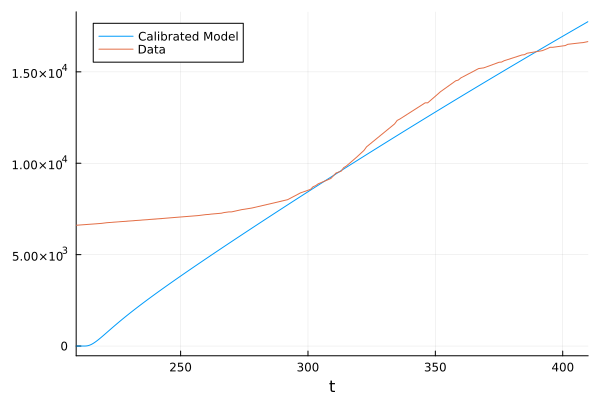

In [24]:
##Deaths - Model 1
model_idx = 1
state_idx = :deceased_population
title = first(split(files[model_idx], "."))
pl1 = plot(sol[model_idx];idxs = state_idx, label = "Calibrated Model")
pl2 = plot!(t_train,last(data_train[model_idx][1].second)[1:train_idx], label = "Data")

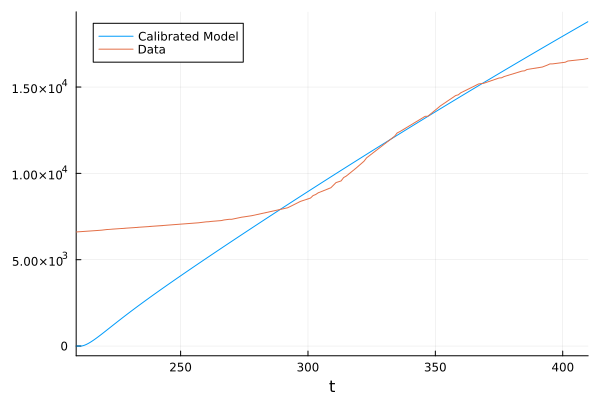

In [23]:
##Deaths - Model 2
model_idx = 2
state_idx = :deceased_population
title = first(split(files[model_idx], "."))
pl1 = plot(sol[model_idx];idxs = :deceased_population, label = "Calibrated Model")
pl2 = plot!(t_train,last(data_train[model_idx][1].second)[1:train_idx], label = "Data")

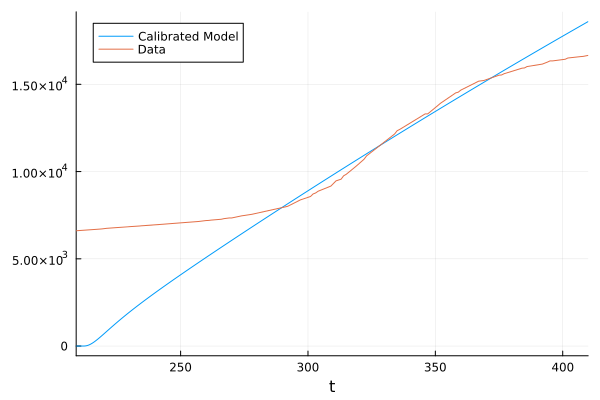

In [25]:
##Deaths - Model 3
model_idx = 3
state_idx = :deceased_population
title = first(split(files[model_idx], "."))
pl1 = plot(sol[model_idx];idxs = :deceased_population, label = "Calibrated Model")
pl2 = plot!(t_train,last(data_train[model_idx][1].second)[1:train_idx], label = "Data")

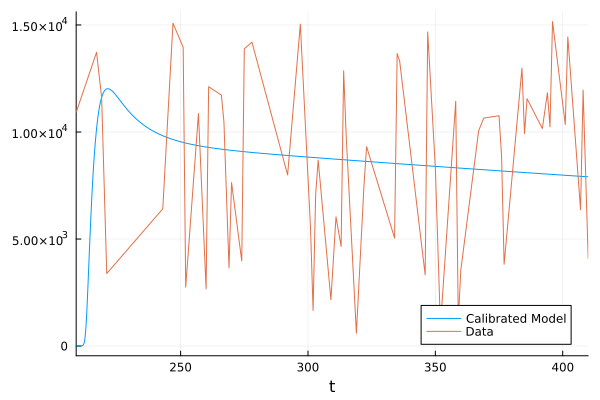

In [26]:
##Hospitalization - Model 1
model_idx = 1
state_idx = :hospitalized_population
title = first(split(files[model_idx], "."))
pl1 = plot(sol[model_idx];idxs = state_idx, label = "Calibrated Model")
pl2 = plot!(t_train,last(data_train[model_idx][2].second)[1:train_idx], label = "Data")

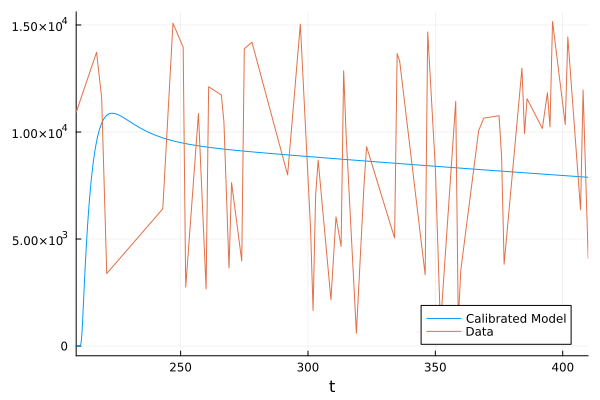

In [27]:
##Hospitalization - Model 2
model_idx = 2
state_idx = :hospitalized_population
title = first(split(files[model_idx], "."))
pl1 = plot(sol[model_idx];idxs = :hospitalized_population, label = "Calibrated Model")
pl2 = plot!(t_train,last(data_train[model_idx][2].second)[1:train_idx], label = "Data")

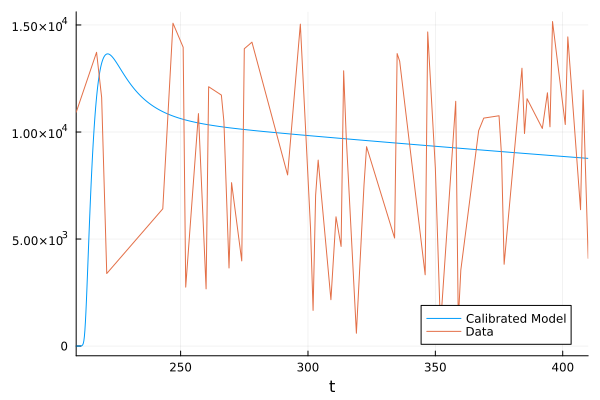

In [28]:
##Hospitalization - Model 3
model_idx = 3
state_idx = :hospitalized_population
title = first(split(files[model_idx], "."))
pl1 = plot(sol[model_idx];idxs = :hospitalized_population, label = "Calibrated Model")
pl2 = plot!(t_train,last(data_train[model_idx][2].second)[1:train_idx], label = "Data")

## <in> Learning Ensemble Weights <in>

In [29]:
##Training Ensemble Modeling
_enprobs = [remake(i, tspan = extrema(t_ensem)) for i in enprobs.prob];
__enprobs = EnsembleProblem(_enprobs);
sol = solve(__enprobs; saveat = t_ensem);
ensem_weights = ensemble_weights(sol, data_ensem[1])

303-element Vector{Float64}:
  7.030586654185887e6
 -2.6438713281470165e7
  1.2562647957520165e7
 -1.7440264490645103e7
  5.61986963830433e6
 -4.655726933729012e7
  6.357004809634466e6
 -6.76791737117403e6
 -1.6553772950266907e7
  4.3729647991944924e7
  ⋮
  1.1070776791879657e8
  8.731995253859296e6
  6.392254664599014e6
 -3.397623275265203e7
  1.9280062598042022e7
 -2.0351661493958957e7
  2.243826770777641e7
  4.5522848285605066e7
  6.5952497344803415e7

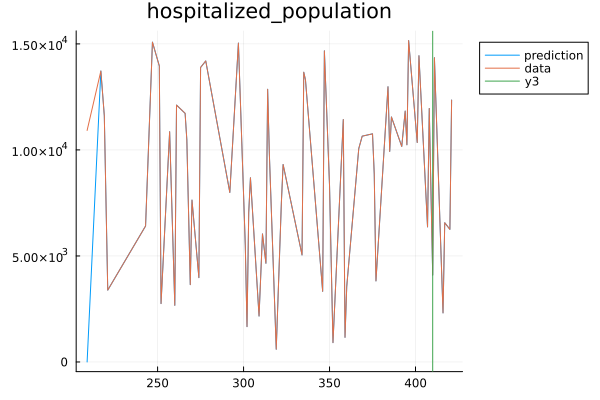

In [40]:
#Visualization
ensem_prediction = sum(stack(ensem_weights .* sol[:,:hospitalized_population]), dims = 2)
plot(t_ensem, ensem_prediction, label = "prediction", title = "hospitalized_population")
plot!(t_ensem, last(data_ensem[1][2][2]), label = "data")
vline!([last(t_train)], legend = :outertopright)

In [43]:
ensem_prediction = sum(stack(ensem_weights .* sol[:,:deceased_population]), dims = 2)
plot(t_ensem, ensem_prediction, label = "prediction",  title = "deceased_population")
plot!(t_ensem, last(data_ensem[1][1][2]), label = "data")
vline!([last(t_train)], legend = :outertopright)

ErrorException: Expects 65 elements in each col of y, found 69.

## Forecasting

In [48]:
_enprobs3 = [remake(i, tspan = extrema(t_forecast)) for i in enprobs.prob];
__enprobs3 = EnsembleProblem(_enprobs3);
sol = solve(__enprobs3; saveat = t_forecast)

EnsembleSolution Solution of length 303 with uType:
ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Vector{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.F

## Visualization

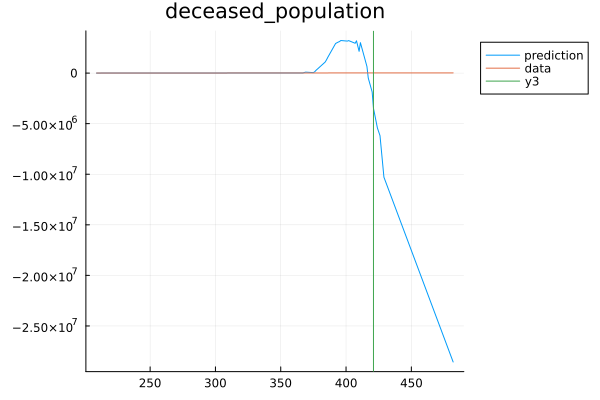

In [49]:
forecast_prediction = sum(stack(ensem_weights .* sol[:,:deceased_population]), dims = 2)
plot(t_forecast, forecast_prediction, label = "prediction", title = "deceased_population")
plot!(t_forecast, last(data_forecast[1][1][2]), label = "data")
vline!([t_ensem[end]], legend = :outertopright)

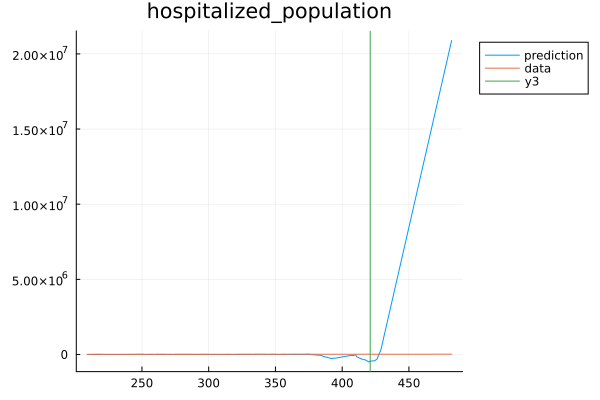

In [50]:
forecast_prediction = sum(stack(ensem_weights .* sol[:,:hospitalized_population]), dims = 2)
plot(t_forecast, forecast_prediction, label = "prediction", title = "hospitalized_population")
plot!(t_forecast, last(data_forecast[1][1][2]), label = "data")
vline!([t_ensem[end]], legend = :outertopright)